This Jupyter Notebook builds upon the referenced [Google Colab](https://colab.research.google.com/drive/1QzQYQxH052Rs088rxMQDveRjoVdkdl74?usp=sharing), integrating customized modifications to address the specific requirements of our testing.

# 1. Load Multimodal Data

## 1.1. Extract and Partition Text, Tables, and Images

In [1]:
# Remove existing figures
!rm -rf ./figures

In [2]:
import os
from langchain_community.document_loaders import UnstructuredPDFLoader

# Directory containing the PDFs
pdf_dir = './references'

# Collect all PDF files from the directory and subdirectories, excluding hidden ones
pdf_files = []
for root, dirs, files in os.walk(pdf_dir):
    # Exclude hidden directories
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    for file in files:
        # Exclude hidden files
        if file.lower().endswith('.pdf') and not file.startswith('.'):
            pdf_files.append(os.path.join(root, file))

# Initialize an empty list to hold data from all PDFs
data = []

# Loop through each PDF file and load it
for pdf_file in pdf_files:
    print(f'Loading {pdf_file}')
    loader = UnstructuredPDFLoader(
        file_path=pdf_file,
        strategy='hi_res',
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",     # section-based chunking
        max_characters=4000,              # max size of chunks
        new_after_n_chars=4000,           # preferred size of chunks
        combine_text_under_n_chars=2000,  # combine smaller chunks
        mode='elements',
        image_output_dir_path='./figures'
    )
    data.extend(loader.load())

Loading ./references/EnerGuide Rating System—Standard—Version 15.12.pdf


/home/shihchi_liu/RAG/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading ./references/Sample 1.pdf


In [3]:
docs = []
tables = []

for doc in data:
    if doc.metadata['category'] == 'Table':
        tables.append(doc)
    elif doc.metadata['category'] == 'CompositeElement':
        docs.append(doc)

len(docs), len(tables)

(58, 27)

In [4]:
import htmltabletomd

for table in tables:
    table.page_content = htmltabletomd.convert_table(table.metadata['text_as_html'])

## 1.2. Examine Loaded Data (Optional)

In [ ]:
from IPython.display import HTML, display, Markdown, Image

In [ ]:
docs[0]

In [ ]:
print(tables[0].page_content)

In [ ]:
tables[0].metadata['text_as_html']

In [ ]:
display(Markdown(tables[0].metadata['text_as_html']))

In [ ]:
for table in tables:
    print(table.page_content)
    print()

In [ ]:
! ls -l ./figures

In [ ]:
Image('./figures/figure-5-4.jpg')

# 2. Connect to LLM through API

In [5]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key:  ········


In [6]:
os.environ['OPENAI_API_KEY'] = OPENAI_KEY

In [7]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

# 3. Generate Text-Based Summaries for Multimodal Data

## 3.1. Create Text and Table Summaries

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements.
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables also add in a one line description of what the table is about besides the summary.
Do not add additional words like Summary: etc.

Table or text chunk:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = (
                    {"element": RunnablePassthrough()}
                      |
                    prompt
                      |
                    chatgpt
                      |
                    StrOutputParser() # Extracts the response as text and returns it as a string
)

# Initialize empty summaries
text_summaries = []
table_summaries = []

text_docs = [doc.page_content for doc in docs]
table_docs = [table.page_content for table in tables]

text_summaries = summarize_chain.batch(text_docs, {"max_concurrency": 5})
table_summaries = summarize_chain.batch(table_docs, {"max_concurrency": 5})

len(text_summaries), len(table_summaries)

(58, 27)

## 3.2. Examine Text and Table Summaries (Optional)

In [ ]:
text_summaries[0]

In [ ]:
table_summaries[0]

## 3.3. Create Image Summaries

In [9]:
import base64
from langchain_core.messages import HumanMessage

# Create a function to encode images
def encode_image(image_path):
    # Get the base64 string
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# Create image summaries
def image_summarize(img_base64, prompt):
    chat = ChatOpenAI(model="gpt-4o", temperature=0)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval.
                Remember these images could potentially contain graphs, charts or tables also.
                These summaries will be embedded and used to retrieve the raw image for question answering.
                Give a detailed summary of the image that is well optimized for retrieval.
                Do not add additional words like Summary: etc.
             """

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

# Image summaries
IMG_PATH = './figures'
imgs_base64, image_summaries = generate_img_summaries(IMG_PATH)

len(imgs_base64), len(image_summaries)

(7, 7)

## 3.4. Examine Image Summaries (Optional)

In [ ]:
display(Image('./figures/figure-1-1.jpg'))

In [ ]:
image_summaries[0]

# 4. Build Multi-Vetor Retrievers: Multimodal and Single-Modal

## 4.1. Access Embedding Model

In [10]:
from langchain_openai import OpenAIEmbeddings

openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-large')

## 4.2. Create Utility Functions

In [11]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.storage import RedisStore
from langchain_community.utilities.redis import get_client
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Create retriever that indexes summaries, but returns raw images or texts
def create_multi_vector_retriever(
    docstore, vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):

    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

## 4.3. Initiate Vectorstores: Chroma

In [12]:
# The vectorstore to use to index the summaries and their embeddings
chroma_db_multimodal = Chroma(
    collection_name="mm_rag",
    embedding_function=openai_embed_model,
    collection_metadata={"hnsw:space": "cosine"},
)

# The vectorstore for single-modal RAG
chroma_db_single_modal = Chroma(
    collection_name="text_rag",
    embedding_function=openai_embed_model,
    collection_metadata={"hnsw:space": "cosine"},
)

## 4.4. Initiate Docstores: Redis and InMemoryStore

In JupyterLab's terminal (File > New > Terminal), run the following commands:

```bash
# 1. Import the GPG key for the Redis repository
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg

# 2. Add the Redis repository to your sources list
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] \
https://packages.redis.io/deb $(lsb_release -cs) main" | \
sudo tee /etc/apt/sources.list.d/redis.list

# 3. Update package lists
sudo apt-get update

# 4. Install Redis Stack Server
sudo apt-get install redis-stack-server

# 5. Start Redis Stack Server in the background
redis-stack-server --daemonize yes
```

In [13]:
# Initialize the storage layer - to store raw images, text and tables
client = get_client('redis://localhost:6379')
redis_store = RedisStore(client=client) # Can use filestore, memorystory, any other DB store also

from langchain.storage import InMemoryStore

# Initialize the storage layer for the single-modal retriever
docstore_single_modal = InMemoryStore()

## 4.5. Create Retrievers

In [14]:
retriever_multimodal = create_multi_vector_retriever(
    redis_store,
    chroma_db_multimodal,
    text_summaries,
    text_docs,
    table_summaries,
    table_docs,
    image_summaries,
    imgs_base64,
)

retriever_multimodal

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0xffe8d045f3a0>, docstore=<langchain_community.storage.redis.RedisStore object at 0xffe8d045dde0>, search_kwargs={})

In [15]:
retriever_single_modal = create_multi_vector_retriever(
    docstore_single_modal,
    chroma_db_single_modal,
    text_summaries,
    text_docs,
    table_summaries=[],  # Empty lists since we're only using text
    tables=[],
    image_summaries=[],  # No images
    images=[],
)

# Verify the single-modal retriever
retriever_single_modal

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0xffe8d045ca90>, docstore=<langchain_core.stores.InMemoryStore object at 0xffe8d0692380>, search_kwargs={})

# 5. Prepare for Retrieval (Optional)

## 5.1. Setup Retrieval Display

In [ ]:
from IPython.display import HTML, display, Markdown, Image
from PIL import Image
import base64
from io import BytesIO

# Disply base64 encoded string as image
def plt_img_base64(img_base64):
    # Decode the base64 string
    img_data = base64.b64decode(img_base64)
    # Create a BytesIO object
    img_buffer = BytesIO(img_data)
    # Open the image using PIL
    img = Image.open(img_buffer)
    display(img)

In [ ]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Get the content
        if isinstance(doc, Document):
            doc_content = doc.page_content
        else:
            doc_content = doc
        # Ensure doc_content is a string
        if isinstance(doc_content, bytes):
            doc_str = doc_content.decode('utf-8')
        else:
            doc_str = doc_content  # already a string
        if looks_like_base64(doc_str) and is_image_data(doc_str):
            b64_images.append(doc_str)
        else:
            texts.append(doc_str)
    return {"images": b64_images, "texts": texts}

## 5.2. Examine Retrievals

In [ ]:
# Check retrieval
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
docs = retriever_multimodal.invoke(query, limit=5)

# We get 4 docs
len(docs)

In [ ]:
docs

In [ ]:
is_image_data(docs[1].decode('utf-8'))

In [ ]:
r = split_image_text_types(docs)
r

In [ ]:
plt_img_base64(docs[1].decode('utf-8'))

# 6. Construct End-to-End RAG Pipeline (Optional)

## 6.1. Chain RAG Components Altogether

In [ ]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage

def multimodal_prompt_function(data_dict):
    """
    Create a multimodal prompt with both text and image context.

    This function formats the provided context from `data_dict`, which contains
    text, tables, and base64-encoded images. It joins the text (with table) portions
    and prepares the image(s) in a base64-encoded format to be included in a message.

    The formatted text and images (context) along with the user question are used to
    construct a prompt for GPT-4o
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            f"""You are an analyst tasked with understanding detailed information and trends from text documents,
                data tables, and charts and graphs in images.
                You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
                Use this information to provide answers related to the user question.
                Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

                User question:
                {data_dict['question']}

                Context documents:
                {formatted_texts}

                Answer:
            """
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

## 6.2. Implement RAG for QA

In [ ]:
# Create RAG chain
rag = (
        {
            "context": itemgetter('context'),
            "question": itemgetter('input'),
        }
            |
        RunnableLambda(multimodal_prompt_function)
            |
        chatgpt
            |
        StrOutputParser()
)

In [ ]:
def rag_qa(query, retriever):

    # Pass input query to retriever and get context document elements
    retrieve_docs = (itemgetter('input')
                        |
                    retriever
                        |
                    RunnableLambda(split_image_text_types))
    
    # Below, we chain `.assign` calls. This takes a dict and successively
    # adds keys-- "context" and "answer"-- where the value for each key
    # is determined by a Runnable (function or chain executing at runtime).
    # This helps in also having the retrieved context along with the answer generated by GPT-4o
    rag_w_sources = (RunnablePassthrough.assign(context=retrieve_docs)
                                        .assign(answer=rag)
    )

    response = rag_w_sources.invoke({'input': query})
    print('=='*50)
    print('Answer:')
    display(Markdown(response['answer']))
    print('--'*50)
    print('Sources:')
    text_sources = response['context']['texts']
    img_sources = response['context']['images']
    for text in text_sources:
        display(Markdown(text))
        print()
    for img in img_sources:
        plt_img_base64(img)
        print()
    print('=='*50)

In [ ]:
def no_rag_qa(query):
    # Create a prompt that only includes the user's question
    messages = [
        HumanMessage(content=f"You are an assistant that answers questions based solely on the input provided.\n\nUser question:\n{query}\n\nAnswer:")
    ]
    
    response = chatgpt.invoke(messages)
    print('=='*50)
    print('Answer:')
    display(Markdown(response.content))
    print('=='*50)

## 6.3. Examine Multimodal RAG (Optional)

In [ ]:
query = "Tell me about the annual wildfires trend with acres burned"
rag_qa(query, retriever_multimodal)

In [ ]:
query = "Tell me about the number of acres burned by wildfires for the forest service in 2021"
rag_qa(query, retriever_multimodal)

In [ ]:
query = "Tell me about the percentage of residences burned by wildfires in 2022"
rag_qa(query, retriever_multimodal)

## 6.4. Examine Single-Modal RAG (Optional)

In [ ]:
query = "Tell me about the annual wildfires trend with acres burned"
rag_qa(query, retriever_single_modal)

In [ ]:
query = "Tell me about the number of acres burned by wildfires for the forest service in 2021"
rag_qa(query, retriever_single_modal)

In [ ]:
query = "Tell me about the percentage of residences burned by wildfires in 2022"
rag_qa(query, retriever_single_modal)

## 6.5. Examine No-RAG (Optional)

In [ ]:
query = "Tell me about the annual wildfires trend with acres burned"
no_rag_qa(query)

In [ ]:
query = "Tell me about the number of acres burned by wildfires for the forest service in 2021"
no_rag_qa(query)

In [ ]:
query = "Tell me about the percentage of residences burned by wildfires in 2022"
no_rag_qa(query)

# 7. Query Energy Advisor Exam Questions

## 7.1. Read the Excel File

In [72]:
import pandas as pd
import re
import base64
import os
from io import BytesIO, StringIO
from PIL import Image as PILImage
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import logging
import requests  # Added for direct API calls

# Step 1: Configure the root logger to suppress all logs below CRITICAL
logging.basicConfig(level=logging.CRITICAL, format='%(levelname)s: %(message)s')

# Step 2: Completely disable specific external library loggers
logging.getLogger('openai').disabled = True
logging.getLogger('urllib3').disabled = True
logging.getLogger('requests').disabled = True
logging.getLogger('httpx').disabled = True
# Disable other external library loggers as needed

# Step 3: Create a dedicated logger for your application to handle warnings
logger = logging.getLogger('EA_Exam_Processor')
logger.setLevel(logging.WARNING)  # Only WARNING and above will be handled

# Path to the Excel file
excel_file_path = './EA QAs/EA QAs.xlsx'

# Read the Excel file into a DataFrame
questions_df = pd.read_excel(excel_file_path, sheet_name='EA QAs')

# Ensure the columns are correct
print("Columns in the Excel file:", questions_df.columns)

Columns in the Excel file: Index(['#', 'Question', 'Image', 'Option', 'Answer'], dtype='object')


## 7.2. Define Helper Functions

In [73]:
# Function to extract the answer from the model's response
def extract_answer(text):
    """
    Extracts the agent's answer, ensuring it is one of (A), (B), (C), or (D).
    Returns the uppercase letter if found, otherwise logs a warning and returns None.
    """
    # Normalize the text
    text = text.strip().upper()
    
    # Use regex to find standalone A, B, C, or D, possibly followed by punctuation
    match = re.search(r'\b([ABCD])\b', text)
    if match:
        return match.group(1)
    
    # Additional checks: look for patterns like "Answer: A" or "A)"
    match = re.search(r'ANSWER[:\s]*([ABCD])', text)
    if match:
        return match.group(1)
    
    match = re.search(r'\b([ABCD])[).\s]', text)
    if match:
        return match.group(1)
    
    return None

In [74]:
# Function to encode the image to Base64
def encode_image(image_path):
    """
    Encodes an image file to a Base64 string after resizing it to a maximum size.
    """
    try:
        with PILImage.open(image_path) as img:
            # Resize the image while maintaining aspect ratio
            img.thumbnail((400, 400), PILImage.LANCZOS)
            # Save the image to a BytesIO object
            buffered = BytesIO()
            img.save(buffered, format="JPEG", quality=85)
            # Encode the image to Base64 and decode to string
            img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
            return img_str
    except FileNotFoundError:
        # Log a warning if the image file is not found
        logger.warning(f"Image file {image_path} not found.")
        return None
    except Exception as e:
        # Log any other exceptions
        logger.warning(f"Error encoding image {image_path}: {e}")
        return None

In [75]:
# Function to resize a Base64-encoded image
def resize_base64_image(img_base64, max_size=(400, 400)):
    """
    Resizes a Base64-encoded image to the specified maximum size.
    """
    try:
        img_data = base64.b64decode(img_base64)
        img = PILImage.open(BytesIO(img_data))
        img.thumbnail(max_size, PILImage.LANCZOS)
        buffered = BytesIO()
        img.save(buffered, format="JPEG", quality=85)
        resized_img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        return resized_img_str
    except Exception as e:
        # Log any exceptions during resizing
        logger.warning(f"Error resizing image: {e}")
        return img_base64  # Return original if resizing fails

In [76]:
# Function to check if a string looks like Base64
def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

In [77]:
# Function to check if Base64 data is an image
def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

In [78]:
# Function to split documents into images, texts, and tables
def split_docs_into_images_texts_tables(docs):
    """
    Splits documents into images, texts, and tables.
    """
    images = []
    texts = []
    tables = []
    for doc in docs:
        # Extract content and metadata
        if isinstance(doc, Document):
            content = doc.page_content
            metadata = doc.metadata
        else:
            content = doc
            metadata = {}
    
        # Ensure content is a string
        if isinstance(content, bytes):
            content = content.decode('utf-8', errors='ignore')
    
        # Extract category from metadata
        category = metadata.get('category', '').lower()
    
        # Check if the document is a table based on metadata or content
        if category == 'table':
            tables.append({'content': content, 'metadata': metadata})
            continue
        elif '<table' in content.lower():
            tables.append({'content': content, 'metadata': metadata})
            continue
        elif detect_markdown_table(content):
            tables.append({'content': content, 'metadata': metadata})
            continue
    
        # Remove data URL prefix if present
        if content.startswith('data:image'):
            content = content.split(',', 1)[1]
    
        # Check if content is an image
        if looks_like_base64(content) and is_image_data(content):
            images.append(content)
        else:
            texts.append(content)
    return {'images': images, 'texts': texts, 'tables': tables}

In [79]:
# Function to limit text length
def limit_text_length(text, max_words=100):
    """
    Truncates the input text to a maximum number of words.

    Parameters:
    - text (str): The input text to truncate.
    - max_words (int): The maximum number of words to retain.

    Returns:
    - str: The truncated text.
    """
    words = text.split()
    return ' '.join(words[:max_words])

In [80]:
# Function to display a Base64-encoded image using matplotlib
def display_base64_image(img_base64):
    """
    Displays a Base64-encoded image using matplotlib.
    """
    try:
        img_data = base64.b64decode(img_base64)
        img = PILImage.open(BytesIO(img_data))
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        logger.warning(f"Error displaying image: {e}")

In [81]:
# Function to make direct API calls with images
def call_openai_api_with_image(messages, max_tokens=300):
    """
    Makes a direct API call to OpenAI's Chat Completion endpoint with structured messages.
    """
    api_key = os.getenv('OPENAI_API_KEY')
    if not api_key:
        logger.error("OpenAI API key not set in environment variables.")
        return None
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    payload = {
        "model": "gpt-4o",
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": 0.7,
        "top_p": 0.9
    }
    
    try:
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.HTTPError as http_err:
        logger.warning(f"HTTP error occurred: {http_err} - Response: {response.text}")
    except Exception as err:
        logger.warning(f"Other error occurred: {err}")
    return None

In [82]:
# Function to detect if text contains a Markdown table
def detect_markdown_table(text):
    """
    Detects if the text contains a Markdown-formatted table.
    """
    lines = text.strip().split('\n')
    if len(lines) >= 2:
        # Check for header separator line (e.g., | --- | --- |)
        header_line = lines[1].strip()
        if re.match(r'^\s*\|?\s*:-{1,}\s*(\|\s*:-{1,}\s*)+\|?\s*$', header_line):
            return True
    return False

## 7.3. Modify RAG Functions

In [83]:
# Modified RAG function using direct API calls
def rag_multiple_choice_qa(question, options, retriever, image_base64=None):
    """
    Answers a multiple-choice question using the given retriever.
    Returns the answer (A, B, C, or D) and the sources.
    """
    # Retrieve relevant documents
    retrieved_docs = retriever.get_relevant_documents(question)
    
    # Split documents into images, texts, and tables
    sources = split_docs_into_images_texts_tables(retrieved_docs)
    
    # Limit text sources to 100 words
    sources['texts'] = [limit_text_length(text) for text in sources['texts']]
    
    # Build the prompt
    formatted_texts = "\n".join(sources['texts'])
    context_text = f"Context documents:\n{formatted_texts}"
    
    # Build the prompt with clear instructions
    prompt_text = f"""You are an assistant that answers multiple-choice questions based solely on the input provided.
You will be given a question, several options, and context documents, which may include text, HTML tables, and images.
Use the context documents to choose the correct option.
Respond with only the letter of the chosen option: A, B, C, or D. Do not provide any additional text.

User question:
{question}

Options:
{options}

{context_text}

Answer:"""
    
    # Prepare the messages
    messages = []
    
    # Include the question image if provided
    if image_base64:
        resized_image_base64 = resize_base64_image(image_base64)
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "User question includes an image."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{resized_image_base64}",
                        "detail": "high"
                    }
                }
            ]
        })
    
    # Add images from retrieved sources
    for image_data in sources['images']:
        resized_img_base64 = resize_base64_image(image_data)
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{resized_img_base64}",
                        "detail": "high"
                    }
                }
            ]
        })
    
    # Add tables from retrieved sources
    for table_dict in sources['tables']:
        table_content = table_dict['content']
        if isinstance(table_content, bytes):
            table_content = table_content.decode('utf-8', errors='ignore')
        messages.append({
            "role": "system",
            "content": table_content
        })
    
    # Add the main prompt
    messages.append({
        "role": "user",
        "content": prompt_text
    })
    
    # Make the API call
    response_json = call_openai_api_with_image(messages, max_tokens=300)
    
    if not response_json:
        return 'Invalid', sources
    
    # Extract the answer
    try:
        answer_text = response_json['choices'][0]['message']['content'].strip()
        answer = extract_answer(answer_text)
    except (KeyError, IndexError) as e:
        logger.warning(f"Error parsing response: {e} - Response: {response_json}")
        return 'Invalid', sources
    
    # If answer is None, log the issue and set to 'Invalid'
    if answer is None:
        logger.warning(f"Invalid answer extracted for question: '{answer_text}'")
        # Optionally, implement a retry mechanism here
        answer = 'Invalid'
    
    return answer, sources

In [84]:
# Modified No-RAG function using direct API calls
def no_rag_multiple_choice_qa(question, options, image_base64=None):
    """
    Answers a multiple-choice question without retrieval (no RAG).
    Returns the answer (A, B, C, or D).
    """
    # Build the prompt with clear instructions
    prompt_text = f"""You are an assistant that answers multiple-choice questions based solely on the input provided.
You will be given a question and several options.
Choose the correct option from the given options, and respond with only the letter of the chosen option: A, B, C, or D. Do not provide any additional text.

User question:
{question}

Options:
{options}

Answer:"""
    
    # Prepare the messages
    messages = []
    
    # Include the question image if provided
    if image_base64:
        resized_image_base64 = resize_base64_image(image_base64)
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "User question includes an image."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{resized_image_base64}",
                        "detail": "high"
                    }
                }
            ]
        })
    
    # Add the main prompt
    messages.append({
        "role": "user",
        "content": prompt_text
    })
    
    # Make the API call
    response_json = call_openai_api_with_image(messages, max_tokens=300)
    
    if not response_json:
        return 'Invalid'
    
    # Extract the answer
    try:
        answer_text = response_json['choices'][0]['message']['content'].strip()
        answer = extract_answer(answer_text)
    except (KeyError, IndexError) as e:
        logger.warning(f"Error parsing response: {e} - Response: {response_json}")
        return 'Invalid'
    
    # If answer is None, log the issue and set to 'Invalid'
    if answer is None:
        logger.warning(f"Invalid answer: '{answer_text}'")
        # Optionally, implement a retry mechanism here
        answer = 'Invalid'
    
    return answer

## 7.4. Process Each Question and Collect Responses

[EA-CIET-001]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Identify the types of systems that can be modelled in the heat/DHW combination screen.

Options:
(A) Propane, gas and oil, and storage tank water heater combo systems (condensing or non-condensing)
(B) Gas and tankless water heater combo systems without a secondary storage tank (condensing or non-condensing)
(C) Propane and tankless water heater combo systems with a secondary storage tank (condensing or non-condensing)
(D) Combo systems using an oil boiler
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[EA-CIET-002]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
How should the Energy Advisor prepare the HOT2000 file for submission to the service organization?

Options:
(A) The energy advisor models the house in HOT2000, saves the calculations as an “h2k” file and submits the house evaluation file to the energy service organization
(B) The energy advisor models the house in HOT2000, saves the calculations as an “hse” file and submits the house evaluation file to the energy service organization
(C) The energy advisor models the house in HOT2000 and saves the calculations as an XML file. The homeowner submits the house evaluation file to the energy service organization
(D) The energy advisor models the house in HOT2000 and saves the calculations as a TXT file. The homeowner converts the house evaluation file into a Homeowner Information Sheet using the Report G

6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-CIET-003]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
An energy advisor must be affiliated with a licensed service organization and registered with Natural Resources Canada prior to offering EnerGuide Rating System services. Among the following, which is not relevant to the registration requirements for energy advisor candidates?

Options:
(A) Demonstrate proficiency by passing the Foundation Level Exam and Energy Advisor Exam
(B) Provide proof of possession of a home warranty number or its provincial/territorial equivalent to the service organization(s)
(C) Complete probationary files to the satisfaction of the service organization’s quality assurance specialist
(D) Provide proof of a Criminal Record Check to the service organization’s manager
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 ADDITIONAL SERVICES ............................................................................................................. 29 APPENDIX A: ASSUMED HOUSE PARAMETERS ..................................................................................... 31 APPENDIX B: CHANGE MANAGEMENT ............................................................................................... 34 APPENDIX C: ATYPICAL ENERGY LOADS ............................................................................................ 35 v EnerGuide Rating System—Standard—Version 15.12 Members of the advisory committees Between the initial start-up meeting in March 2010 and the final approval of their recommendations in September 2012, the individuals listed below worked with Natural Resources Canada to establish the policy direction for this Standard. Members of the Policy Advisory Committee, Subcommittees and Working Groups that provided input to this Standard were as follows (note that individual titles reflect participants’ positions at the time of


Text Source 3:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


Text Source 4:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 ADDITIONAL SERVICES ............................................................................................................. 29 APPENDIX A: ASSUMED HOUSE PARAMETERS ..................................................................................... 31 APPENDIX B: CHANGE MANAGEMENT ............................................................................................... 34 APPENDIX C: ATYPICAL ENERGY LOADS ............................................................................................ 35 v EnerGuide Rating System—Standard—Version 15.12 Members of the advisory committees Between the initial start-up meeting in March 2010 and the final approval of their recommendations in September 2012, the individuals listed below worked with Natural Resources Canada to establish the policy direction for this Standard. Members of the Policy Advisory Committee, Subcommittees and Working Groups that provided input to this Standard were as follows (note that individual titles reflect participants’ positions at the time of


Text Source 3:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


Text Source 4:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


[EA-CIET-004]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
In case of solid-fuel burning equipment, the energy advisor should collect the following information:

Options:
(A) Equipment manufacturer and model, whether the damper is open or closed
(B) Equipment type, flue diameter, whether the damper is open or closed
(C) Equipment type, flue diameter, and the temperature of exhaust gas
(D) Equipment type, flue diameter, the temperature of exhaust gas, and the radiation loss level
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-CIET-005]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What does rated annual energy consumption represent?

Options:
(A) The sum of space heating, space cooling, domestic water heating, distribution of ventilation air (electrical energy consumption only), and electrical base loads
(B) The distribution of ventilation air (electrical energy consumption only) and electrical base loads
(C) The sum of space heating, space cooling, and domestic water heating
(D) None of the above
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Appliance | Standard value (kWh/yr) | House occupant ratio | House value (kWh/yr) | MURB occupant ratio | MURB value (kWh/yr) |
| Refrigerator | 639 |  | 639 |  | 639 |
| Electric range | 565 |  | 565 |  | 565 |
| Clothes washer | 197 | 3/4 | 148 | 2/4 | 98.5 |
| Dishwasher | 260 |  | 260 | 2/4 | 130 |
| Clothes dryer | 916 | 3/4 | 687 | 2/4 | 458 |
| Annual total | 2577 |  | 2299 |  | 1891 |
| Daily total | 7.1 kWhiday |  | 6.3 kWh/day |  | 5.2 kWhiday |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


[EA-CIET-006]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Baseboards, furnaces, boilers and solid-fuel burning appliances may serve as supplementary systems. When this is the case, which data are required to be collected?

Options:
(A) The equipment type, energy source, presence of a pilot, and pilot light energy consumption if available
(B) Equipment type, flue diameter, whether the damper is open or closed, and the number of identically-sized openings (for whole-building MURBs)
(C) The equipment type, flue diameter, and the temperature of exhaust gas
(D) Data are not required for this case
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-CIET-007]
------------------------------
(B): True answer

(C): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(A): No-RAG - WRONG
------------------------------
Question:
Skylights, windows within doors, and patio doors should be modelled:

Options:
(A) In the wizard
(B) In the main interface upon exiting the wizard
(C) Both in the wizard and in the main interface upon exiting the wizard
(D) None of the above
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


[EA-CIET-008]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(A): No-RAG - WRONG
------------------------------
Question:
When modelling a radiant heating system, the modelling requirement(s) to be entered in the radiant heating screen is/are:

Options:
(A) Manufacturer, model, and heating capacity
(B) The effective temperature and percentage of the radiant heated area
(C) The energy factor of radiant heating
(D) The heating capacity and the energy factor of radiant heating
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[EA-CIET-009]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
The air exchange rate per hour at a forced air pressure difference of 50 Pa is calculated by blower door software based on the airtightness test results using a formula where:

Options:
(A) Q = CΔP
(B) Q = CΔPn
(C) Q = mΔPc
(D) Q = nΔPc
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[EA-CIET-010]
------------------------------
(A): True answer

(D): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
If a motorized vent damper is not an option listed in the Equipment Type drop-down menu (e.g. for an oil furnace with flame retention head or gas furnace with continuous pilot), how should the user modify the HOT2000 default Flue Diameter value?

Options:
(A) Decrease by 25 mm (1 in)
(B) Increase by 25 mm (1 in)
(C) Increase by 52 mm (2 in)
(D) Do not modify the default value
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


[EA-CIET-011]
------------------------------
(B): True answer

(D): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
When modelling a heat pump as a ground source heat pump (GSHP), which of the following kinds of information is not required in HOT2000?

Options:
(A) The Unit Function by specifying whether the heat pump is used for heating only or both heating and cooling
(B) The Central Equipment Type by selecting the equipment type as a central split system, central single package system, or mini-split ductless
(C) The Heating/Cooling Efficiency
(D) The Temperature Cut-off Type
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[EA-CIET-012]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
The Personal Information Protection and Electronic Documents Act (PIPEDA) sets out the general rules governing how private-sector organizations collect, use, or disclose personal information in the course of commercial activities across Canada. Among the following statements, which is true?

Options:
(A) It also applies to organizations that are not engaged in commercial activity
(B) It also applies to personal information of employees of federally regulated works, undertakings, or businesses (e.g. banks, airlines, and telecommunications companies)
(C) It also applies to organizations that operate entirely within a province with legislation deemed substantially similar to the PIPEDA if personal information does not cross provincial or national borders
(D) It does not apply to organizations that opera

iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Issuing Agency | Document Number | Title of Document |
| Canadian Commission on Building and Fire Codes (CCBFC) | NRCC 53301 | National Building Code of Canada 2015 |
| Canadian Standard Association (CSA) | CANICSA F 280-12 | Determining the Required Capacity of Residential Space Heating and Cooling Appliances |
| Government of Canada |  | Health Risks of Asbestos (http://healthycanadians.gc.ca/environment- |
|  | environnement/outdoor-air-exterieur/asbestos-amiante- eng.php) |



Table Source 2:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6 ADDITIONAL SERVICES ............................................................................................................. 29 APPENDIX A: ASSUMED HOUSE PARAMETERS ..................................................................................... 31 APPENDIX B: CHANGE MANAGEMENT ............................................................................................... 34 APPENDIX C: ATYPICAL ENERGY LOADS ............................................................................................ 35 v EnerGuide Rating System—Standard—Version 15.12 Members of the advisory committees Between the initial start-up meeting in March 2010 and the final approval of their recommendations in September 2012, the individuals listed below worked with Natural Resources Canada to establish the policy direction for this Standard. Members of the Policy Advisory Committee, Subcommittees and Working Groups that provided input to this Standard were as follows (note that individual titles reflect participants’ positions at the time of


Text Source 4:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


[EA-CIET-013]
------------------------------
(C): True answer

(D): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
For zero-rated homes, the data-collection requirement(s) for dryers are:

Options:
(A) Annual energy consumption as displayed on the EnerGuide label
(B) Manufacturer name and model number
(C) Manufacturer name, model number and annual energy consumption as displayed on the EnerGuide label
(D) None of the above
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 2:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 2:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


[EA-CIET-014]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
How and why should an Energy Advisor create geometry sketches and building plans?

Options:
(A) Geometry sketches and building plans are not mandatory and the Energy Advisor can proceed with the EnerGuide Rating System procedure without them
(B) Geometry sketches and building plans must be clear, complete and sufficiently detailed in order for a third party to recreate the house geometry calculations
(C) Geometry sketches and building plans must be drawn by a third-party specialist to document the house shape for NRCan
(D) Geometry sketches and building plans do not need to be extremely detailed because their main purpose is to provide a general idea to a third party about the house geometry
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-CIET-015]
------------------------------
(D): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
How should a skylight shaft wall be modelled in HOT2000 when it is located in a roof assembly whose depth is filled with insulation?

Options:
(A) Wall regardless of its slope
(B) Glass block configuration
(C) Window regardless of its slope
(D) Can be ignored
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-CIET-016]
------------------------------
(B): True answer

(D): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
If the efficiency of a heat pump or air-conditioning unit is unknown, what further data should be exclusively collected?

Options:
(A) Unit function
(B) Manufacturer and model number
(C) Whether or not the basement is cooled
(D) Model numbers of both the condenser and evaporator coils of ASHPs and central air conditioners
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-CIET-017]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Under which condition should the temperature of cut-off type heat pumps be considered as Restricted?

Options:
(A) If the air-source heat pump shuts down when it is not able to meet the full space heating load
(B) If the air source heat pump shuts off at a user-defined temperature
(C) If interior temperature reaches 72 °F (22 °C)
(D) If the house mechanical system is equipped with a balanced heat recovery ventilator
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


[EA-CIET-018]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
The ERS official marks should never be used in the following manner:

Options:
(A) To suggest that NRCan or any other government body endorses a particular organization, company, or product
(B) To associate the ERS official mark or graphic identifier with products or services not within the scope of the NRCan EnerGuide Rating System
(C) To disparage the Government of Canada, Natural Resources Canada or any other government body
(D) All of the above
------------------------------
Multimodal RAG Sources:
Text Source 1:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


------------------------------
Single-modal RAG Sources:
Text Source 1:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


[EA-CIET-019]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
To take the ERS exams, prospective energy advisors must:

Options:
(A) Register to take the relevant exam(s) at a Natural Resources Canada approved test centre, pay exam fees, write the exam(s) in the presence of a Natural Resources Canada approved exam proctor, and achieve a passing grade on said exam(s)
(B) Register to take the relevant exam(s) at a Service Organization Canada-approved test centre, pay exam fees, write the exam(s) in the presence of a Service Organization Manager-approved exam proctor, and achieve a passing grade on said exam(s)
(C) Register to take the relevant exam(s) online, write the exam(s), and achieve a passing grade on said exam(s)
(D) Pay exam fees (no registration is needed), take the exam online, and achieve a passing grade on said exam(s)
------------------------------


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 ADDITIONAL SERVICES ............................................................................................................. 29 APPENDIX A: ASSUMED HOUSE PARAMETERS ..................................................................................... 31 APPENDIX B: CHANGE MANAGEMENT ............................................................................................... 34 APPENDIX C: ATYPICAL ENERGY LOADS ............................................................................................ 35 v EnerGuide Rating System—Standard—Version 15.12 Members of the advisory committees Between the initial start-up meeting in March 2010 and the final approval of their recommendations in September 2012, the individuals listed below worked with Natural Resources Canada to establish the policy direction for this Standard. Members of the Policy Advisory Committee, Subcommittees and Working Groups that provided input to this Standard were as follows (note that individual titles reflect participants’ positions at the time of


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 ADDITIONAL SERVICES ............................................................................................................. 29 APPENDIX A: ASSUMED HOUSE PARAMETERS ..................................................................................... 31 APPENDIX B: CHANGE MANAGEMENT ............................................................................................... 34 APPENDIX C: ATYPICAL ENERGY LOADS ............................................................................................ 35 v EnerGuide Rating System—Standard—Version 15.12 Members of the advisory committees Between the initial start-up meeting in March 2010 and the final approval of their recommendations in September 2012, the individuals listed below worked with Natural Resources Canada to establish the policy direction for this Standard. Members of the Policy Advisory Committee, Subcommittees and Working Groups that provided input to this Standard were as follows (note that individual titles reflect participants’ positions at the time of


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


[EA-CIET-020]
------------------------------
(B): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Which of the following is not a data field in the Main House selector screen?

Options:
(A) House type
(B) Heating system type
(C) Ceiling type
(D) Year built
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



Table Source 2:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-CIET-021]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
The geometry (footprint) of a house can initially be estimated by HOT2000 by specifying the Width/Depth or Perimeter/Area of the house footprint. How should the Width/Depth or Perimeter/Area be determined?

Options:
(A) Width/Depth or Perimeter/Area determined at the interior extremities of the walls surrounding the heated volume
(B) Width/Depth or Perimeter/Area determined at the exterior extremities of the walls surrounding the heated volume
(C) Width/Depth or Perimeter/Area determined at the interior extremities of the walls surrounding the heated and unheated volume
(D) Width/Depth or Perimeter/Area determined at the exterior extremities of the walls surrounding the heated and unheated volume
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[EA-CIET-022]
------------------------------
(A): True answer

(C): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following is not a valid domestic hot water system?

Options:
(A) Heat pump condensing hot water system
(B) Oil conventional tank hot water system
(C) Induced draft gas-fired hot water system
(D) Tankless propane hot water system
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-CIET-023]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
What is the first step that an energy advisor should take to initiate the Renovation Upgrade Service of a house?

Options:
(A) Determine potential for energy upgrades including those aligned with the planned work
(B) Discuss potential renovation plans and any house-related concerns the homeowner may have
(C) Ensure completeness and accuracy of Basic Service information or perform a Basic Service if it has not been performed
(D) Model the house and the upgrades in HOT2000 to assess potential reduction in energy consumption
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[EA-ENERPREP-001]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Where quality assurance is concerned, which of the following is NOT the EA’s responsibility?

Options:
(A) Respond directly to NRCan on their questions and post audit issues
(B) Implement procedural and guideline changes as disseminated by the SO
(C) When files are requested by QA, submit them within 10 business days
(D) When corrections result in rating changes in the file GJ or more, update labels to HOT
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 4:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


[EA-ENERPREP-002]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
How does HOT2000 perform calculations when a window is modeled in a door?

Note: When a window is modeled in a door, HOT2000 deducts the window area from the door area and calculates a net door area from the gross door area.

Options:
(A) HOT2000 calculates the gross area of the door
(B) HOT2000 deducts the window area from the door area and calculates a net door area
(C) HOT2000 automatically calculates a component RSI/R value of the door
(D) HOT2000 automatically reduces the RSI/R value of the door to account for the window
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[EA-ENERPREP-003]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(D): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
During a basic Service Evaluation, which of the following is eliminated from the scope of work of the EA?

Options:
(A) Execute airtightness test
(B) Use HOT2000 to model the house
(C) Provide the homeowner with the energy action roadmap
(D) Provide images of different parts of the house
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[EA-ENERPREP-004]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
When providing a Basic Service, which of the following information does NOT have to be recorded?

Options:
(A) Dimensions and assembly components of floor headers of closed crawl spaces
(B) Dimensions of a wall adjacent to an enclosed porch
(C) Presence of a swimming pool
(D) Roof color
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


[EA-ENERPREP-005]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What is the default efficiency setting in HOT2000 wizard to enter data into the heating system fields?

Note: It should be % efficiency, based on Steady State.

Options:
(A) % Efficiency
(B) COP
(C) AFUE
(D) HSPF
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


[EA-ENERPREP-006]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
How many calendar days following the evaluation must the EA submit the HIS, house label, and RUR?

Options:
(A) 11
(B) 12
(C) 13
(D) 14
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-ENERPREP-007]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
The annual energy consumption calculation rating is made by which of these statements?

Note: The rated annual energy consumption (C) is the sum of space heating, space cooling, domestic water heating, distribution of ventilation air (electrical energy consumption only), and electrical base loads. The first four terms (ssHH, ssCC, ww, vvEE) are estimated through simulation, while the base loads (bb) are defined in the house standard operating conditions.

(2) cc = ssHH + ssCC + ww + vvEE + bb

Options:
(A) Space heating, space cooling, and electrical base loads
(B) Space heating, space cooling, domestic hot water, ventilation, and electrical base loads
(C) Space heating, space cooling, domestic hot water, and electrical base loads less on-site renewables
(D) Space heating, space cooling, domestic

5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[EA-ENERPREP-008]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
At what heating load is the heating system considered to be a principal system?

Options:
(A) If it is used for at least 65% of the heating load
(B) If it is used for at least 70% of the heating load
(C) If it is used for at least 75% of the heating load
(D) If it is used for at least 80% of the heating load
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


[EA-ENERPREP-009]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
What is the main difference between R-2000 homes and ENERGY STAR certified new homes?

Note: ENERGY STAR certified new homes built to the new standard are on average 20 percent more energy efficient than those built to code. R-2000-certified new homes are best-in-class energy-efficient homes with even higher levels of energy efficiency than ENERGY STAR certified new homes, as well as clean air and environmental features.

Options:
(A) R-2000 houses rate an average of five points higher than an ENERGY STAR qualified house utilizing the ER scale
(B) R-2000 houses are required to meet fewer predetermined energy performance targets compared to ENERGY STAR qualified houses
(C) R-2000 houses are built with even higher levels of energy efficiency than ENERGY STAR qualified houses. R-2000 houses also inc

6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


------------------------------
Single-modal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


[EA-ENERPREP-010]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Under the ERS, how are direct greenhouse gas emissions defined?

Options:
(A) Direct GHG are generated from the production of the electricity of power plants
(B) Direct GHG are the emissions from the production of the renewable energy of power plants
(C) Direct GHG are the emissions offset directly from the production of on-site renewable electricity
(D) Direct GHG are generated from stationary on-site combustion of natural gas, heating oil, etc.
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Table Source 1:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


[EA-ENERPREP-011]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What is represented by the label’s typical new house reference point?

Note: The typical new house reference point reflects the house being rated as if it were built using the energy requirements of the building code. For most jurisdictions, the energy requirements for the reference house will be from the National Building Code of Canada 2010, section 9.36.

Options:
(A) The average ER for houses with similar building characteristics and floor area in the region of the house
(B) The ER for a house built to the ENERGY STAR standard for new homes
(C) The average ER for new houses rated within 5 years in the region of the house being labeled
(D) The ER for the house being rated as if it were built using the National Building Code of Canada energy requirements
------------------------------
Multimoda

4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


------------------------------
Single-modal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


[EA-ENERPREP-012]
------------------------------
(B): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
What critical ceiling/roof assembly data should the EA include on the sketches of the house during the data collection process?

Options:
(A) The slope and heel height of each cathedral ceiling surface
(B) The length and width of each sloped surface without considering the presence of a skylight area
(C) Type, thickness, and RSI/R value of the insulation in the framing cavity and ceiling construction type
(D) The interior finish, structure type (e.g., wood frame, truss, etc.), and the size of the framing
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[EA-ENERPREP-013]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
To model a drain water heat recovery system in HOT2000, what information is required?

Options:
(A) Configuration, flow rate
(B) Unit location, unit length
(C) Manufacturer name, model name
(D) Efficiency at 9.5 L/min, Energy Factor
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-ENERPREP-014]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
How are rated GHG emissions calculated under the ER system?

Options:
(A) By adding the direct and indirect emissions
(B) By multiplying the amount of fuel consumed by the regional emission factor
(C) By multiplying the amount of fuel and electricity consumed by the regional emission factor
(D) By adding the direct and indirect emissions and subtracting indirect emissions offset by renewable electrical energy production
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 4:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 4:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


[EA-ENERPREP-015]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Which statement is false regarding handling personal collection information and an EA’s duty to inform the homeowner (HO) of the collection?

Options:
(A) HO should be informed of the purpose of the collection of personal data
(B) Personal and home-related data may be shared with other agencies without signing forms
(C) House-related data is used for the purpose of calculating house data
(D) The authorized form is voluntary and may not be signed if the HO declines to share personal information
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


[EA-ENERPREP-016]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
An EA would be least likely to recommend installing a solar system in which of the following situations?

Options:
(A) When the house is identified as Solar Ready
(B) When there are tall deciduous trees on all sides of the house
(C) When the homeowner has never considered solar panels on the roof
(D) When the house is a long bungalow and the sloped sections of the roof only face east and west
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-ENERPREP-017]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
Which of the following criteria are required to be eligible under the ERS for buildings containing a mix of residential and commercial occupants?

Note: A combined total floor area of the non-residential occupancies that:
– is less than that of the residential occupancies, excluding parking garages that serve residential occupancies.

Options:
(A) The total combined floor area of the non-residential occupancies must not exceed 250 m².
(B) The total combined floor area of the non-residential occupancies must be less than or equal to that of the residential occupancy.
(C) The total combined floor area of the non-residential occupancies must not exceed 250 m², including parking garages that serve residential occupancies.
(D) The total combined floor area of the non-residential occupancies must be less tha

1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


[EA-ENERPREP-018]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
For ERS service delivery, which is a responsibility of the EA?

Options:
(A) Deliver and measure third-party quality assurance processes
(B) Personally model the HOT2000 files for houses that they have evaluated
(C) Respond to questions and requests from the NRCan account manager
(D) Inform NRCan immediately when a serious problem is identified in a house or the service
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


6 ADDITIONAL SERVICES ............................................................................................................. 29 APPENDIX A: ASSUMED HOUSE PARAMETERS ..................................................................................... 31 APPENDIX B: CHANGE MANAGEMENT ............................................................................................... 34 APPENDIX C: ATYPICAL ENERGY LOADS ............................................................................................ 35 v EnerGuide Rating System—Standard—Version 15.12 Members of the advisory committees Between the initial start-up meeting in March 2010 and the final approval of their recommendations in September 2012, the individuals listed below worked with Natural Resources Canada to establish the policy direction for this Standard. Members of the Policy Advisory Committee, Subcommittees and Working Groups that provided input to this Standard were as follows (note that individual titles reflect participants’ positions at the time of


[EA-ENERPREP-019]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(C): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
How much natural gas energy is equal to one GJ?

Options:
(A) 2.7 cubic meters
(B) 27 cubic meters
(C) 270 cubic meters
(D) 2700 cubic meters
------------------------------
Multimodal RAG Sources:
Text Source 1:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 2:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Table Source 1:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| De-icing cables | 4-10 GJ |
| Electric vehicle charging station | 8-12 GJ |
| Extensive exterior lighting | 5-23 GJ |
| Heated garage (attached or detached) | 10-25 GJ |
| Hot tub | 11-31 GJ |
| Non-residential occupancy |  |
| Outdoor gas appliances | 3-9 GJ |
| Swimming pool | 13-53 GJ |
| Room air conditioner - per unit | 2-10 GJ |



Table Source 2:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| Common space |  |
| Elevator | 3-14 GJ |
| Fitness room | 5-15 GJ |
| Snowmelt system | 5-40 GJ |
| Unheated garage | 5-34 GJ |



------------------------------
Single-modal RAG Sources:
Text Source 1:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 2:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 3:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from


Text Source 4:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


[EA-ENERPREP-020]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
For the configuration of a blower door, which are the correct air tightness protocols that must be followed?

Options:
(A)
 - Min of 5 test points must be documented
 - The lowest starting pressure is 25 pa 
 - Test points below 50 pa or below 15 pa are invalid
(B) 
 - Min of 5 points to be documented
 - The lowest starting pressure is 25 pa
 - Test points above 52.5 and below 12.5 are invalid
(C)
 - A min of 8 points to be documented
 - The lowest starting pressure allowed is 25 pa
 - Test points taken above 50 pa and 15 pa are invalid
(D)
 - Min of eight points to be documented
 - The lowest starting pressure allowed is 30 pa
 - Test points above 52.5 and below 12.5 are invalid
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[EA-ENERPREP-021]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
Which of the following is one of the goals of the Basic Service to provide the homeowner (HO)?

Options:
(A) Applicable health and safety publications
(B) Realistic recommendations
(C) Indoor air quality measurement results
(D) Energy performance data for heating system sizing
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


[EA-ENERPREP-022]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
In the House Envelope screen of the HOT2000 house wizard, which of the following input fields is included?

Note: The five wizard screens are Main, Geometry, House Envelope, Foundation, and Mechanical & DHW.

Options:
(A) Perimeter of basement
(B) Energy source of heating system
(C) Exposed floor insulation properties
(D) Coverage of foundation wall insulation
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-ENERPREP-023]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
If the Basic Service and the RUS are performed at the same time, which of the following is an output received by the homeowner (HO)?

Options:
(A) Homeowner upgrade report
(B) Renovation upgrade report
(C) Energy efficiency upgrade report
(D) Construction upgrade report
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[EA-ENERPREP-024]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
For an EA to become registered, what steps must be taken?

Options:
(A) Pass the foundation level exam, pass the EA exam, complete the required probationary files, provide the SO with proof of ID and a criminal record check
(B) Pass the foundation exam, pass the EA exam, complete the required probationary files, submit files to NRCan for audit
(C) Pass the EA exam, complete the required probationary files, submit probationary files to NRCan for audit, and provide the SO with proof of a criminal record check
(D) Pass the foundation exam, pass the EA exam, complete the probationary files, and send them to NRCan
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.4.1.2 New technologies To accommodate the introduction of new technologies that can affect the EnerGuide Rating, Natural Resources Canada will consider change requests that comply with section 1.4.1.1. As a minimum, for any new technology to be considered by the EnerGuide Rating System, it must fall under a recognized standard under which its performance can be assessed. If the change request is approved by Natural Resources Canada, Natural Resources Canada will develop a project plan for implementation. 4 EnerGuide Rating System—Standard—Version 15.12 2 Reference publications The following referenced documents are required for the administration of this Standard. 2.1 Documents produced


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.4.1.2 New technologies To accommodate the introduction of new technologies that can affect the EnerGuide Rating, Natural Resources Canada will consider change requests that comply with section 1.4.1.1. As a minimum, for any new technology to be considered by the EnerGuide Rating System, it must fall under a recognized standard under which its performance can be assessed. If the change request is approved by Natural Resources Canada, Natural Resources Canada will develop a project plan for implementation. 4 EnerGuide Rating System—Standard—Version 15.12 2 Reference publications The following referenced documents are required for the administration of this Standard. 2.1 Documents produced


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[EA-ENERPREP-025]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(D): No-RAG - WRONG
------------------------------
Question:
What type of foundation is it where the distance between the top of the floor slab and the bottom of the ceiling joist is greater than 1.2 m (4’) and the distance between the floor slab to the grade is equal to or less than 0.6 m (2’) on average?

Options:
(A) Basement
(B) Slab on grade
(C) Open crawl space
(D) Vented crawl space
------------------------------
Multimodal RAG Sources:
Text Source 1:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


------------------------------
Single-modal RAG Sources:
Text Source 1:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


[EA-ENERPREP-026]
------------------------------
(B): True answer

(D): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
How should the water heater be set up when the house has a solar water heater system and the water heater shown in the photo below?

Options:
(A) Primary DHW, oil, tankless coil
(B) Secondary DHW, oil, tankless coil
(C) Primary DHW, oil, conventional tank
(D) Secondary DHW, oil, conventional tank
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


[EA-ENERPREP-027]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(D): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
When the ER is calculated, which of the following is a standard operating condition?

Options:
(A) Hot water load of 172 L per day
(B) Electrical load for five appliances at 6.3 kWh/day
(C) Occupancy load of two adults and two children at home 50% of the time
(D) Temperature set point for heating the main and upper floor at 17°C at night
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-ENERPREP-028]
------------------------------
(D): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Which of the following potential renovations should not be added when discussing the pre-evaluation renovation plans with the homeowner (HO) for the Renovation Upgrade Service?

Options:
(A) Fixing a leaky roof
(B) Replacement of the existing siding
(C) Installation of a rooftop photovoltaic system
(D) Replacement of the main floor carpeting with low-VOC hardwood flooring
------------------------------
Multimodal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-ENERPREP-029]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
In confidence, what type of information requires the EA to abide by the legislation protecting personal information when collecting data?

Options:
(A) Publicly available info
(B) Info about a house’s building envelope
(C) Info containing the homeowner's name
(D) Info about the heating and cooling system of a house
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-ENERPREP-030]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
The Privacy Act relates to which of the following?

Options:
(A) The federal privacy law related to private sector entities
(B) The personal information handling practices of federal government institutions
(C) The personal information handling practices of federally regulated works
(D) The ground rules for how private sector organizations collect, use, or disclose personal information
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


Source: National Interagency Coordination Center (NICC) 2022 Year Number of Fires Acres burned (millions) 2015 2020 2017 2006 2007 Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands. The number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects. Most wildfires are human-caused


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


Source: National Interagency Coordination Center (NICC) 2022 Year Number of Fires Acres burned (millions) 2015 2020 2017 2006 2007 Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands. The number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects. Most wildfires are human-caused


Text Source 3:


1.4.1.2 New technologies To accommodate the introduction of new technologies that can affect the EnerGuide Rating, Natural Resources Canada will consider change requests that comply with section 1.4.1.1. As a minimum, for any new technology to be considered by the EnerGuide Rating System, it must fall under a recognized standard under which its performance can be assessed. If the change request is approved by Natural Resources Canada, Natural Resources Canada will develop a project plan for implementation. 4 EnerGuide Rating System—Standard—Version 15.12 2 Reference publications The following referenced documents are required for the administration of this Standard. 2.1 Documents produced


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[EA-ENERPREP-031]
------------------------------
(A): True answer

(D): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
A high-efficiency furnace and central air conditioner with no electric motor and the thermostat has the furnace set to "on." How is the fan/pump screen modeled with fan modes?

Options:
(A) Heating system fan/pump mode set to "auto", cooling system fan indoor mode set to "auto"
(B) Heating system fan/pump mode set to "auto", cooling system fan indoor mode set to "continuous"
(C) Heating system fan/pump mode set to "continuous", cooling system fan indoor mode set to "auto"
(D) Heating system fan/pump mode set to "continuous", cooling system fan indoor mode set to "continuous"
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



Table Source 2:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 3:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[EA-ENERPREP-032]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
A mini-split heat pump on an air conditioner should be assessed as an atypical energy load in which situation?

Note: If the number of heads for an AC or air-source heat pump with AC is equal to the number of storeys, or to the number of storeys minus one if the house has a basement or a conditioned crawl space, assess as central air conditioning. Otherwise, assess as an atypical energy load.

Options:
(A) When the number of heads for an AC or air-source heat pump with AC is equal to the number of storeys
(B) When the number of heads for an AC or air-source heat pump with AC is equal to three for a three-storey house
(C) When the number of heads for an AC or air-source heat pump with AC is equal to one for a three-storey house with a basement
(D) When the number of heads for an AC or air-source h

4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29116, Requested 1178. Please try again in 588ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-033]
------------------------------
(C): True answer

(D): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
When undertaking a Basic Service or Renovation Upgrade Service, what photos are required for a heat recovery ventilator (HRV)?

Options:
(A) Photo is required
(B) Photo of the unit in the surrounding environment
(C) Photo of the specification plate
(D) Photo with the access door open of the HRV core
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28945, Requested 1128. Please try again in 146ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-034]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
What is the recommended method for modeling building envelope components in HOT2000 when construction details (e.g., lumber, spacing) are known?

Options:
(A) Code Selector
(B) Specific RSI/R value
(C) Composite RSI/R value
(D) Composite RSI/R calculator
------------------------------
Multimodal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[EA-ENERPREP-035]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following window types must the tilt angle be recorded, according to the ERS Technical Procedure?

Options:
(A) Storm
(B) Skylight
(C) Patio door
(D) Semi-sider
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29133, Requested 895. Please try again in 56ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-036]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
With respect to the software, online services, and database, which of the following is not a role of NRCan?

Options:
(A) Maintaining, updating, and providing access to all available energy modeling software packages
(B) Providing access to the ERS report generating software
(C) Maintaining a database of SO, EA, QA specialist, and SO manager
(D) The frequency of requalification of EAs, QA specialists, and SO managers
------------------------------
Multimodal RAG Sources:
Text Source 1:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


Table Source 1:


| | | |
| :--- | :--- | :--- |
| M. Gaudet | Natural Resources Canada Ottawa, Ontario | Natural Resources Canada Advisor |
| D. Haltrecht | Natural Resources Canada Ottawa, Ontario | Manager of the Renewal Process |



Table Source 2:


| | | | |
| :--- | :--- | :--- | :--- |
|  | Ottawa, Ontario |  |  |
| F, Lohmann | National Research Council of Canada |  |  |
|  | Ottawa, Ontario |  |  |
| R. Miller | Canadian Commission on Building Halifax, Nova Scotia | and Fire Codes |  |
| K. Lee | Director, Housing Division, Natural Ottawa, Ontario | Resources Canada, |  |
| D. Haltrecht | Natural Resources Canada Ottawa, Ontario | Manager | of the Renewal Process |
| A. Parekh | Natural Resources Canada Ottawa, Ontario |  | Technical Advisor |
| E. Sampson | Natural Resources Canada |  | Secretary |



Table Source 3:


| | | |
| :--- | :--- | :--- |
| D. Haltrecht | Natural Resources Canada Ottawa, Ontario | Manager of the Renewal Process |



------------------------------
Single-modal RAG Sources:
Text Source 1:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 4:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


[EA-ENERPREP-037]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
As applied to the design cooling load, which of the following is an incorrect statement?

Options:
(A) It includes solar heat gains through glazing
(B) It is calculated using the summer design temperature
(C) It represents the energy consumption of the cooling system
(D) It includes internal gains from electrical base loads and occupants
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


[EA-ENERPREP-038]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(A): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
Performing the air leakage location identification procedure is included in which of the following ERS services?

Options:
(A) Basic Service
(B) Reno Upgrade Service
(C) Atypical energy load assessment
(D) Construction upgrade service for new homes
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


[EA-ENERPREP-039]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What information is required to be calculated for a central air conditioner as part of the procedure for Basic Service data collection?

Options:
(A) Equipment type, basement cooled or not cooled, model number, rated capacity
(B) Airflow or supply, circulation power, composite cooling efficiency, equipment type
(C) Simulation certification number, installation date, installer name and company, model number
(D) Coefficient of performance, ducting to basement, rating condition efficiency, cut off temperature
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[EA-ENERPREP-040]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
An apparent conflict of interest would be created by which of the following?

Options:
(A) Avoiding association with any enterprise of questionable character
(B) Maintaining a close and personal relationship with the homeowner (HO) to ensure positive communication
(C) When involved in construction or renovation of the house, refusing to act as EA for home evaluations
(D) Conducting any activities considered to be a real or perceived conflict with the objectives of the ERS
------------------------------
Multimodal RAG Sources:
Text Source 1:


Non-voting ex officio members D. Hill Canada Mortgage and Housing Corporation


Text Source 2:


Chair Voting members Non-voting ex officio members


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Voting members |  |  |
| D. Bengert | Jayman MasterBuilt Calgary, Alberta |  |
| C. Chopik | Bosley Real Estate Ltd. Ontario |  |
| M. Cureton | Toronto, Vancity Credit Union |  |
|  | Vancouver, British Columbia |  |
| S. Henderson | BfreeHomes Design Ltd. |  |
| J. Huzar | Glen Haven, Nova Scotia Consumer Council of Canada |  |
|  | Victoria, British Columbia |  |
| M. Luymes | Heating, Refrigeration and Air Mississauga, Ontario | Conditioning Institute of Canada (HRAT) |
| C. McBurney | EnerQuality |  |
|  | North Y ork, Ontario |  |
| P. Moffatt | Building Insight Technologies Vancouver, British Columbia |  |
| R. Peters | Canadian Renewable Energy Alliance Ontario |
| S. Koch | Ottawa, NAIMA Canada (North American Ottawa, Ontario | Insulation Manufacturers A ssociation) |
| Non-voting ex officio members |
| S. Deschénes | Natural Resources Canada Ottawa, Ontario | Natural Resources Canada Advi (March 2010 — May 20: |
| D. Haltrecht | Natural Resources Canada Ottawa, Ontario | Manager of the Renewal Proc |
| K. Narvaez | Natural Resources Canada Ottawa, Ontario | Natural Resources Canada Advi |
| E. Sampson | Natural Resources Canada Ottawa, Ontario | Secret |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| S. Goldberg | Canadian Construction Controls Ltd. Ottawa, Ontario |  |
| Voting members |
| M. Bourque | Enerplan Consultants Ltd. Moncton, New Brunswick |  |
| B. Fandrick | Inspections Department Y ellowknife, Northwest Territories |  |
| D. Farcasiu | AmeriSpec Mississauga, Ontario | (May 2010 — December 2010) |
| S. Gruescu | Carson Dunlop Newmarket, Ontario |  |
| T. Hermanson | 4 Element Integrated Design Ltd. Calgary, Alberta |  |
| A. Holley | Integrity Homes 2000 Inc. Dartmouth, Nova Scotia |  |
| G. Lengle | Terasen Gas Surrey, British Columbia |  |
| G. Robson | Prairie House Performance Winnipeg, Manitoba |  |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Non-voting ex officio members D. Hill Canada Mortgage and Housing Corporation


Text Source 2:


Chair Voting members Non-voting ex officio members


Text Source 3:


C. Kahramanoglu Ministry of Municipal Affairs and Housing Whitehorse, Yukon Non-voting ex officio members


Text Source 4:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


[EA-ENERPREP-041]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Under the Main Wall component in the main interface of HOT2000, which of the following building envelope components are modeled?

Options:
(A) Walls of modular daylighting devices
(B) Party walls and interior partition walls
(C) Foundation walls above and below grade
(D) Walls that extend from the floor of the ground level to the ceiling level
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


[EA-ENERPREP-042]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
When should the Construction Blower Service be performed when using a sealed polyethylene air barrier approach?

Options:
(A) After the air barrier is in place, and after the drywall is installed
(B) After the air barrier is in place, and before the drywall is installed
(C) Before the air barrier is in place, and after the drywall is installed
(D) Before the air barrier is in place, and before the drywall is installed
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29097, Requested 1214. Please try again in 622ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28897, Requested 1214. Please try again in 222ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-043]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
If an EA encounters a new uninstalled water heater that is meant to replace the existing non-operating installed domestic water heater, what must they do during an evaluation?

Options:
(A) Assess the existing water heater as broken or unused
(B) Neither water heater is in a functional state, so ignore both of them
(C) Ignore the uninstalled water heater and assess the installed water heater as if it were in working condition
(D) Regardless of its condition, assess the uninstalled water heater as it is meant to replace the currently installed water heater
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28773, Requested 1326. Please try again in 198ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-044]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
An airtightness test was generated by an EA on a new home. The measured air leakage rate was 1.5 ACH @ Pa. During the month of January, the homeowner (HO) noticed significant amounts of condensation on the inside surface of their windows and patio door.

In resolving the window condensation issue, which of the following recommendations would not work?

Options:
(A) Operating the home's system for longer periods of time
(B) Replacing the existing furnace with an electric furnace
(C) Ensuring the exterior of the house is properly vented by the clothes dryer
(D) During every shower or bath and for at least 15 minutes after, operate bathroom exhaust fans
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29036, Requested 1732. Please try again in 1.536s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-045]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
In the renovation upgrade report, which of the following is a rating comparator?

Options:
(A) A typical new house
(B) A typical existing house
(C) Houses in the same province
(D) Houses in the same postal code area
------------------------------
Multimodal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



Table Source 2:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29123, Requested 1124. Please try again in 494ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28950, Requested 1124. Please try again in 148ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-046]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
In accordance with the ERS, what is the maximum slope that qualifies a building envelope component to be considered a roof assembly?

Options:
(A) 30°
(B) 45°
(C) 50°
(D) 60°
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29102, Requested 1126. Please try again in 456ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-047]
------------------------------
(A): True answer

(D): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
To use a user-specific R/RSI value, which of the following building assemblies is it permissible for?

Options:
(A) Basement slab
(B) Ceilings
(C) Floor header
(D) Floor above foundation
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28698, Requested 1492. Please try again in 380ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-048]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(B): No-RAG - WRONG
------------------------------
Question:
A level 3 quality assurance audit that SOs are required to undertake is best described by which of the following?

Options:
(A) Conducting a brief telephone interview with the homeowner (HO) within 60 days after the evaluation date, ensuring that they ask if they signed the EnerGuide evaluation authorization form
(B) Making a quality assurance auditor assess the performance of an EA on an on-site evaluation
(C) Making a quality assurance specialist or auditor complete a Documentation Assessment form to verify the documentation is complete and organized
(D) The quality assurance specialist models the house in HOT2000 using only the data indicated on the energy adviser's data collection forms, photos, and sketch plans
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28898, Requested 1227. Please try again in 250ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-049]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
What data must be collected for solid fuel burning equipment that is NOT considered to be a supplementary heating system?

Options:
(A) Usage
(B) Location heated
(C) Damper position
(D) Approximate door area heated
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29140, Requested 1142. Please try again in 564ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-050]
------------------------------
(D): True answer

(C): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
For a supplementary heating system when used in conjunction with the primary heating system in a given zone, what data must be collected?

Options:
(A) Efficiency
(B) Location heated
(C) Approximate floor area heated
(D) Presence of a pilot light
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29133, Requested 1127. Please try again in 520ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-051]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
For a predetermined period of time, why does NRCan require the SO to store their energy evaluation records?

Options:
(A) To abide by the Access to Information Act and Privacy Act
(B) To allow NRCan to perform quality assurance activities
(C) To facilitate further evaluations that may be undertaken on the same house
(D) To allow the SO to respond to the homeowner (HO) when they have further questions on the house evaluation
------------------------------
Multimodal RAG Sources:
Text Source 1:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Text Source 2:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


------------------------------
Single-modal RAG Sources:
Text Source 1:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Text Source 2:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28860, Requested 1170. Please try again in 60ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-052]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(B): No-RAG - WRONG
------------------------------
Question:
An EA might perform an airtightness test by pressurization instead of depressurization for what reason?

Options:
(A) The house is very leaky
(B) Pressurizing provides more stable readings and the condition is very windy
(C) There is a concern about drawing dust or fibre into the house
(D) The outside temperature is below 20°C
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-ENERPREP-053]
------------------------------
(A): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
When conducting a blower door test on a windy day, which of the following procedures should be carried out?

Options:
(A) Reduce the fan speed in increments of 3 Pa until a total of 12 readings are recorded
(B) Increase the fan speed in increments of 5 Pa and record a minimum of 5 readings
(C) Starting at -55 Pa, reduce the fan speed in increments of 10 Pa and record a minimum of 5 readings
(D) Start recording test points at a pressure difference of 65 Pa until a total of 10 readings are recorded
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29008, Requested 1034. Please try again in 84ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-054]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
For modeling a ground source heat pump, what is NOT an appropriate procedure?

Options:
(A) Set the temperature cut-off type to unrestricted
(B) Use the default heating efficiency generated from the software
(C) Always select heating as the unit function
(D) To indicate the output capacity when the output capacity is known, select user specified
------------------------------
Multimodal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


------------------------------
Single-modal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29031, Requested 1252. Please try again in 566ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-055]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
To use a user-specific R-value for modeling a foundation in the House Wizard, what situation would be appropriate?

Options:
(A) To describe the insulation value of 2" extruded polystyrene installed on the inside of a basement wall
(B) To describe the insulation of 3" expanded polystyrene insulation installed below the slab of a basement
(C) To describe the insulation value of a basement that has 4" fiberglass installed on the inside of the basement wall, but has an uninsulated crawl space
(D) To describe the insulation value of a crawlspace wall that has 2" of spray foam insulation installed on the interior but no insulation in the crawlspace
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28921, Requested 1191. Please try again in 224ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-056]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
A valid blower door test allows up to ±6% variance on what parameter?

Options:
(A) Flow exponent
(B) Equipment leakage area
(C) Correlation coefficient
(D) Relative error of data points
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29060, Requested 1034. Please try again in 188ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-057]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Mixed-use buildings should not have an evaluation performed on them when they fall under which category?

Options:
(A) Life-safety risks: category B
(B) Life-safety risks: category C
(C) Technical risks: category D
(D) Technical risks: category 2
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28868, Requested 1209. Please try again in 154ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-058]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
A “tankless coil” domestic hot water system is best described by which of the following?

Options:
(A) An individual electric tankless water heater serving only one plumbing fixture
(B) A wall-mounted domestic water heater that does not include a built-in buffer storage tank
(C) A copper coil heat exchanger that extends into a space heating boiler. The water is heated as it flows through this coil
(D) A stand-alone domestic water heater with either an electric element or a gas burner that heats the water only when called for
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28898, Requested 1140. Please try again in 76ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-059]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which components must NOT be changed when modeling building envelope upgrades?

Options:
(A) Geometry details
(B) Component label
(C) Framing material type
(D) Thermal resistance values
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28975, Requested 1226. Please try again in 402ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28810, Requested 1226. Please try again in 72ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-060]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
For measuring the overhang width of a window, what is the correct procedure?

Options:
(A) Measure horizontally from the outside edge of the overhang to a line that extends up from the outside face of the glass
(B) Measure vertically from the bottom edge of the window to the top of the window
(C) Measure vertically from the bottom edge of the window to a line that extends horizontally from the outside edge of the overhang
(D) Measure horizontally from the fen edge of the window to the right edge of the window
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28572, Requested 1585. Please try again in 314ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-061]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
In order to provide the ERS evaluation, which of the following lists includes all mandatory equipment and items an EA needs?

Options:
(A) Digital camera, measuring tape, protective gloves, and aluminium foil
(B) Thermometer, borescope, thermal imaging camera, and stud finder
(C) Compass, hygrometer, tape measure, and mirror with extendable handle
(D) Air movement indicator, ladder, flashlight, and acceptable disposable face mask
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28673, Requested 1636. Please try again in 618ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-062]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
The Homeowner Information Sheet provides what main function to the homeowner (HO)?

Options:
(A) A visual roadmap graphic and a table summarizing potential individual and cumulative energy savings within the house
(B) A detailed description of the home's building assemblies and equipment, energy use, and heat loss on the day it was assembled
(C) The total estimated amount of energy the house consumes per year, regardless of the source of energy, expressed as a rating in BTUs
(D) Assistance and renovation strategies that can result in energy savings, financial savings, improved comfort, and reduced GHG
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



Table Source 2:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29218, Requested 1135. Please try again in 706ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-063]
------------------------------
(A): True answer

(D): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
Which corrective measures may necessitate failure to comply with ERA conflict of interest requirements?

Options:
(A) Legal action
(B) Administrative monetary penalties
(C) Mandatory requalification and retesting
(D) Annulment of successful examination credits
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Text Source 3:


Non-voting ex officio members D. Hill Canada Mortgage and Housing Corporation


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Text Source 3:


Non-voting ex officio members D. Hill Canada Mortgage and Housing Corporation


Text Source 4:


6 ADDITIONAL SERVICES ............................................................................................................. 29 APPENDIX A: ASSUMED HOUSE PARAMETERS ..................................................................................... 31 APPENDIX B: CHANGE MANAGEMENT ............................................................................................... 34 APPENDIX C: ATYPICAL ENERGY LOADS ............................................................................................ 35 v EnerGuide Rating System—Standard—Version 15.12 Members of the advisory committees Between the initial start-up meeting in March 2010 and the final approval of their recommendations in September 2012, the individuals listed below worked with Natural Resources Canada to establish the policy direction for this Standard. Members of the Policy Advisory Committee, Subcommittees and Working Groups that provided input to this Standard were as follows (note that individual titles reflect participants’ positions at the time of

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28975, Requested 1177. Please try again in 304ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-064]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Before conducting the service, what would the EA inform the homeowner (HO) to refrain from doing?

Options:
(A) Using hot water from an electric storage tank
(B) Operating a wood-fired appliance
(C) Turning on an electric fireplace
(D) Flushing a toilet
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28922, Requested 1125. Please try again in 94ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-065]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following information inputs are required when modeling a furnace or boiler in HOT2000?

Options:
(A) Flue diameter
(B) Filter thickness
(C) Energy Efficiency Motor Specification
(D) Fan power
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29047, Requested 1381. Please try again in 856ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-066]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following site-specific information is required to determine the valid energy contribution of the wind turbine during the data collection activities for the Basic Services?

Options:
(A) Climate data location
(B) Converter
(C) Turbine
(D) The generator of high
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Table Source 1:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28914, Requested 1198. Please try again in 224ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-067]
------------------------------
(A): True answer

(D): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
Of the following data collection tasks, which is NOT required during Basic Service, but must be completed during the Renovation Upgrade Service?

Options:
(A) Verification of air leakage locations
(B) House dimensions measurements
(C) Indicating the presence of atypical energy loads
(D) Depressurization test of the exhaust device
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29153, Requested 1180. Please try again in 666ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-068]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following reduced electrical base loads may be in zero-rated homes?

Note:
 - Interior Lighting: 25% to 75% of fixtures with compact fluorescent light bulbs or light emitting diodes = 1.6 kWh/day
 - More than 75% of fixtures with compact fluorescent light bulbs or light emitting diodes = 0.6 kWh/day

Options:
(A) Interior lighting
(B) Exterior lighting
(C) Domestic hot water (DHW)
(D) Equipment for heating and cooling systems
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Interior Lighting | 25% to 75% of fixtures with compact fluorescent light bulbs or light emitting diodes | 1.6 kWhiday |
|  | &gt; 75% of fixtures with bulbs or light emitting | compact fluorescent light diodes | 0.6 kWh/day |
| Appliances | &#124; The actual EnerGuide lower than the | appliance rating must be standard values: | Use the actual EnerGuide |
| following |  | appliance rating. |
| Refrigerator: | 639 kWh/yr | If an appliance is not present, |
| Electric range: | 565 kWh/yr | default values must be used. |
| Dishwasher: | 260 kWh/yr |  |
| Clothes washer: | 197 kWh/yr |  |
| Clothes dryer: | 916 kWh/yr |  |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| Electrical load | Houses (kWh/day) | MURB (kWh/day/unit) |
| Interior lighting | 2.6 | 17 |
| Appliances (refer to Table 6) | 6.3 | 5.2 |
| Other electrical | 9.7 | 44 |
| use) Daily total | 19.5 | 11.7 |
| Electrical load | Houses (kWh/day) | MURB (kWh/m?/day) |
| Common space |  | 0.086 |
| Annual total | 25.6 GJ/year | 15.5 GJ/year + common space |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28955, Requested 1176. Please try again in 262ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-069]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
When completing the form for preparation for on-site service, which information is manually collected from the client?

Options:
(A) The number of occupants
(B) The building footprint
(C) Operating conditions of the household
(D) The atypical loads
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29292, Requested 1166. Please try again in 916ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-070]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Which information needs to be collected for floor leaders other than geometric data?

Options:
(A) Type, thickness, and RSI/R value of insulation in framing cavity, sheathing, interior, and exterior finish
(B) Parameter, type, thickness, and RSI/R value of insulation in framing cavity, sheathing, and interior finish
(C) Location, type, thickness, and RSI/R value of insulation in framing cavity, type and thickness of additional insulation, sheathing, and interior finish
(D) Volume, type, thickness, and RSI/R value of insulation in framing cavity, type and thickness of additional insulation, sheathing, and exterior finish
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Table Source 1:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29069, Requested 1124. Please try again in 386ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28908, Requested 1123. Please try again in 62ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-071]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
Of the following elements, which is not considered in the rating?

Options:
(A) A closed crawl space that’s not heated
(B) A tree on the south side of the house
(C) Unconditioned spaces adjacent to the heated volume
(D) An air conditioner component located in the backyard
------------------------------
Multimodal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


------------------------------
Single-modal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-ENERPREP-072]
------------------------------
(D): True answer

(C): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
When calculating a cathedral ceiling with a skylight, what is the correct method?

Options:
(A) Use the horizontal projection of the sloped ceiling
(B) Use the ceiling data calculated by the House Wizard and deduct the skylight area
(C) Calculate the sloped ceiling area with the Pythagorean theorem to calculate and deduct the skylight area
(D) Use the measured length and width of each sloped ceiling surface to determine the total area
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29024, Requested 1126. Please try again in 300ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-073]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
The floor should be modeled as an exposed floor under which condition?

Options:
(A) When the room is located above a garage
(B) When the full-height basement is not heated
(C) When the closed crawl space is the only foundation present
(D) When another foundation is attached to the closed crawl space
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29118, Requested 1216. Please try again in 668ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28897, Requested 1216. Please try again in 226ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-074]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
If it has insufficient mechanical ventilation, what can be concluded about the air leakage area of a house?

Options:
(A) The leakage area is large and thermal
(B) The leakage area is small and normal
(C) It has a small equivalence leakage area
(D) The leakage area is large and normalized
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


[EA-ENERPREP-075]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
How can open crawl spaces be modeled when multiple foundation types exist for a particular house?

Options:
(A) The crawl space can be ignored
(B) They can be modeled as exposed floors
(C) As attached basements
(D) As vented crawl spaces
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29193, Requested 1234. Please try again in 854ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28981, Requested 1173. Please try again in 308ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-076]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
What does the flow exponent "n" having a value of 0.95 indicate in air leakage test data results?

Options:
(A) The blower door test data is not statistically reliable
(B) The ELA @ 10 Pa is greater than 100 cm²
(C) The building envelope has many small holes as opposed to a few large holes
(D) The resistance of air flow through openings in the building envelope is relatively low compared to an "n" of 0.95
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28705, Requested 1433. Please try again in 276ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-077]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
The Construction Blower Door Service serves what purpose?

Options:
(A) Promote and encourage energy efficiency upgrades for houses that are in the design stage
(B) To test whether pressure-induced combustion spillage will likely be caused by exhaust devices
(C) To assist builders and renovators in improving the airtightness of houses and to improve air barrier sealing techniques
(D) To identify whether additional mechanical ventilation is needed and potential indoor air quality issues
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29149, Requested 1189. Please try again in 676ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-078]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
To model a house in HOT2000, which of the following calculations need to be completed?

Options:
(A) Exposed parameter of the garage and volume of floor space and heated floor area
(B) Area of sloped ceiling, exposed surface parameter of the foundation floor header, and attic volume
(C) Above grade height of the highest ceiling and skylight floor volume
(D) Exposed floor, weighted average height of the foundation wall above grade, and heated floor area for each upper floor level
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28900, Requested 1102. Please try again in 4ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-079]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Slab-on-grade foundation in HOT2000 is exclusively associated with what field?

Options:
(A) Heated floor
(B) Integral footing
(C) Floor above frost line
(D) Floor below frost line
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28926, Requested 1316. Please try again in 484ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-080]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(D): No-RAG - WRONG
------------------------------
Question:
If the result of the exhaust depressurization test is greater than 5 pascal, which of the following should an energy advisor NOT do in a house that contains a wood stove?

Options:
(A) Explain the potential adverse effects of combustion spillage to the homeowner
(B) Provide the homeowner with a copy of the fact sheet about combustion spillage
(C) Recommend to the homeowner not to use any of the exhaust fans until the problem is fixed
(D) Recommend that the homeowner install a minimum of one carbon monoxide alarm per floor
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29070, Requested 975. Please try again in 90ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28954, Requested 1116. Please try again in 140ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[EA-ENERPREP-081]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Identical windows of the same orientation can be attached to the same building how many times at the maximum?

Options:
(A) 4
(B) 9
(C) 30
(D) 99
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Building type | # of Adults | # of Children |
| House | 2 | 1 |
| MURB (per unit) | 2 | 0 |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[EA-ENERPREP-082]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What is represented by the "Q" in the Q=CAPn formula?

Options:
(A) The air volume in cubic feet
(B) The flow coefficient in cfm/Pa
(C) The air change rate in number of air changes per hour per square foot
(D) The airflow in cubic feet per minute
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


[EA-ENERPREP-083]
------------------------------
(D): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
What is the main difference between the CGSB standard method and the "as-operated" method when determining the airtightness of the building envelope by fan depressurization method?

Note: The CGSB method considers only unintentional openings in the building envelope by sealing over intentional openings (e.g., flues and HRV vents) during the house preparation task. The "as-operated" method does not include sealing over intentional openings. In addition, all openings such as windows, doors, dampers, and hatches to the exterior are closed in order for the house conditions to reflect normal operating conditions during the heating season.

Options:
(A) The CGSB test seals up certain intentional openings
(B) The CGSB test does not seal up any opening where the as-operated method seals up
(C) The CGSB conside

1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


[EA-ENERPREP-084]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(B): No-RAG - WRONG
------------------------------
Question:
To generate the Homeowner Information Sheet, what is required?

Options:
(A) House photos in .png format, h2k file, and HOT2000 software
(B) EnerGuide Rating label in PDF format; h2k file and the Report Generator application
(C) House photo in .jpg format; h2k file and the Report Generator application
(D) EnerGuide Rating label in PDF format; PDF generator and HOT2000 software
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[EA-ENERPREP-085]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
In HOT2K, why are glazed patio doors entered as window components?

Options:
(A) To account for the different frame size
(B) To include solar gains in the analysis of the house
(C) Due to the lack of insulation as compared to steel insulated exterior doors
(D) To account for increased ventilation throughout the house
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


[EA-ENERPREP-086]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Regarding interaction with NRCan, what responsibility do SO managers have?

Options:
(A) Submit energy evaluation files to NRCan within 14 calendar days of the on-site audit
(B) Submit the SO annual report to NRCan
(C) Submit all probationary training files of the EA candidate to NRCan, along with candidate qualifications
(D) Submit a QA summary report twice a year that tracks all minor and major infractions of the SO's EAs
------------------------------
Multimodal RAG Sources:
Text Source 1:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


Table Source 1:


| | | |
| :--- | :--- | :--- |
| M. Gaudet | Natural Resources Canada Ottawa, Ontario | Natural Resources Canada Advisor |
| D. Haltrecht | Natural Resources Canada Ottawa, Ontario | Manager of the Renewal Process |



Table Source 2:


| | | | |
| :--- | :--- | :--- | :--- |
|  | Ottawa, Ontario |  |  |
| F, Lohmann | National Research Council of Canada |  |  |
|  | Ottawa, Ontario |  |  |
| R. Miller | Canadian Commission on Building Halifax, Nova Scotia | and Fire Codes |  |
| K. Lee | Director, Housing Division, Natural Ottawa, Ontario | Resources Canada, |  |
| D. Haltrecht | Natural Resources Canada Ottawa, Ontario | Manager | of the Renewal Process |
| A. Parekh | Natural Resources Canada Ottawa, Ontario |  | Technical Advisor |
| E. Sampson | Natural Resources Canada |  | Secretary |



Table Source 3:


| | | |
| :--- | :--- | :--- |
| D. Haltrecht | Natural Resources Canada Ottawa, Ontario | Manager of the Renewal Process |



------------------------------
Single-modal RAG Sources:
Text Source 1:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


Text Source 2:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 3:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


Text Source 4:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


[EA-ENERPREP-087]
------------------------------
(A): True answer

(C): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
When conducting a “three zone – one blower door fan” procedure, which of the following is true?

Options:
(A) The airtightness test should begin with all rings
(B) The airtightness test must use three manometers to monitor and record the pressure differential of each
(C) The airtightness must ensure that the exterior doors to the other two zones are kept open during the test to quantify the leakage between them
(D) The airtightness tester can use one manometer and sequentially correct the other two
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-ENERPREP-088]
------------------------------
(A): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
A non-residential occupancy that does not require special precautions to address the transfer to a residential occupancy during an airtightness test is an example of which of the following?

Options:
(A) Daycare facility
(B) Ceramic
(C) Photocopy centre
(D) Pet grooming store
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


[EA-ENERPREP-089]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
With respect to modeling exposed floors, which of the following is true?

Options:
(A) The insulation layer must be spray foam
(B) The volume of the floor must be calculated
(C) The air barrier must be modeled with an R-value of 1.0
(D) To calculate the heat loss, the type of flooring and thickness of the joist must be modeled
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[EA-ENERPREP-090]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
How should an attic space be assessed if significant variation in insulation is visible as part of the Basic Service?

Options:
(A) Average of the variation in insulation components
(B) Two or more attics to account for the differences in composition
(C) Using the lowest R-value found for the entirety of the attic space
(D) Using the highest R-value found for the entirety of the attic space
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-ENERPREP-091]
------------------------------
(D): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
If a house with gable ends contains two ceilings, with one being a large flat ceiling, how are the two ceilings modeled?

Options:
(A) Model both ceilings separately in the house wizard
(B) Only model the ceiling for which the characteristics are known
(C) Model both ceilings as one main user-specific ceiling in the house wizard
(D) Model the larger ceiling in the house wizard and model the smaller ceiling in the main interface
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


[EA-ENERPREP-092]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
For non-condensing types of fossil-fuel heating appliances, how is the steady-state efficiency calculated?

Options:
(A) By dividing the appliance's steady-state output by the input
(B) By dividing the appliance's input capacity by the useful heating energy output capacity
(C) By dividing the appliance's useful heating energy input capacity by the useful heating energy output capacity
(D) By dividing the appliance's heating output during a typical heating season by the total energy input during the same period
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


[EA-ENERPREP-093]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Regarding client satisfaction, which of the following describes the SO manager’s responsibility?

Options:
(A) Manage client satisfaction and follow-up where required
(B) Submit client relations report to NRCan on a quarterly basis
(C) Communicate all quality assurance results to the client during the dispute resolution process
(D) Initiate the suspension and deregistration process of EA with poor client relations
------------------------------
Multimodal RAG Sources:
Text Source 1:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| J. Waugh | Québec, Québec Efficiency New Brunswick Saint John, New Brunswick | (joined April 2012) |
| Non-voting committee | advisors |  |
| J. Beckman | Manitoba Hydro | Information SC Chair |
| J. Douglas | Winnipeg, Manitoba Ministry of Municipal A ffairs and Housing (March | 2010 — March 2012) |
|  | Toronto, Ontario |  |
| S. Goldberg | Canadian Construction Controls Ltd. (Mar. 2010 — Dec. 2011), Realstar Management (Jan. 2012 — present) | Delivery SC Chair |
| J. Hutchinson | Ottawa, Ontario Building and Safety Standards Ministry of Energy and Mines, Victoria, British Columbia |  |
| C.Kahramanoglu | Ministry of Municipal Affairs and Housing Toronto, Ontario | (joined March 2012) |
| L. Marmen | Canadian Gas Association, Ottawa, Ontario (Mar 2010 — May 2011) Retired (May 2011 — present) | Technical SC Chair |
| T. Ross | Labour and Advanced Education Halifax, Nova Scotia |  |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


[EA-ENERPREP-094]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
When applying the energy efficiency requirements from section 9.36 of the National Building Code, which program/mode in HOT2000 is involved?

Options:
(A) Reduced operating conditions for zero-rated house
(B) House with standard operating conditions
(C) House with household operating conditions
(D) EnerGuide Rating System reference house
------------------------------
Multimodal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


------------------------------
Single-modal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


[EA-ENERPREP-095]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Which of the following services does NOT require blower door testing equipment?

Options:
(A) The Basic Service
(B) The Renovation Upgrade Service
(C) The Construction Upgrade Service for New Homes
(D) The Construction Blower Door Service
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-ENERPREP-096]
------------------------------
(A): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
The annual energy use of the rated houses to homes of different levels can be used to compare which information on the EnerGuide label?

Options:
(A) Rated energy intensity
(B) The energy efficiency indicator
(C) Rated annual energy consumption
(D) Rated greenhouse gas emissions
------------------------------
Multimodal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 4:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


------------------------------
Single-modal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 4:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


[EA-ENERPREP-097]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
An EA or SO can refuse to perform an EnerGuide Rating System service under what circumstance?

Options:
(A) Vermiculite insulation is present in sealed wall cavities
(B) The house has an excessively high energy consumption
(C) The occupants refuse to leave the house during the on-site evaluation
(D) Conditions are present that may expose the EA to unacceptable levels of risks
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


[EA-ENERPREP-098]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
The Code of Conduct that the EnerGuide Rating System aims to achieve is best explained by which statement?

Options:
(A) Avoid instigation of dissatisfied customers
(B) Provide a set of rules to be followed by registered energy EAs
(C) Ensure consistency and uniformity across the country with respect to service diversity
(D) Define expectations related to professional behaviour and integrity for the delivery network
------------------------------
Multimodal RAG Sources:
Text Source 1:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 2:


iii EnerGuide Rating System—Standard—Version 15.12 Table of contents


Text Source 3:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


------------------------------
Single-modal RAG Sources:
Text Source 1:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 2:


iii EnerGuide Rating System—Standard—Version 15.12 Table of contents


Text Source 3:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


[EA-ENERPREP-099]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Omitting invalid test points, what is the minimum number of blower door test data that must be entered?

Options:
(A) Five
(B) Four
(C) Seven
(D) Eight
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-ENERPREP-100]
------------------------------
(B): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Doing an EnerGuide rating audit, what is the minimum period of time that an EA must maintain and secure documentation?

Options:
(A) 1 year from the date of the service
(B) 3 years from the date of the service
(C) 5 years from the date of the service
(D) 7 years from the date of the service
------------------------------
Multimodal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



Table Source 2:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 2:


iw i Natural Resources _ Ressources naturelles Canada Canada EnerGuide Rating System Standard Version 15.12 i+l Canada EnerGuide Rating System—Standard—Version 15.12 Information contained in this publication or product may be reproduced, in part or in whole, and by any means, for personal or public non-commercial purposes, without charge or further permission, unless otherwise specified. You are asked to: - exercise due diligence in ensuring the accuracy of the materials reproduced; indicate the complete title of the materials reproduced, and the name of the author organization; and - indicate that the reproduction is a copy of an official work that is


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


[EA-ENERPREP-101]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
For data entry into HOT2000, what steps must an EA carry out as part of preparation?

Options:
(A) Complete all sketches with dimensions, complete all geometry calculations, and ensure all collected data
(B) Complete the Preparation for On-Site service form for the homeowner
(C) Complete the blower door test waivers with client signature
(D) Complete the assessment of the building envelope components
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[EA-ENERPREP-102]
------------------------------
(C): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
In the HOT2000 House Wizard’s “Geometry Details” screen, which calculation result may be entered?

Options:
(A) House volume
(B) Heated floor area
(C) Height of the highest ceiling
(D) Surface area of building component adjacent to an enclosed, unconditioned space
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-ENERPREP-103]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(B): No-RAG - WRONG
------------------------------
Question:
As part of the as-operated blower door test house prep procedure, which of the following is NOT required?

Options:
(A) Close and latch all windows and close doors to the exterior
(B) Close flue dampers connected to solid fuel burning fireplaces and stoves
(C) Open all interior doors including any door to an enclosed furnace or boiler room
(D) Switch off all exhaust and supply fans, and combined supply and exhaust ventilations
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


[EA-ENERPREP-104]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
An energy advisor with access to multiple blower door units, prepares to perform an evaluation on a house with an attached full basement that is used as a full basement apartment. The new basement apartment is no longer accessible from the main part of the house and now has a detached exposed door at the back of the house.

What airtightness procedure should be applied, given the info above?

Options:
(A) One zone – one blower door fan – one test
(B) One zone – two blower door fan – one test
(C) Two zones – two blower door fans – one test
(D) A blower door test cannot be performed under this configuration
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-ENERPREP-105]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
During an energy evaluation, if the EA observes the presence of vermiculite contained in the attic, which of the following steps must be taken?

Options:
(A) Do not proceed with the airtightness test under any circumstance
(B) Provide the homeowner with detailed advice about asbestos abatement
(C) Advise the homeowner to have the vermiculite tested for asbestos
(D) Inform the homeowner of its presence and explain that it may contain asbestos
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


[EA-ENERPREP-106]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
How often is an EA required to pass exams in order to remain registered through at least one licensed SO?

Options:
(A) Every 18 months
(B) Every 2 years
(C) Every 3 years
(D) Every 5 years
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


[EA-ENERPREP-107]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
For additional EA comments, which of the following sections of the Renovation Upgrade Report provides open text boxes?

Options:
(A) Energy Action Roadmap
(B) How Your Home Compares
(C) Recommended upgrade Details
(D) Recommended upgrade and Results
------------------------------
Multimodal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


[EA-ENERPREP-108]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
When an integrated mechanical system is present at home, which of the following info must be collected by on-site observations?

Options:
(A) Manufacture name, model number, and energy source
(B) Number of heads, input capacity, heating efficiency and cooling efficiency
(C) Thermal performance factor, supply and exhaust fan power and annual electrical consumption
(D) Heating capacity, water heater performance factor, nominal burner input and supply and exhaust fan power
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[EA-ENERPREP-109]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
An EA must model the exterior wall colour under what circumstances?
NOTE: Record the predominant exterior wall colour if more than 50% of the walls are uninsulated.

Options:
(A) When the wall colour is dark
(B) When the wall are uninsulated
(C) When the wall is part of an addition
(D) When the cladding differs from that of other modelled walls
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[EA-ENERPREP-110]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(B): No-RAG - WRONG
------------------------------
Question:
In order for a house to be rated under the EnerGuide Rating System, which of the following is required for doors, windows, skylights?

Options:
(A) Broken glazing is not permitted
(B) All windows, doors, and skylight must be installed, with the exception of doors leading to an attached, unheated garage.
(C) Broken glazing is permitted as long as each break is air sealed for the duration of the airtightness test
(D) A combination of two missing windows, exterior doors and skylights is permitted as long as the openings lead to unheated areas of the house
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


[EA-ENERPREP-111]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
If an EA commits a major infraction, what is the consequence?

Options:
(A) The EA must pay a monetary fine
(B) The EA is automatically deregistered
(C) The SO is required to provide a written explanation
(D) The EA is suspended immediately and cannot submit files
------------------------------
Multimodal RAG Sources:
Text Source 1:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Text Source 2:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



Table Source 2:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Text Source 2:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


Text Source 3:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[EA-ENERPREP-112]
------------------------------
(D): True answer

(C): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
Which method is used in HOT2K when multiple foundations are modelled or a house is attached to another house?

Options:
(A) Rectangular
(B) Foundation list
(C) Attachment list
(D) Exposed surface parameter
------------------------------
Multimodal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


------------------------------
Single-modal RAG Sources:
Text Source 1:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[EA-ENERPREP-113]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(A): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
Each of the differences between indoor and outdoor pressure recorded must be within what variance from the target pressure during an airtightness test?

Options:
(A) .5 Pa
(B) 2.5 Pa
(C) 4.5 Pa
(D) 5.5 Pa
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


[EA-ENERPREP-114]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
During preparation, how many probationary files must an EA complete under the Renovation Upgrade Service?

Options:
(A) One observed evaluation, two supervised evaluation and three solo evaluations
(B) Two observed evaluations, two supervised evaluations and two solo evaluations
(C) One observed evaluation, three supervised evaluation and two solo evaluations
(D) Two observed evaluations, two supervised evaluations and three solo evaluations
------------------------------
Multimodal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[EA-ENERPREP-115]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(C): No-RAG - WRONG
------------------------------
Question:
What is the approximate reduction in litres per day for low-flow shower heads under reduced operating conditions for zero-rated homes?

Note: All showerheads are low flow (i.e. 7.6 L/min (1.7 gal./min.) (2 U.S. gal./min.) or less).

Options:
(A) 0
(B) 19
(C) 26
(D) 50
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 2:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Category | Specification | Approximate reduction Liday (U.S. gal/day) |
| Low-flow showerheads | 7.6 Limin (2.0 US gpm) or less | 19 (5.0) |
| Low-flow bathroom faucets &#124; | 5.7 L/min (1.5 US gpm) or less | 10 (2.6) |
| Clothes washer | ENERGY STAR certified | 18 (4.8) |
| Dishwasher | ENERGY STAR certified | 3 (0.8) |
| Approximate total | potential reduction | 50 (13.2) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 2:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


[EA-ENERPREP-116]
------------------------------
(A): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
In HOT2K, how should the fireplace be modelled if the natural gas fireplace is providing extra heat to certain areas of the home for two and a half hours every day, in addition to the forced gas furnace that heats the entire home?

Options:
(A) Usage set to "never"
(B) Usage set to “morning”
(C) Usage set to “preferred time”
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[EA-ENERPREP-117]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
An EA encounters a living area that is located above an unheated garage, what is the provided basic service for a semi-detached house?

Options:
(A) Length and depth to the nearest 6cm
(B) Length and depth to the nearest 10cm
(C) Length and depth to the nearest 20 cm
(D) Length and depth to the nearest 15 cm
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


[EA-ENERPREP-118]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
In the Guide to the EnerGuide Label for Homes, what info is explained and presented in the EnerGuide label?

Options:
(A) Net annual energy consumption in million BTU
(B) None of the above
(C) On-site renewable energy consumption
(D) The actual annual space heating energy consumption in GJ
------------------------------
Multimodal RAG Sources:
Text Source 1:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


iii EnerGuide Rating System—Standard—Version 15.12 Table of contents


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


iii EnerGuide Rating System—Standard—Version 15.12 Table of contents


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[EA-ENERPREP-119]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
For either a heat recovery ventilator or energy recovery ventilator, what info must be collected?

Options:
(A) Information on the determined Dow rate
(B) Value of the supply and exhaust flow rates
(C) Pressure difference
(D) All of the above
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[EA-ENERPREP-120]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
In the image below, the blower door test shows the model in the “air leakage test data” tab of HOT2K. What is invalid in the blower test?

Options:
(A) Rational Exponent is Invalid
(B) Duct Leakage is invalid
(C) Flowent Exposnet " N" is invalid
(D) Flowent Exponent “D” is invalid
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


[EA-ENERPREP-121]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements below best describes a level 4 QA audit?

Options:
(A) An experience EA form the same SO or SO's QA specialist assess the performance of an EA during an on-site evaluation
(B) None of the above
(C) Make sure all procedures are being done off-site
(D) Does not matter
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


1.4.1.2 New technologies To accommodate the introduction of new technologies that can affect the EnerGuide Rating, Natural Resources Canada will consider change requests that comply with section 1.4.1.1. As a minimum, for any new technology to be considered by the EnerGuide Rating System, it must fall under a recognized standard under which its performance can be assessed. If the change request is approved by Natural Resources Canada, Natural Resources Canada will develop a project plan for implementation. 4 EnerGuide Rating System—Standard—Version 15.12 2 Reference publications The following referenced documents are required for the administration of this Standard. 2.1 Documents produced


Table Source 1:


| | |
| :--- | :--- |
| Title and description |  |
| EnerGuide Rating System—Administrative Procedures—Version 15.x |
| Defines key roles, responsibilities and required administrative procedures |  |
| EnerGuide Rating System—Technical Procedures—Version 15.x |  |
| Defines required on-site data collection and evaluation procedures and protocols |  |
| EnerGuide Rating System—HOT2000 User Guide—Version 15.x |  |
| Defines procedures and protocols for the use of the HOT2000 energy modelling software in ratings and other outputs of the EnerGuide Rating System | producing EnerGuide |
| EnerGuide Rating System—Quality Assurance Procedures—Version 15.x Defines the quality assurance audit process that validates overall service organization and energy | advisor |
| performance, effectiveness, and compliance with initiative procedures and guidelines EnerGuide Rating System—File Submission User Guide—Version 15.x Defines the for file submission and treatment of submission issues |  |
| process EnerGuide Rating System—Workaround and Conversion Guide for HOT2000 v.11.12—Version 15.x |
| Provides workarounds to address issues identified in HOT2000 and the Report Generator to facilitate modelling and the generation of the label and homeowner reports |
| Canada Greener Homes Initiative—Information Manual for Service Organizations and Energy Advisors— Version x |
| Provides service organizations and energy advisors with information and guidance on the delivery Greener Homes Initiative Maps of Climate Data | of the Canada |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


1.4.1.2 New technologies To accommodate the introduction of new technologies that can affect the EnerGuide Rating, Natural Resources Canada will consider change requests that comply with section 1.4.1.1. As a minimum, for any new technology to be considered by the EnerGuide Rating System, it must fall under a recognized standard under which its performance can be assessed. If the change request is approved by Natural Resources Canada, Natural Resources Canada will develop a project plan for implementation. 4 EnerGuide Rating System—Standard—Version 15.12 2 Reference publications The following referenced documents are required for the administration of this Standard. 2.1 Documents produced


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


[EA-ENERPREP-122]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Before performing an exhaust device depressurization test, how should a house be prepared?

NOTE: To simulate a worst case scenario, close all interior doors to rooms that do not have a combustion appliance or exhaust device present. Leave interior doors open to rooms or areas with a combustion appliance or exhaust device present.

Options:
(A) Open all exterior doors to rooms that do not have combustion appliance
(B) Close all interior doors to rooms that do not have combustion appliance
(C) Open all interior doors to rooms that do have a combustion appliance
(D) Close all interior doors to rooms that do have a combustion appliance
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


[EA-ENERPREP-123]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
When a closed crawl space is modelled in OT2000, which component must be modelled separately?

Options:
(A) basement
(B) garage
(C) Space floor header
(D) Ceiling
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-ENERPREP-124]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Basic Service is performed on a house that did not contain any spillage susceptible equipment. Which action should be performed by the EA in order to perform the airtightness test?

Options:
(A) Turn off the cloth dryer
(B) For any fireplace, close the flue
(C) None of the above
(D) If the seal was broken during the attic inspection, re-seal the attic hatch
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[EA-ENVIRO-001]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
Which of the following best describes an objective of the ERS?

Options:
(A) Encouraging energy performance advancements
(B) Providing specific, readily accessible personal energy information to utilities
(C) Helping homeowners, industry, and stakeholders become energy illiterate
(D) Facilitating homeowner access to grants and rebates
------------------------------
Multimodal RAG Sources:
Text Source 1:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


iii EnerGuide Rating System—Standard—Version 15.12 Table of contents


------------------------------
Single-modal RAG Sources:
Text Source 1:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


iii EnerGuide Rating System—Standard—Version 15.12 Table of contents


[EA-ENVIRO-002]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
The following is not equivalent to 1 GJ:

Options:
(A) 1,000,000,000 Joules of energy
(B) 27 m³ natural gas
(C) 26 L fuel oil
(D) 95,000 BTU
------------------------------
Multimodal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from


Table Source 1:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| De-icing cables | 4-10 GJ |
| Electric vehicle charging station | 8-12 GJ |
| Extensive exterior lighting | 5-23 GJ |
| Heated garage (attached or detached) | 10-25 GJ |
| Hot tub | 11-31 GJ |
| Non-residential occupancy |  |
| Outdoor gas appliances | 3-9 GJ |
| Swimming pool | 13-53 GJ |
| Room air conditioner - per unit | 2-10 GJ |



Table Source 2:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| Common space |  |
| Elevator | 3-14 GJ |
| Fitness room | 5-15 GJ |
| Snowmelt system | 5-40 GJ |
| Unheated garage | 5-34 GJ |



------------------------------
Single-modal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from


Text Source 3:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 4:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


[EA-ENVIRO-003]
------------------------------
(A): True answer

(D): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
On the EGH label, "A typical new house" shows the rating of:

Options:
(A) A house with similar characteristics to yours
(B) A house of the same size, built within the past 5 years
(C) An average new house in the same climate zone
(D) A "standard" house built to the 2017 Ontario Building Code
------------------------------
Multimodal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


------------------------------
Single-modal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


[EA-ENVIRO-004]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
The following will trigger the Mechanical Ventilation Warning:

Options:
(A) The average total ventilation rate during the critical month is less than the warning flow rate
(B) The average total ventilation rate during the critical month is more than the warning flow rate
(C) The exhaust devices depressurization test indicates a depressurization of five Pa or more
(D) The exhaust devices depressurization test indicates a depressurization of five Pa or less
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


[EA-ENVIRO-005]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
In a mixed-use building, a business is next to the home being evaluated. Which one of the following businesses would present the least risk to the blower test going ahead?

Options:
(A) Book binding
(B) Hardware store
(C) Restaurant
(D) Metal plating shop
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[EA-ENVIRO-006]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(A): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
The following is not a role of an EA:

Options:
(A) Model the HOT2000 files for houses they have evaluated
(B) Inform clients of potential health and safety risks discovered during the evaluation
(C) Ensure the homeowner understands that recommendations are based on the EA's best judgment
(D) Place the self-adhesive EnerGuide label on the electrical panel
------------------------------
Multimodal RAG Sources:
Text Source 1:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 2:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


Text Source 3:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


Table Source 1:


| | | |
| :--- | :--- | :--- |
|  | Alberta |  |
| F. Dubrous | Resources Canada |  |
|  | Ontario |  |
| A. McGowan | Consultants Ltd. British Columbia |  |
| J. Murdock | Insight Technologies British Columbia | External Expert |
| Non-voting ex officio members |
| E. Sampson | Resources Canada Ontario | Secretary |
| Training Working Group members |
| Chair |
| T. Hermanson | Integrated Design Ltd. Alberta |  |
| Voting members |
| J. Brodeur | Resources Canada Ontario |  |
| D. Farcasiu | Ontario | (May 2010 — December 2010) |
| D. Foster | Homebuilders’ Association Ontario | External Expert |
| S. Gruescu | Ontario xl |  |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 2:


Voting members Non-voting ex officio members Natural Resources Canada Advisor (March 2010 – May 2011) Manager of the Renewal Process Natural Resources Canada Advisor Secretary ix EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Technical Subcommittee members Chair L. Marmen Canadian Gas Association, Ottawa, Ontario (Mar 2010 – May 2011) Retired (May 2011 – present) Voting members A. Brooks ATCO Energy Sense


Text Source 3:


Voting members St John’s, Newfoundland and Labrador vi EnerGuide Rating System—Standard—Version 15.12 J. Sparling Department of Environment and Natural Resources


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


[EA-ENVIRO-007]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
The following is not a Basic Service output:

Options:
(A) Homeowner Information Sheet
(B) EnerGuide label
(C) Guide to the EnerGuide Label for Homes
(D) Renovation Upgrade Report
------------------------------
Multimodal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Table Source 1:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[EA-ENVIRO-008]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
The following best describes four of the household operating conditions:

Options:
(A) Number of occupants, type of washer, type of lighting, and temperature set points
(B) Number of occupants, type of washer, age of other appliances, and heating degree days
(C) Number of occupants, type of lighting, age of washer, and temperature set points
(D) Type of washer, type of lighting, age of appliances, and temperature at time of assessment
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 2:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 2:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


[EA-ENVIRO-009]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
The following is not mandatory equipment for evaluations:

Options:
(A) Thermometer
(B) Low-emissivity window coating detector
(C) Compass
(D) Hygrometer
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


[EA-ENVIRO-010]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
The following best describes the subject of an N evaluation:

Options:
(A) A house that has been occupied for less than six months
(B) A house that had upgrades performed subsequent to a previous Basic Service
(C) A house that has been occupied for six months or more
(D) A multi-unit building that has been occupied for six months or more
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.4.1.2 New technologies To accommodate the introduction of new technologies that can affect the EnerGuide Rating, Natural Resources Canada will consider change requests that comply with section 1.4.1.1. As a minimum, for any new technology to be considered by the EnerGuide Rating System, it must fall under a recognized standard under which its performance can be assessed. If the change request is approved by Natural Resources Canada, Natural Resources Canada will develop a project plan for implementation. 4 EnerGuide Rating System—Standard—Version 15.12 2 Reference publications The following referenced documents are required for the administration of this Standard. 2.1 Documents produced


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.4.1.2 New technologies To accommodate the introduction of new technologies that can affect the EnerGuide Rating, Natural Resources Canada will consider change requests that comply with section 1.4.1.1. As a minimum, for any new technology to be considered by the EnerGuide Rating System, it must fall under a recognized standard under which its performance can be assessed. If the change request is approved by Natural Resources Canada, Natural Resources Canada will develop a project plan for implementation. 4 EnerGuide Rating System—Standard—Version 15.12 2 Reference publications The following referenced documents are required for the administration of this Standard. 2.1 Documents produced


Text Source 2:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 3:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


[EA-ENVIRO-011]
------------------------------
(C): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
What is the R value of the attic insulation in the photo, assuming the average depth is 11"?


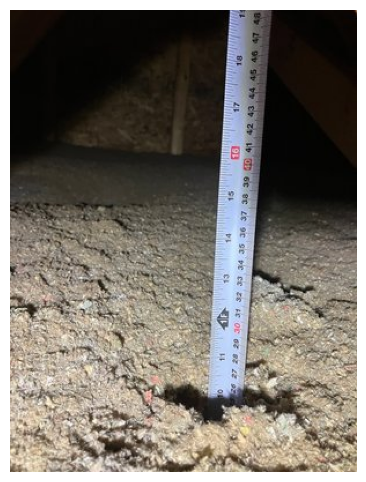


Options:
(A) R20
(B) R28
(C) R40
(D) R36
------------------------------
Multimodal RAG Sources:
Text Source 1:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 2:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


EnerGuide Rating System—Standard—Version 15.12 A. Holley Integrity Homes 2000 Inc.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


[F-CIET-001]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Calculate the heated floor area based on the interior wall dimensions presented below. The walls have a thickness of 0.3 m (1.0 ft.).


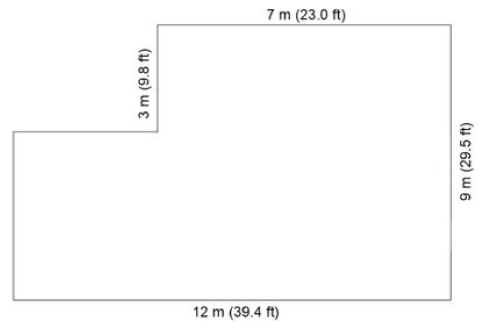


Options:
(A) 93 m² (1,001 ft²)
(B) 69 m² (743 ft²)
(C) 73 m² (786 ft²)
(D) 68 m² (732 ft²)
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[F-CIET-002]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Calculate the heated floor area based on the lengths of the interior walls presented below. The walls have a thickness of 0.3 m (1.0 ft.).


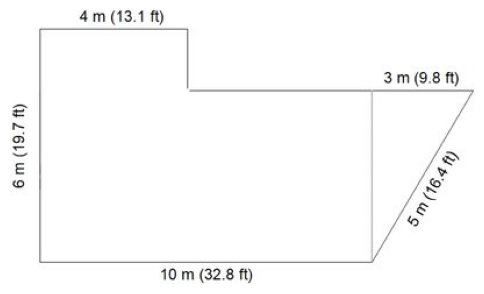


Options:
(A) 52 m² (560 ft²)
(B) 38 m² (409 ft²)
(C) 54 m² (581 ft²)
(D) 40 m² (431 ft²)
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[F-CIET-003]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Calculate the heated floor area based on the lengths of the exterior walls presented below. The walls have a thickness of 0.3 m (1.0 ft.).


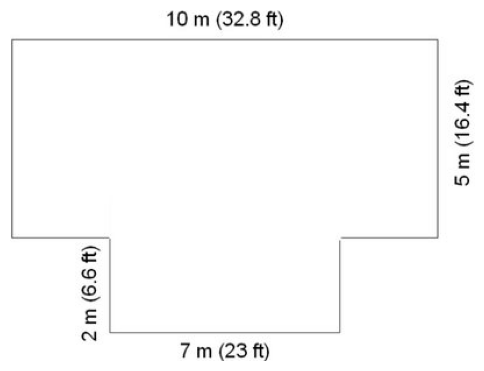


Options:
(A) 64 m² (689 ft²)
(B) 48 m² (517 ft²)
(C) 54 m² (581 ft²)
(D) 57 m² (614 ft²)
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[F-CIET-004]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
A roof has a run of 6 feet and a rise of 3 feet. What is its slope?

Options:
(A) 6/3
(B) 1/2
(C) 3/12
(D) 12/3
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Building type | # of Adults | # of Children |
| House | 2 | 1 |
| MURB (per unit) | 2 | 0 |



Table Source 2:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[F-CIET-005]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
A roof has a rise of 10 feet and a span of 20 feet. What is its slope?

Options:
(A) 1/2
(B) 20/10
(C) 1/1
(D) 5/20
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


[F-CIET-006]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
A roof has a rafter with a length of 25 feet and a rise of 15 feet. What is its slope?

Options:
(A) 3/4
(B) 5/4
(C) 4/5
(D) 4/3
------------------------------
Multimodal RAG Sources:
Text Source 1:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[F-CIET-007]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What is the heating capacity in kW of an 80,000 BTU/h furnace?

Options:
(A) 23.44 kW
(B) BTU/h is an energy unit and cannot be converted to kW
(C) 23,440 kW
(D) 273.04 kW
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


[F-CIET-008]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What characterizes effective thermal resistance?

Options:
(A) It is the insulation value of the material itself
(B) It is the overall insulation value when taking into account all building components of the assembly
(C) It is the insulation value of all building components other than the insulating material
(D) It is the insulation value when taking into account heating degree days
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


[F-CIET-009]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is true about the house wrap air barrier approach?

Options:
(A) It is sealed around service penetrations using caulking, tape or a gasket
(B) It covers the outside wall of the foundations
(C) Plastic air-tight electrical boxes can be used to ensure continuity around in-house electrical boxes
(D) The house wrap is sealed directly to the window frame using expanding foam
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[F-CIET-010]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Which of the following is not included in an effective wall drainage system?

Options:
(A) Surface drainage to direct water away from the foundation
(B) Free-drainage backfill or a drainage plane next to the foundation
(C) Graded drainage pipe system
(D) A permeable top layer that channels water to the drainage pipe system
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


[F-CIET-011]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is true about an EIFS?

Options:
(A) It is a preassembled exterior insulation finish system composed of sheathing, insulation, base coat, and finish coat
(B) It acts as an air barrier
(C) It reduces thermal bridging through framing
(D) EIFS are standardized systems that can all be installed the same way
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


[F-CIET-012]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
What is an advantage of adding below grade wall insulation to the exterior of a building envelope?

Options:
(A) No disruption in the house, no interior work disturbed, but inside space is lost
(B) Freeze-thaw stresses are eliminated, and frost is unlikely to penetrate down to the footings
(C) The mass of the foundation is within the insulated portion of the house and will tend to even out temperature fluctuations
(D) Can lead to the identification of other hidden problems that require attention
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


[F-CIET-013]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
Which of the following statements is false regarding high efficiency mechanical systems in houses and residential buildings?

Options:
(A) Integrated mechanical systems (IMS) group the functions of space heating, water heating and heat recovery ventilation into a single package
(B) Geothermal heat pump systems have an estimated working life of 25 years
(C) Air-source heat pumps draw heat from outside air during the heating season and reject outside heat during the cooling season
(D) Ground-source heat pumps use the earth, ground water or both as heat sources in the summer and as the heat sink in the winter
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[F-CIET-014]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements about the ladder safety protocol is false?

Options:
(A) Check for overhead power lines before setting up a ladder
(B) Clear debris, tools and other objects from the area around the base and top of the ladder
(C) Maintain three-point contact by keeping two hands and one foot, or two feet and one hand on the ladder at all times
(D) Tie yourself to a safety harness when working 5 m (16 ft.) or more off the ground or when working with both hands
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


[F-CIET-015]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
Which statement below is false about an effective air barrier?

Options:
(A) It is a leakage control system
(B) There can be multiple air barriers
(C) It can only be located on the cold side of the assembly to avoid condensation
(D) The main air barrier material forms a principal plane
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[F-CIET-016]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(B): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
The windows depicted below have the same Uframe (5 W/m²K), UEdge (1.9 W/m²K) and UGlazing (1.7 W/m²K). They also all have the same frame width. Which of the following has the lowest heat loss as a whole unit? All dimensions are glazing dimensions.


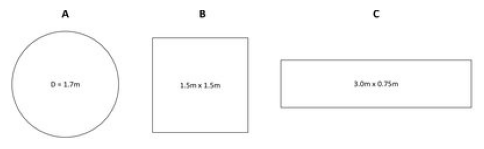


Options:
(A) Window A
(B) Window B
(C) Window C
(D) They are all the same
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[F-CIET-017]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
What is the main purpose of the HSG low-e coating during the cooling season?

Options:
(A) To limit conduction losses through the glazing
(B) To reduce heat gains
(C) To help limit air leakage and condensation in the glazing
(D) To reduce radiation heat losses
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[F-CIET-018]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(A): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements about argon-filled windows is true?

Options:
(A) This method reduces radiation heat losses and improves the overall U-factor
(B) This method limits heat losses by suppressing gas movement between window panes
(C) This method reduces the risk of condensation between window panes
(D) These windows always have higher U-factors compared to krypton-filled windows
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


[F-CIET-019]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
Which of the following statements is true about residential Fenestration Energy Ratings?

Options:
(A) A negative rating indicates that heat gains are superior to heat losses
(B) It represents a window’s overall heat loss coefficient expressed in W/m²K or in Btu/(hr)(ft²)(°F)
(C) It is adversely affected by air exfiltration only
(D) ER ratings do not apply to skylights
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


[F-CIET-020]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What is required to comply with ENERGY STAR?

Options:
(A) For zone 1 window compliance: Have U-factor below 1.60 W/m²K and an energy rating above 16
(B) For zone 1 skylight compliance: Have U-factor below 1.60 W/m²K and an energy rating above 16
(C) For zone 2 window compliance: Have U-factor below 1.60 W/m²K and an energy rating above 16
(D) For zone 2 skylight compliance: Have U-factor below 1.40 W/m²K and an energy rating above 20
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000


[F-CIET-021]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
What is the winter outdoor design temperature?

Options:
(A) The lowest possible temperature that can be expected during a winter
(B) The temperature below which heating equipment starts supplying heat
(C) The temperature below which heating equipment cannot meet indoor temperature set-points
(D) The temperature at which heating equipment should be operating at peak efficiency
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


[F-CIET-022]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is true regarding the peak heating load requirements of a home?

Options:
(A) It is always cost effective for a geothermal system to be sized to meet the full heating load
(B) Thermal bridging cannot be neglected when calculating heating loads because it accentuates heat transfer
(C) Lower U-values lead to higher heating loads
(D) When a central heating system is used, the heating load is the same for all the rooms of a house
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


[F-CIET-023]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false regarding the cooling load?

Options:
(A) The peak cooling load occurs during the peak heat gain period of the day
(B) The cooling load represents the heat extraction rate required to meet given indoor conditions
(C) The cooling load can be expressed in W or Btu/h
(D) Limiting air infiltration can reduce the cooling load
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29116, Requested 981. Please try again in 194ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-024]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
You have a BBQ with a maximum heat output of 30,000 Btu/h (power); what is the equivalent in W?

Options:
(A) 8,800 W
(B) 8,400 W
(C) 28,400 W
(D) Btu/h is energy, while W is power
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



Table Source 2:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| De-icing cables | 4-10 GJ |
| Electric vehicle charging station | 8-12 GJ |
| Extensive exterior lighting | 5-23 GJ |
| Heated garage (attached or detached) | 10-25 GJ |
| Hot tub | 11-31 GJ |
| Non-residential occupancy |  |
| Outdoor gas appliances | 3-9 GJ |
| Swimming pool | 13-53 GJ |
| Room air conditioner - per unit | 2-10 GJ |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


Table 6 - Standard appliance loads

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29130, Requested 1204. Please try again in 668ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28960, Requested 1178. Please try again in 276ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-026]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false?

Options:
(A) For the purpose of space and water-heating in homes, gas combustion occurs in liquid state
(B) Oil combustion occurs in liquid state
(C) Oil-fired combustion efficiency increases with higher static burners
(D) Natural gas is composed of a high percentage of methane (CH₄) (generally above 85 percent) and varying amounts of ethane, propane, butane, and inert gases (typically nitrogen, carbon dioxide, and helium)
------------------------------
Multimodal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29224, Requested 1175. Please try again in 798ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-027]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false?

Options:
(A) Solar domestic hot water systems are used as energy efficiency and renewable energy measures in Canada
(B) Lower standby losses mean higher efficiency for electrical water heaters
(C) Gas-fired water heaters and electric water heaters have the same energy efficiency rating system
(D) To protect the inside of the tank from corrosion, storage tank water heaters are usually equipped with a galvanic anode
------------------------------
Multimodal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29060, Requested 1199. Please try again in 518ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-028]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false?

Options:
(A) DWHR systems should be installed in a counter flow manner to enhance heat exchange
(B) DWHR systems require a lot of maintenance
(C) DWHR systems work best with simultaneous flows of hot water like showers where there is demand for hot water while hot water flows down the drain
(D) DWHR systems are used in a decentralized manner, using DWHR to preheat cold water before it reaches the showerhead
------------------------------
Multimodal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28982, Requested 1205. Please try again in 374ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28832, Requested 1205. Please try again in 74ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-029]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Which of the following systems prevents combustion gas spillage?

Options:
(A) Naturally aspirated
(B) Forced draft
(C) Induced draft
(D) Direct vent
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29177, Requested 1303. Please try again in 960ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-030]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false regarding ventilation?

Options:
(A) Balanced ventilation uses fans to simultaneously exhaust air and supply outdoor air in equal quantities
(B) Specific measures should be taken in the case of soil gas, attached garages or fuel-fired equipment that is not directly-vented or mechanically vented
(C) Exhaust-only ventilation system fans are usually controlled by thermostats
(D) Separately ducted HRV and ERV systems do not require a furnace fan to run as part of the ventilation distribution system
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29018, Requested 1205. Please try again in 446ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28861, Requested 1179. Please try again in 80ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-031]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false?

Options:
(A) Building code requirements for the design, fabrication, and installation of mechanical ventilation systems vary by province
(B) SRE measures the net sensible energy recovered by the supply airstream, excluding latent energy
(C) Heat recovery ventilators (HRVs) are designed to transfer both heat and moisture
(D) Balanced ventilation systems are designed with the objective of maintaining neutral pressure inside buildings
------------------------------
Multimodal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28674, Requested 1356. Please try again in 60ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-032]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
To optimize energy efficiency and ensure good solar exposure in a neighborhood, what should be the orientation of most streets?

Options:
(A) Along the east-west axis
(B) Along the north-south axis
(C) Along the northeast-southwest axis
(D) Does not matter
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Table Source 1:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28881, Requested 1202. Please try again in 166ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-033]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false?

Options:
(A) An active solar domestic hot water system uses a circulating pump to move water or antifreeze fluid into solar collectors
(B) Batch liquid collectors heat water in dark tanks or tubes within an insulated box, storing water until drawn
(C) Passive solar domestic hot water systems are most commonly used in Canada
(D) Evacuated tube liquid collectors are more efficient than glazed flat-plate liquid collectors
------------------------------
Multimodal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29015, Requested 1065. Please try again in 160ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28851, Requested 1170. Please try again in 42ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-034]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is true?

Options:
(A) A compass points to magnetic north which is located at the axis of Earth’s rotation
(B) A solar photovoltaic panel collects more energy throughout a year if oriented at an angle corresponding to the latitude of the site
(C) Solar irradiance is the same at sea level as it is at high altitudes
(D) Increasing the height of a wind turbine will usually not affect its energy contribution
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 2:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 2:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28526, Requested 1867. Please try again in 786ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28360, Requested 1867. Please try again in 454ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-035]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Calculate the R-value of a wall assembly with the following components:


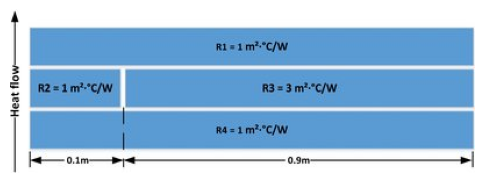


Options:
(A) 4.5 m²·°C/W
(B) 5.0 m²·°C/W
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


[F-CIET-036]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What is the difference between capillary action and diffusion?

Options:
(A) Capillary action causes liquid water to move through porous materials or across small gaps, whereas diffusion is a process whereby vapour passes through a seemingly solid material
(B) Capillary action causes liquid water to move through porous materials or across small gaps, whereas diffusion is a process whereby vapour passes through air leakages in the building envelope
(C) A hundred times more moisture can enter a building structure by capillary action than by diffusion
(D) Moisture flow through diffusion can be stopped, whereas it can only be delayed for capillary action
------------------------------
Multimodal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


[F-CIET-037]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
How does moisture affect indoor air quality?

Options:
(A) Low relative humidity leads to condensation and the formation of mould
(B) Condensation leads to mould formation and the release of toxins in the air
(C) Water vapour leads to mould formation and the release of toxins in the air
(D) Low humidity levels improve air quality
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29160, Requested 1133. Please try again in 586ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-038]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following is not an effect of extremely low humidity in a house?

Options:
(A) Frosting and fogging of windows
(B) Ozone production
(C) Respiratory infections
(D) Excessive dust problems
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28878, Requested 1233. Please try again in 222ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-039]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false regarding asbestos?

Options:
(A) From the 1950s to 1990s, asbestos was a popular material widely used in more than 3,000 building materials
(B) Asbestos poses health risks only when fibres are present in the air that people breathe, such as in renovation projects whereby walls, ceilings, floors or equipment are opened and dismantled
(C) Vermiculite insulation does not contain asbestos
(D) If you are renovating or demolishing a house or building built before 1990, there is a strong probability that at least some parts contain asbestos
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Issuing Agency | Document Number | Title of Document |
| Canadian Commission on Building and Fire Codes (CCBFC) | NRCC 53301 | National Building Code of Canada 2015 |
| Canadian Standard Association (CSA) | CANICSA F 280-12 | Determining the Required Capacity of Residential Space Heating and Cooling Appliances |
| Government of Canada |  | Health Risks of Asbestos (http://healthycanadians.gc.ca/environment- |
|  | environnement/outdoor-air-exterieur/asbestos-amiante- eng.php) |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 3:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29025, Requested 1044. Please try again in 138ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-CIET-040]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements about mould is false?

Options:
(A) Mould can lead to eye, nose, and throat irritation
(B) Mould is odourless and, as such, can only be detected visually
(C) Typically, mould is found in humid areas with a higher risk of condensation
(D) Moulds and fungi are found in nature
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


Text Source 3:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29245, Requested 1311. Please try again in 1.112s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29157, Requested 1125. Please try again in 564ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-101]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
The interior of the external walls of a house measure 5.3 m by 8.7 m, with a bump-out that is 2.3 m wide by 1.1 m deep. The ceiling is 2.44 m high. The interior perimeter, area, and volume are:

Options:
(A) 23.4 m, 46.8 m², 118.6 m³
(B) 30.2 m, 48.6 m², 119 m³
(C) 28 m, 46.1 m², 112.5 m³
(D) 32.6 m, 48.6 m², 119 m³
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Table Source 1:


| | |
| :--- | :--- |
| 5.1.1 | Rated annual energy consumption |
|  | 5.1.2 Rated annual energy production .. |
| 5.2 | RATED ENERGY INTENSITY... |
| 5.3 | REFERENCE HOUSE. |
| 5.4 | DESIGN HEATING AND DESIGN COOLING LOADS ....ssesseceeeeeseeeeeeeeeeeseneeeeeceeeeseeeeeeeaeeeeeeneeeeseeaeeeeenaeeeess 26 |
| 5.5 RATED GREENHOUSE GAS EMISSIONS .......cccceeseeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaeeaeeeeeeeeeeesseeeeeseeeeaaaanaagaes |
| 5.5.1 | Direct greenhouse gas emissions... |
|  | 5.5.2 Indirect greenhouse gas emissions . |
| 5.5.3 | Indirect greenhouse gas emissions offset by renewable electrical energy production... |
| ADDITIONAL SERVICES weseeeeeeseneeeueeeseenseeenneneeseeeeeeeesesseneeeuensseeeoonnneneeeeeeeeseeeeeeeueensseessssscccseseees 29 |
| 6.1 | RENOVATION UPGRADE SERVICE......seeseeeeeeeeeeeeneeeeeeeaeeeeeaaeeeeeeeeesecaeeeseaeaeeeseeeeeenaeeeseaeasesseeeeeenaeees |
| 6.1.1 | Rating COMPArAtOrS..... eee cece cee ceeeeeceeeeseseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseeseesensaeeages |
| 6.1.2 | Development of upgrade recommendations |
| 6.1.3 Methodology for calculation of the individual savings . |
| 6.2 CONSTRUCTION UPGRADE SERVICE FOR NEW HOMES... ccsec see eece senses sceeseceseoesceeeseessoeeseneeseeaeoes |
| 6.2.1 | Base and upgrade case modelling |
| 6.2.2 | Rating comparators. |
| /PENDIX A: ASSUMED HOUSE PARAMETERS... .ssccsceceeseeeeeeeseeneenuencesenseeaneeneeeeeeeeeeeeesesseeseesesssssscssssssss OA PENDIX B: CHANGE MANAGEMENT |
| .. PENDIX C: ATYPICAL ENERGY LOADS.. |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| Electrical load | Houses (kWh/day) | MURB (kWh/day/unit) |
| Interior lighting | 2.6 | 17 |
| Appliances (refer to Table 6) | 6.3 | 5.2 |
| Other electrical | 9.7 | 44 |
| use) Daily total | 19.5 | 11.7 |
| Electrical load | Houses (kWh/day) | MURB (kWh/m?/day) |
| Common space |  | 0.086 |
| Annual total | 25.6 GJ/year | 15.5 GJ/year + common space |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from


Text Source 4:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29047, Requested 1067. Please try again in 228ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-102]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
The area of a circle is 28.3 ft². The diameter of that circle is:

Options:
(A) 3 ft
(B) 5.3 ft
(C) 6 ft
(D) 18.85 ft
------------------------------
Multimodal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| Category | Specification | Approximate reduction Liday (U.S. gal/day) |
| Low-flow showerheads | 7.6 Limin (2.0 US gpm) or less | 19 (5.0) |
| Low-flow bathroom faucets &#124; | 5.7 L/min (1.5 US gpm) or less | 10 (2.6) |
| Clothes washer | ENERGY STAR certified | 18 (4.8) |
| Dishwasher | ENERGY STAR certified | 3 (0.8) |
| Approximate total | potential reduction | 50 (13.2) |



Table Source 3:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28942, Requested 1138. Please try again in 160ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-103]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following best describes a semi-detached home?

Options:
(A) It is attached to one other house.
(B) It is underneath or on top of the other unit.
(C) It is attached on both sides instead of one.
(D) It is a mobile home.
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29345, Requested 1044. Please try again in 778ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-104]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
A gas furnace has a steady-state rating of 90% with an input of 60,000 Btu/hr. Its output in Btu/hr would be:

Options:
(A) 66,700
(B) 60,000
(C) 54,000
(D) 51,000
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29087, Requested 1144. Please try again in 462ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28895, Requested 1107. Please try again in 4ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-105]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Which of the following is not normally part of the building envelope?

Options:
(A) Front door
(B) Garage roof
(C) Crawlspace floor
(D) Skylight
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 4:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28992, Requested 1146. Please try again in 276ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-106]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following best describes the desired effect of mechanical systems in a home?

Options:
(A) Provide the means to make house chores easier
(B) Provide space conditioning for occupant comfort that meets the needs of the home
(C) Provide heating, cooling, and dehumidification
(D) Provide the means to generate electricity to satisfy occupant needs
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29004, Requested 1144. Please try again in 296ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-107]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following strategies would likely have the biggest effect on overall air leakage in a home?

Options:
(A) Insulating the attic with fiberglass
(B) Caulking all the outlets and switch plates
(C) Filling the empty wall cavities with dense-pack cellulose
(D) Upgrading all the windows
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29065, Requested 1097. Please try again in 324ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-108]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
In a plan view, which part of a house usually goes at the bottom of the drawing?

Options:
(A) The foundation
(B) The back side
(C) The front side
(D) The longest side
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29023, Requested 1137. Please try again in 320ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-109]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
Which is the best description of the heating load of a particular house?

Options:
(A) The daily average heat required for December, January, and February
(B) The amount of time below 18°C in days per year
(C) The total amount of energy consumed each year by the heating system
(D) The power required to heat the house at the design temperatures
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28828, Requested 1210. Please try again in 76ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-110]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
The function of combustion air is to:

Options:
(A) Keep the house from imploding
(B) Provide combustion and dilution air directly to the appliances
(C) Remove exhaust gases from the house
(D) Keep the furnace and water heater equipment within design temperatures
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29089, Requested 1069. Please try again in 316ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-201]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Convert the following dimensions to metres: 24'3" x 29'4".

Options:
(A) 7.4 x 8.94
(B) 8 x 10
(C) 72 x 90
(D) 7.5 x 9
------------------------------
Multimodal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from


Table Source 1:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| Common space |  |
| Elevator | 3-14 GJ |
| Fitness room | 5-15 GJ |
| Snowmelt system | 5-40 GJ |
| Unheated garage | 5-34 GJ |



------------------------------
Single-modal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29310, Requested 1157. Please try again in 934ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-202]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
The following best describes the specific heat of a substance:

Options:
(A) The energy required to change the temperature of air without affecting its moisture content
(B) The energy required to change the temperature of 1 gram of water by 1°C
(C) The energy required to change the state of 1 gram of water without changing its temperature
(D) The energy required to raise a gram of water 1 metre
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29082, Requested 1059. Please try again in 282ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-203]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Insulation with an R value of 12 would have a U value of:

Options:
(A) 11
(B) 2.11
(C) 0.833
(D) 0.083
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29148, Requested 1133. Please try again in 562ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28932, Requested 1133. Please try again in 130ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-204]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
The following best describes convection:

Options:
(A) Heat transfer due to direct contact between two materials of differing temperature
(B) Heat transfer within an oven to accelerate cooking or baking
(C) Heat transfer due to movement within a fluid such as water or air
(D) Heat transfer due to rising heat
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29138, Requested 1095. Please try again in 466ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-205]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
Internal heat gain is produced by the following sources:

Options:
(A) Furnaces and boilers
(B) Excessive exercise
(C) Sunlight coming through windows
(D) Humans, cooking, and refrigeration
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29112, Requested 1113. Please try again in 450ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-206]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
For a wall with an RSI value of 1.2, what is the rate of heat loss through an area of 1 m² when the inside and outside temperatures are 22 and -18°C, respectively?

Options:
(A) 3.33 W
(B) 33.3 W
(C) 48 W
(D) 0.03 W
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28816, Requested 1326. Please try again in 284ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-207]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Which two criteria best describe the conditions necessary for airflow?

Options:
(A) Gravity and humid air
(B) Pressure difference and physical connection
(C) Fan operation and ductwork
(D) Temperature difference and physical connection
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28880, Requested 1250. Please try again in 260ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-208]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
The following best describes reverse stack effect:

Options:
(A) Wind creates a pressure difference on the exterior of the house
(B) Induced draft furnace in the basement draws air through openings on the second floor
(C) Exhaust fans create negative pressure that draws air down the chimneys of mechanical equipment
(D) The tendency to draw air in at the top of the building when temperatures inside are cooler than outside
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29008, Requested 1170. Please try again in 356ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-209]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
The following best describe the conditions at dew point:

Options:
(A) The tidal pull of the rising sun draws water from the ground
(B) Dry air contacts a wet surface
(C) Humid air cooling past its saturation point
(D) Steam condensing on the inside of a radiator
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 2:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 2:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29340, Requested 1117. Please try again in 914ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-ENVIRO-210]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
At a constant temperature, how much vapour does air contain at 60% R.H.?

Options:
(A) 0.6 g
(B) 60% of the vapour it would contain at 20°C
(C) 60% less than the maximum
(D) 60% of the vapour it could contain at that temperature
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29113, Requested 1387. Please try again in 1s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-101]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Canadian Commission on Building and Fire Codes sets a minimum standard required for building performance and safety but does not require a minimum level of energy efficiency.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Issuing Agency | Document Number | Title of Document |
| Canadian Commission on Building and Fire Codes (CCBFC) | NRCC 53301 | National Building Code of Canada 2015 |
| Canadian Standard Association (CSA) | CANICSA F 280-12 | Determining the Required Capacity of Residential Space Heating and Cooling Appliances |
| Government of Canada |  | Health Risks of Asbestos (http://healthycanadians.gc.ca/environment- |
|  | environnement/outdoor-air-exterieur/asbestos-amiante- eng.php) |



Table Source 2:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



Table Source 3:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


is exposed to vermiculite To obtain information concerning Natural Resources Canada’s suite of housing initiatives or the documents cited herein, contact us by email: ERSStandard-NormeSCE@nrcan-rncan.gc.ca. 5 EnerGuide Rating System—Standard—Version 15.12 2.2 Documents published by other organizations


Text Source 2:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29217, Requested 1123. Please try again in 680ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29011, Requested 1123. Please try again in 268ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-102]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
The state that causes the water to condense on a window and drip onto the window sill is called "Capillary Action".

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28936, Requested 1131. Please try again in 134ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-103]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
The following exterior moisture sources can lead to water damage in the building envelope: groundwater, rain, fog, snow, surface runoff, and ice.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28875, Requested 1286. Please try again in 322ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-104]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
What is NOT the specific concern associated with an uninsulated chimney on an exterior wall when combustion gases are not present?

Options:
(A) It can become very cold when combustion gases are not present.
(B) It can result in damage to the materials in the chimney and ice formation.
(C) This can lead to condensation of moisture from the air.
(D) It can reduce combustion energy used for heating area.
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[F-UDEMY-105]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What is the effect of an open skylight on the air conditioning of the home on summer days?

Options:
(A) AC unit works overtime
(B) House becomes cool and dry
(C) No effect
(D) The upper level will remain hot and humid
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[F-UDEMY-106]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following is 3.14159 rounded to 2 significant figures?

Options:
(A) 3.14
(B) 3.15
(C) 3.1
(D) 3.2
------------------------------
Multimodal RAG Sources:
Text Source 1:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Image Source 1:


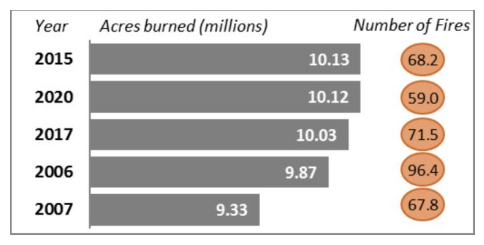


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Category | Specification | Approximate reduction Liday (U.S. gal/day) |
| Low-flow showerheads | 7.6 Limin (2.0 US gpm) or less | 19 (5.0) |
| Low-flow bathroom faucets &#124; | 5.7 L/min (1.5 US gpm) or less | 10 (2.6) |
| Clothes washer | ENERGY STAR certified | 18 (4.8) |
| Dishwasher | ENERGY STAR certified | 3 (0.8) |
| Approximate total | potential reduction | 50 (13.2) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 3:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 4:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


[F-UDEMY-107]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What is the following type of wall?


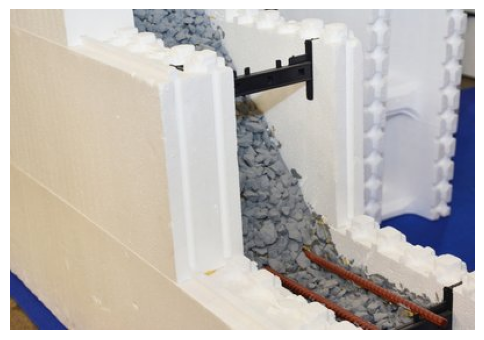


Options:
(A) Expanded Polystyrene (EPS)
(B) Insulated Concrete Forms (ICFs)
(C) Extruded polystyrene foam
(D) Fiberglass insulation
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[F-UDEMY-108]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Energy rating number for appliances, the lower the number, the better while for heating and cooling equipment, the higher the number, the better.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 4:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


------------------------------
Single-modal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 3:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 4:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


[F-UDEMY-109]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
A warm edge spacer reduces thermal conduction across the opaque area at the edge of the glass.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


[F-UDEMY-110]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Which of the following terms does NOT describe a type of sealant or caulking?

Options:
(A) Polyurethane
(B) Silicone
(C) Acoustical
(D) Spunbonded polyolefin
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 3:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 4:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 3:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 4:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


[F-UDEMY-111]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
The stack effect increases when the difference in temperature between the interior and exterior of a house increases.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[F-UDEMY-112]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What is the optimum range of comfort Relative Humidity(%) for human beings?

Options:
(A) 20% to 30%
(B) 30% to 55%
(C) 50% to 85%
(D) 20% to 85%
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



Table Source 2:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28939, Requested 1131. Please try again in 140ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-113]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
One of the biggest disadvantages of a mini-split cooling system over a window-mounted AC unit is that it must be installed by a qualified contractor.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28662, Requested 1696. Please try again in 716ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28474, Requested 1728. Please try again in 404ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-114]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
What type of furnace is shown in the following picture?


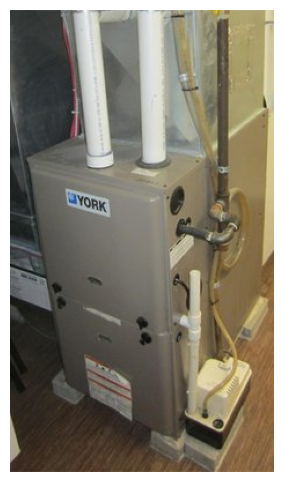


Options:
(A) Conventional
(B) Electric
(C) Condensing
(D) Induced draft fan
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


[F-UDEMY-115]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
The perimeter of a square with a side length of 5 units is:

Options:
(A) 25 square units
(B) 20 units
(C) Cannot say, we need more information
(D) 5 units
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28573, Requested 1599. Please try again in 344ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-116]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following is 3.14159 rounded to 3 decimal places?

Options:
(A) 3.14
(B) 3.15
(C) 3.142
(D) 3.141
------------------------------
Multimodal RAG Sources:
Text Source 1:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Image Source 1:


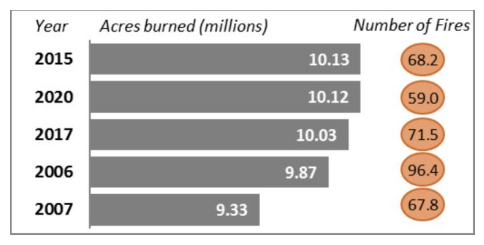


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Category | Specification | Approximate reduction Liday (U.S. gal/day) |
| Low-flow showerheads | 7.6 Limin (2.0 US gpm) or less | 19 (5.0) |
| Low-flow bathroom faucets &#124; | 5.7 L/min (1.5 US gpm) or less | 10 (2.6) |
| Clothes washer | ENERGY STAR certified | 18 (4.8) |
| Dishwasher | ENERGY STAR certified | 3 (0.8) |
| Approximate total | potential reduction | 50 (13.2) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


6 Additional services The following sections outline the general technical aspects of the additional services, defined as services other than the Basic Service that are available through the EnerGuide Rating System. For a summary of these services see section 4.3.2 of this document and, for complete details, see the EnerGuide Rating System—Technical Procedures sections 4, 5 and 6. 6.1 Renovation Upgrade Service 6.1.1 Rating comparators In addition to the EnerGuide Rating, the Renovation Upgrade Service includes various comparators calculated by the approved compliance software and provided in the Renovation Upgrade Report. These include the following: The rated house built using


[F-UDEMY-117]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Studies have shown that approximately 100 times more moisture enters a building structure by airflow than by diffusion under moderate pressure differences between the exterior and interior environments.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29057, Requested 1122. Please try again in 358ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28889, Requested 1256. Please try again in 290ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-118]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
Which house is most likely to experience problems with indoor air quality?

Options:
(A) A low air change rate and a low amount of moisture generation
(B) A high air change rate and a limited amount of moisture generation
(C) A high air change rate and a high amount of moisture generation
(D) A low air change rate and a high amount of moisture generation
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29108, Requested 1064. Please try again in 344ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-119]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Calculate 3 to the power of 5.

Options:
(A) 243
(B) 263
(C) 253
(D) 283
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29155, Requested 991. Please try again in 292ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-120]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
Which option does NOT reduce lighting loads?

Options:
(A) Installing efficient lighting systems
(B) Dimmers/timers
(C) Using natural light
(D) Photovoltaic panels
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 3:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


Table Source 1:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| De-icing cables | 4-10 GJ |
| Electric vehicle charging station | 8-12 GJ |
| Extensive exterior lighting | 5-23 GJ |
| Heated garage (attached or detached) | 10-25 GJ |
| Hot tub | 11-31 GJ |
| Non-residential occupancy |  |
| Outdoor gas appliances | 3-9 GJ |
| Swimming pool | 13-53 GJ |
| Room air conditioner - per unit | 2-10 GJ |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 3:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


Text Source 4:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28979, Requested 3078. Please try again in 4.114s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28864, Requested 1876. Please try again in 1.48s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28818, Requested 1187. Please try again in 10ms. Visit https://platform.openai.com/account/rate-limits to 

[F-UDEMY-121]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(Invalid): No-RAG - WRONG
------------------------------
Question:
What is the statement of the following symbol?


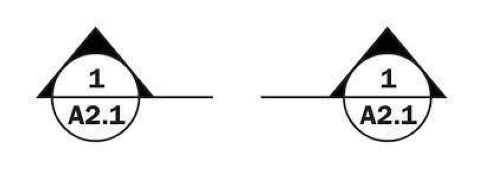


Options:
(A) Above grade
(B) True north
(C) Cross section
(D) Site line
------------------------------
Multimodal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Image Source 1:


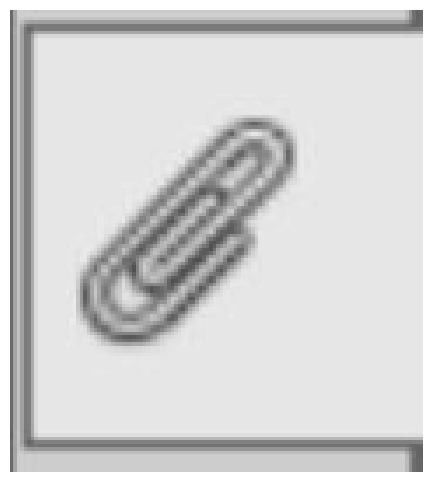


Image Source 2:


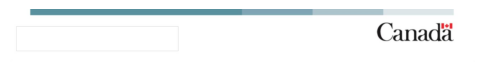


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29104, Requested 1033. Please try again in 274ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-122]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
What's the diameter of a circle with the same area as a 100 sq ft square?

Options:
(A) 5.64 ft
(B) 5.64 m
(C) 11.28 m
(D) 11.28 ft
------------------------------
Multimodal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| De-icing cables | 4-10 GJ |
| Electric vehicle charging station | 8-12 GJ |
| Extensive exterior lighting | 5-23 GJ |
| Heated garage (attached or detached) | 10-25 GJ |
| Hot tub | 11-31 GJ |
| Non-residential occupancy |  |
| Outdoor gas appliances | 3-9 GJ |
| Swimming pool | 13-53 GJ |
| Room air conditioner - per unit | 2-10 GJ |



Table Source 3:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 3:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 4:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29023, Requested 1092. Please try again in 230ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-123]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Which of these is commonly used as air barrier material?

Options:
(A) Sill gasket
(B) Fiberglass insulation
(C) Rim board
(D) Teflon tape
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


[F-UDEMY-125]
------------------------------
(A): True answer

(C): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
With no cracks in a concrete basement/foundation, how does moisture travel through?

Options:
(A) Capillary Action
(B) Osmosis
(C) Diffusion
(D) Reversed-Osmosis
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29046, Requested 1872. Please try again in 1.836s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28829, Requested 1872. Please try again in 1.402s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-127]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
The following windows have the same U-frame = 5 W/m²K, U-Edge = 1.9 W/m²K and U-Glazing = 1.7 W/m²K. They also all have the same frame width. Which of the following has the lowest heat loss?


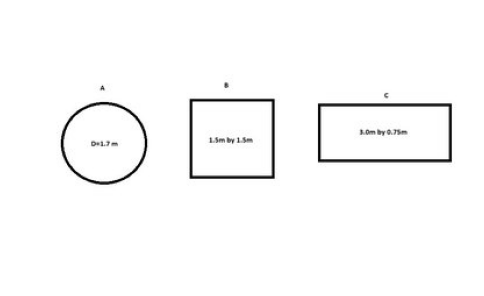


Options:
(A) Window C
(B) Window A
(C) Window B
(D) They are all the same
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


ii EnerGuide Rating System—Standard—Version 15.12 Summary of changes The Summary of changes table provides an overview of changes to this document as compared to the previous version. The “Building type impacted” column indicates the building type to which the change applies. Note that the previous version of this document is 15.10. Version 15.11 documents were not produced. This version is numbered 15.12 to align with the release of HOT2000 version 11.12 and the associated Report Generator.


[F-UDEMY-128]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
What type of water heater is shown below?


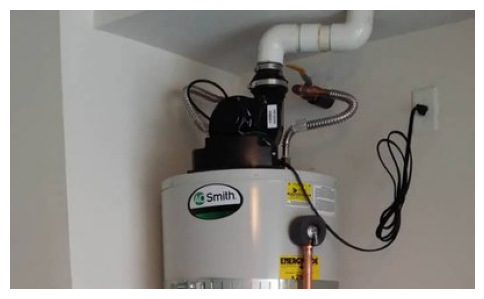


Options:
(A) Electric Tank
(B) Condensing
(C) Power Vent
(D) Boiler
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


[F-UDEMY-129]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
What are the main items displayed on the EnerGuide label for appliances in Canada?

Options:
(A) COP, SEER and energy rating
(B) Model number, types and capacity of models
(C) Annual energy consumption, model number, types and capacity of models and energy consumption indicator
(D) Make, model and size and annual energy consumption
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 2:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 3:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Interior Lighting | 25% to 75% of fixtures with compact fluorescent light bulbs or light emitting diodes | 1.6 kWhiday |
|  | &gt; 75% of fixtures with bulbs or light emitting | compact fluorescent light diodes | 0.6 kWh/day |
| Appliances | &#124; The actual EnerGuide lower than the | appliance rating must be standard values: | Use the actual EnerGuide |
| following |  | appliance rating. |
| Refrigerator: | 639 kWh/yr | If an appliance is not present, |
| Electric range: | 565 kWh/yr | default values must be used. |
| Dishwasher: | 260 kWh/yr |  |
| Clothes washer: | 197 kWh/yr |  |
| Clothes dryer: | 916 kWh/yr |  |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 2:


i EnerGuide Rating System—Standard—Version 15.12 Preface The EnerGuide1 Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdictions. The EnerGuide Rating System—Standard—Version 15 outlines the basis for rating new and existing houses under the EnerGuide Rating System. This Standard and its reference publications are to be used for the implementation of version 15 of the EnerGuide Rating System. These documents replace all previous EnerGuide Rating System requirements for both new and existing


Text Source 3:


E. Sampson Natural Resources Canada Secretary Ottawa, Ontario xii EnerGuide Rating System—Standard—Version 15.12 Introduction The EnerGuide Rating System is a national system developed by Natural Resources Canada to rate the energy performance of houses. Regional partners use this system for the purpose of assessing and depicting the energy performance of houses in their jurisdiction. The rating system is designed to achieve the following: help Canadian homeowners, industry and stakeholders, become “energy literate” regarding homes and the decisions related to them; provide specific, readily accessible energy performance information that is widely used to support decision making in designing, constructing, purchasing, renovating


Text Source 4:


iii EnerGuide Rating System—Standard—Version 15.12 Table of contents

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29059, Requested 1111. Please try again in 340ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-130]
------------------------------
(C): True answer

(D): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
What is the attic volume if the measure of the ceiling below the attic is 20'×40' and the attic is 8' at its peak?

Options:
(A) 4800 cubic feet
(B) 6400 cubic feet
(C) 3200 cubic feet
(D) 1600 cubic feet
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



Table Source 2:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[F-UDEMY-131]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
What type of electric water heater has reduced standby losses?

Options:
(A) Conserver tank
(B) Tankless coil
(C) Conventional tank
(D) Condensing storage-type
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 4:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29292, Requested 1125. Please try again in 834ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-132]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
The air layer in contact with a cold surface has a higher relative humidity than the warmer air away from the surface.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29188, Requested 1103. Please try again in 582ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-133]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
What is the total number of adhesive containers required to cover an area measuring 9.2m by 7.8m? Assume each container can cover 6.0 sqm, and that only full containers can be ordered.

Options:
(A) 20
(B) 12
(C) 74
(D) 37
------------------------------
Multimodal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Table Source 1:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| Common space |  |
| Elevator | 3-14 GJ |
| Fitness room | 5-15 GJ |
| Snowmelt system | 5-40 GJ |
| Unheated garage | 5-34 GJ |



Table Source 2:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| De-icing cables | 4-10 GJ |
| Electric vehicle charging station | 8-12 GJ |
| Extensive exterior lighting | 5-23 GJ |
| Heated garage (attached or detached) | 10-25 GJ |
| Hot tub | 11-31 GJ |
| Non-residential occupancy |  |
| Outdoor gas appliances | 3-9 GJ |
| Swimming pool | 13-53 GJ |
| Room air conditioner - per unit | 2-10 GJ |



------------------------------
Single-modal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29161, Requested 1088. Please try again in 498ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-134]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Capillary action is the movement of water through a porous material.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28876, Requested 1897. Please try again in 1.546s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28658, Requested 1897. Please try again in 1.11s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-135]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
What is the effective thermal resistance of the assemblies of the wall section below if:

A1 = R-Value 10
A2 = R-Value 12 (20% of shared area), 
A3 = R-Value 2 (80% of shared area)
A4 = R-Value 3.5


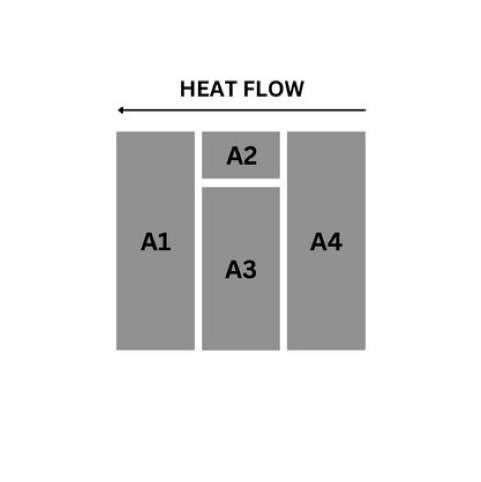


Options:
(A) R-18.4
(B) R-27.5
(C) R-15.9
(D) R-21.6
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[F-UDEMY-136]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
What is the statement of heat loss calculation through a surface?

Options:
(A) Surface area (square metres) × Temp. difference (Celsius) ÷ R-value
(B) Surface area (square feet) × Temp. difference (Celsius) ÷ R-value
(C) Surface area (square feet) × Temp. difference (Fahrenheit) ÷ R-value
(D) Surface area (square metres) × Temp. difference (Fahrenheit) ÷ R-value
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29081, Requested 1085. Please try again in 332ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-138]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What is the formula for calculating heat loss?

Options:
(A) Q = U × A × N × T
(B) a² + b² = c²
(C) R1 + R2 + R3...
(D) Q = U × A × ΔT
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29252, Requested 1871. Please try again in 2.246s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29126, Requested 1871. Please try again in 1.993s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29079, Requested 1184. Please try again in 526ms. Visit https://platform.openai.com/account/rate-limits t

[F-UDEMY-139]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(Invalid): No-RAG - WRONG
------------------------------
Question:
What type of DHW system is shown in the picture?


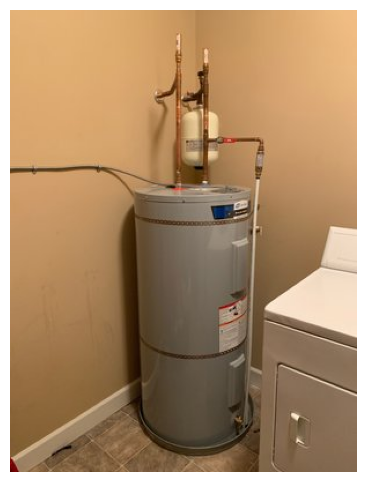


Options:
(A) Propane
(B) Natural Gas
(C) Electric
(D) Oil
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29435, Requested 889. Please try again in 648ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-141]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Convert 1 kW to BTU/hr. Round it to two decimal places.

Options:
(A) 7164.65
(B) 4281.96
(C) 3412.14
(D) 6824.28
------------------------------
Multimodal RAG Sources:
Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Appliance | Standard value (kWh/yr) | House occupant ratio | House value (kWh/yr) | MURB occupant ratio | MURB value (kWh/yr) |
| Refrigerator | 639 |  | 639 |  | 639 |
| Electric range | 565 |  | 565 |  | 565 |
| Clothes washer | 197 | 3/4 | 148 | 2/4 | 98.5 |
| Dishwasher | 260 |  | 260 | 2/4 | 130 |
| Clothes dryer | 916 | 3/4 | 687 | 2/4 | 458 |
| Annual total | 2577 |  | 2299 |  | 1891 |
| Daily total | 7.1 kWhiday |  | 6.3 kWh/day |  | 5.2 kWhiday |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



Table Source 3:


| | | |
| :--- | :--- | :--- |
| Electrical load | Houses (kWh/day) | MURB (kWh/day/unit) |
| Interior lighting | 2.6 | 17 |
| Appliances (refer to Table 6) | 6.3 | 5.2 |
| Other electrical | 9.7 | 44 |
| use) Daily total | 19.5 | 11.7 |
| Electrical load | Houses (kWh/day) | MURB (kWh/m?/day) |
| Common space |  | 0.086 |
| Annual total | 25.6 GJ/year | 15.5 GJ/year + common space |



Table Source 4:


| | | |
| :--- | :--- | :--- |
| Interior Lighting | 25% to 75% of fixtures with compact fluorescent light bulbs or light emitting diodes | 1.6 kWhiday |
|  | &gt; 75% of fixtures with bulbs or light emitting | compact fluorescent light diodes | 0.6 kWh/day |
| Appliances | &#124; The actual EnerGuide lower than the | appliance rating must be standard values: | Use the actual EnerGuide |
| following |  | appliance rating. |
| Refrigerator: | 639 kWh/yr | If an appliance is not present, |
| Electric range: | 565 kWh/yr | default values must be used. |
| Dishwasher: | 260 kWh/yr |  |
| Clothes washer: | 197 kWh/yr |  |
| Clothes dryer: | 916 kWh/yr |  |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


Table 6 - Standard appliance loads


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29202, Requested 1889. Please try again in 2.182s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29035, Requested 1889. Please try again in 1.848s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28987, Requested 1217. Please try again in 408ms. Visit https://platform.openai.com/account/rate-limits t

[F-UDEMY-142]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(Invalid): No-RAG - WRONG
------------------------------
Question:
Calculate the total heated floor area based on the lengths of the interior walls shown below. The walls have a thickness of 0.5m (1.6 ft).


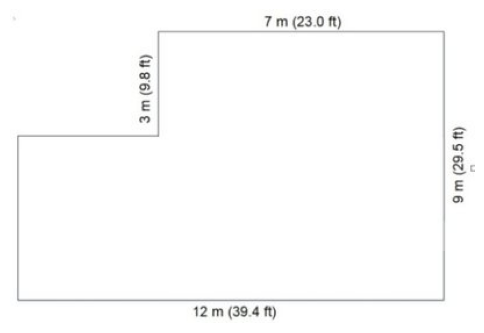


Options:
(A) 93 m² (1,001 ft²)
(B) 69 m² (743 ft²)
(C) 73 m² (786 ft²)
(D) 68 m² (732 ft²)
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29145, Requested 1249. Please try again in 788ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-143]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
What strategy can help let the envelope dry to the outside?

Options:
(A) By producing less moisture in the first place, exhausting moist air and bringing in drier air
(B) By building paper, siding, flashing, gutters and other construction techniques to shed water and repel wind-driven rain
(C) By layering materials most resistant to vapour diffusion on the warm side of the envelope and the least resistant on the outside
(D) By preventing moist indoor air from getting into the envelope
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28955, Requested 1099. Please try again in 108ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-144]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
A woman sitting beside a large window that was just installed feels cold on her skin. The window was installed properly and all systems are working well in the house. What is causing her to feel cold?

Options:
(A) Convection
(B) Radiation
(C) Conduction
(D) None of the above
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29077, Requested 1119. Please try again in 392ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-146]
------------------------------
(C): True answer

(A): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
What is the total heat loss through a wall section that is 8m × 10m, with a heat transfer coefficient value of 0.0417 (R24), if the temperature outside is +5°C and the inside temperature is +20°C?

Options:
(A) 92
(B) 76
(C) 50
(D) 45
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28887, Requested 1311. Please try again in 396ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-147]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements is false regarding high-efficiency mechanical systems in houses and residential buildings?

Options:
(A) A ground-source heat pump uses the earth, groundwater, or both as the source of heat in the summer
(B) Geothermal heat pump systems have an average 20+ year life expectancy
(C) The Air-Source heat pump draws heat from the outside air during the heating season and rejects heat outside during the summer cooling season
(D) Integrated mechanical systems (IMS) group the functions of space heating, water heating and heat recovery ventilation into a single package
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29230, Requested 1029. Please try again in 518ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29035, Requested 1029. Please try again in 128ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-148]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
A component in an assembly that transfers heat significantly faster than the surrounding materials is:

Options:
(A) A thermal bridge
(B) A conductor
(C) Advanced framing
(D) Insulation
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


[F-UDEMY-149]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What statement is false about an effective air barrier:

Options:
(A) It is a leakage control system
(B) It can only be located on the cold side of the assembly to avoid condensation
(C) The main air barrier material forms a principal plane
(D) There can be multiple air barriers
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29215, Requested 1014. Please try again in 458ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-150]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
If the temperature decreases, what effect does it have on the relative humidity level?

Options:
(A) Relative humidity will not change
(B) The relative humidity level will decrease
(C) The relative humidity level will increase
(D) None of the answers provided
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6.2.2 Temperature set points for space heating and cooling The EnerGuide Rating is calculated assuming standard thermostat settings (set points) for space heating and cooling as per Table 4. Table 4 - Temperature set points


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28976, Requested 1433. Please try again in 818ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-201]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(B): No-RAG - WRONG
------------------------------
Question:
What is the R-value of 7" of cellulose?

Options:
(A) 3.56
(B) 30.72
(C) 24.92
(D) 4.38
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Table Source 1:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


EnerGuide Rating System—Standard—Version 15.12 A. Holley Integrity Homes 2000 Inc.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28867, Requested 1869. Please try again in 1.472s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28687, Requested 1869. Please try again in 1.112s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-202]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
What is the heated area given exterior dimensions with 1' wall thickness?


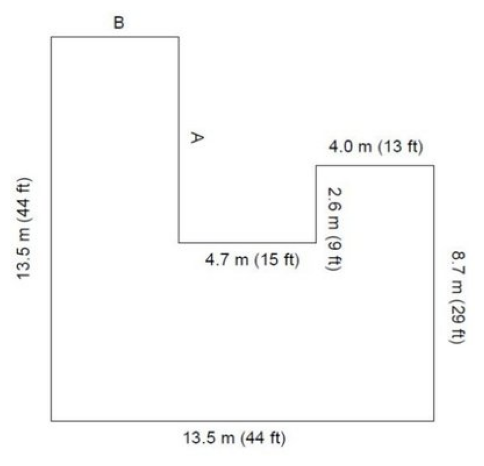


Options:
(A) 1191 cu ft
(B) 1191 sq ft
(C) 1239 sq ft
(D) 1239 sq m
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[F-UDEMY-203]
------------------------------
(B): True answer

(D): Multimodal RAG - WRONG
(D): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
What is the slope of a roof that has a rise of 10 feet and a span of 20 feet?

Options:
(A) 10:20
(B) 1:1
(C) 0.45
(D) 1:2
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[F-UDEMY-204]
------------------------------
(A): True answer

(D): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which of the following is usually the largest contributor of moisture in a home with an average family of four over a typical 7-day period?

Options:
(A) Respiration and perspiration
(B) Cooking three meals a day
(C) Cleaning a 12 square meter ceramic tile floor area with hot water and soap twice a week
(D) Each person takes one average length of shower per day
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Category | Specification | Approximate reduction Liday (U.S. gal/day) |
| Low-flow showerheads | 7.6 Limin (2.0 US gpm) or less | 19 (5.0) |
| Low-flow bathroom faucets &#124; | 5.7 L/min (1.5 US gpm) or less | 10 (2.6) |
| Clothes washer | ENERGY STAR certified | 18 (4.8) |
| Dishwasher | ENERGY STAR certified | 3 (0.8) |
| Approximate total | potential reduction | 50 (13.2) |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



Table Source 3:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Appliance | Standard value (kWh/yr) | House occupant ratio | House value (kWh/yr) | MURB occupant ratio | MURB value (kWh/yr) |
| Refrigerator | 639 |  | 639 |  | 639 |
| Electric range | 565 |  | 565 |  | 565 |
| Clothes washer | 197 | 3/4 | 148 | 2/4 | 98.5 |
| Dishwasher | 260 |  | 260 | 2/4 | 130 |
| Clothes dryer | 916 | 3/4 | 687 | 2/4 | 458 |
| Annual total | 2577 |  | 2299 |  | 1891 |
| Daily total | 7.1 kWhiday |  | 6.3 kWh/day |  | 5.2 kWhiday |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29126, Requested 1127. Please try again in 505ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-205]
------------------------------
(A): True answer

(B): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
Insulated attics usually do not have ice dams because the heat coming through the attic tends to melt snow as it lands and prevents much accumulation.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28833, Requested 1219. Please try again in 104ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-206]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What is the minimum height required for the underside of the joists of decks or other accessible exterior platforms to ensure the foundation is below frost level so that movement does not cause drainage to be directed into the house?

Options:
(A) More than 600 mm (24 in.) above the ground
(B) More than 600 mm (24 in.) above the Foundation
(C) More than 300 mm (12 in.) above the foundation
(D) More than 600 mm (12 in.) below the ground
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28971, Requested 1179. Please try again in 300ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-207]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following operable window types is the most prone to air leakage?

Options:
(A) Hopper
(B) Single-hung
(C) Bay
(D) Tilt and turn
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28894, Requested 1163. Please try again in 114ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-208]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
The inside dimensions of a one-storey house with a full basement are 6m × 10m. The basement is 2.7m high from the floor to the underside of the joists. The first-floor structure of open web wood joists totals 0.3m in height. The long walls of the main floor are 3m high, and they support a full-length cathedral ceiling with a 12:12 slope with two equal slopes. What is the approximate heated volume of the house?

Options:
(A) 540 cubic metres
(B) 432 cubic metres
(C) 414 cubic metres
(D) 450 cubic metres
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29149, Requested 1293. Please try again in 884ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28963, Requested 1293. Please try again in 512ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-209]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
What weather conditions do building materials and furnishings absorb moisture from the air and then in what weather conditions expel it?

Options:
(A) During the heating season, absorb moisture from the air and expel it during humid weather
(B) During humid weather, absorb moisture from the air and expel it during the heating season
(C) During the cooling season, absorb moisture from the air and expel it during the heating season
(D) During humid weather, absorb moisture from the air and expel it during the cooling season
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29089, Requested 1129. Please try again in 436ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-210]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
The frame of a house has a base length of 26 ft and a height of 50 ft. What is the area of the end wall?

Options:
(A) 1300 sq ft
(B) 625 sq ft
(C) 637 sq ft
(D) 645 sq ft
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28869, Requested 1248. Please try again in 234ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-211]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What is the best solution if condensation occurs inside a sealed double-glazed unit?

Options:
(A) Weatherstrip the inner sash to prevent air leakage
(B) Increase the ventilation capacity
(C) Reduce humidity levels in the house
(D) Replace the glazing unit
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28919, Requested 1540. Please try again in 918ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-212]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What is the difference between XPS and EPS rigid foam boards?

Options:
(A) XPS is always blue, and EPS is always white
(B) EPS is a solid rigid board. XPS is made up of little white balls
(C) EPS generally has a higher R-value
(D) XPS is a solid rigid board. EPS is made up of little white balls
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



Table Source 2:


| | |
| :--- | :--- |
| "ABLE OF | CONTENTS .. «IV |
| AEMBERS | OF THE ADVISORY COMMITTEES acceseuecccccccccceeeeeeeueuuuccceeeeeeeeeeeauauccneeeeeeeeeeeanccceteeeeseseansssessees WI |
| GENERAL. |
| 1.10 | SCOPE weeeeeeeteeeseeee eee ete ener ene eee ene ee eens eeeeeeae ee seeeeeeeeeaee ee eaaeeeseaeeeseeeeeeseeeeeeseaaeaeeeeeeeseeeeeeseeeseeeneeee 1 |
| 1.2 | APPLICATION ...eseeseeeeseeeeeeeeeeeeeeeeeeeeeeeeeeeeaeeeseaeeeeeesaeeseceaeeeseaeeaeeeeeeeseeeeeseeaeaseeneeseseneeeeseneeseenneeee 1 |
| 1.2.1 Eligible housing types. 1.3. STATE-OF-HOME REQUIREMENTS |
| 1.3.1. Mechanical systems .. |
| 1.3.2 | Windows, doors and skylights |
| 1.3.3 | Building envelope |
| 1.3.4 | Renovations |
| 1.3.5 | Electrical power source. |
| 1.4 REVISIONS TO THIS STANDARD 1.4.1 Change manageMent ...... eens eed eed sed see eeeseesedsoesedseesedsoesodseeseeeedeedseeseesensenges 3 |
| REFERENCE PUBLICATIONS wvsesseccccscccceeeeeeeeeneeucuceceeeeeeeueuauacaseeeeeseeeeegauucneueeeeeeeeeagceuseeeeeseseanssasasaess D |
| 2.1 | DOCUMENTS PRODUCED BY NATURAL RESOURCES CANADA .o.seeseeeeeeseseeeeeceeeeeneeeeeeeaeeesenaeeseeseeeeeenaeeeeenae 5 |
| 2.2 | DOCUMENTS PUBLISHED BY OTHER ORGANIZATIONS |
|  | AND DEFINITIONS .. |
| TERMS DESCRIPTION OF THE ENERGUIDE RATING SYSTEM ccscsceueceseeeenseneennsensenseeeneeeeeeeeeeeeeesesssnessessssssssees LO |
| 4.1 | THE ENERGUIDE RATING AND SCALE . 10 |
|  |  |
| 4.2 | ELEMENTS CONSIDERED IN THE RATING . |
| 4.2.1 Atypical energy loads... 4.3 ENERGUIDE RATING SYSTEM SERVICES |
| 4.3.1 | Basic SErviCe .......sssscsssessesessesesesseeesessesesecessesscsesesessesesacsesassenesecsesassesecessssasesecesansasasseencassasacsesncassaseeseeneansasesaees |
| 4.3.2 | Additional services . Online services |
| 4.3.3 .. 4.4 DATA COLLECTION 13 |
|  | REQUIREMENTS ..ssscssccceesessesseseeececceseseeeeeeeeecececeessceueeeeeeeeseseceeueeetseeeeeenssesatees |
| 4.4.1 4.4.2 | General information |
| 4.4.3 | Building envelope Heated floor area |
| 4.4.4 | Mechanical |
| 4.5 | systems WARNINGS.. |
| 4.5.1 | Vermiculite insulation |
| 4.5.2 | Exhaust device depressurization |



------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28889, Requested 1148. Please try again in 74ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-213]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
What is the diameter of a circular flue with the same area as a 9" × 9" square flue?

Options:
(A) 5.1"
(B) 10.4"
(C) 6.8"
(D) 10.2"
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29464, Requested 1080. Please try again in 1.088s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-214]
------------------------------
(C): True answer

(B): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
What is the volume of a room that is 15 ft by 15 ft by 8 ft?

Options:
(A) 2000 cu ft
(B) 1200 cu ft
(C) 1800 cu ft
(D) 1600 cu ft
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



Table Source 3:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29168, Requested 1144. Please try again in 624ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28908, Requested 1144. Please try again in 104ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-215]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
The stack effect, also known as the chimney effect, is caused by warm air rising in a house and drawing in cold air to replace it.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28902, Requested 1118. Please try again in 40ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-216]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
A cube has six sides. The width and length of each side of a sugar cube is 1.7 cm. What is the total surface area of the cube?

Options:
(A) 170 sq cm
(B) 17.34 sq cm
(C) 18.23 cu cm
(D) 4.91 cu cm
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 3:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Building type | # of Adults | # of Children |
| House | 2 | 1 |
| MURB (per unit) | 2 | 0 |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 3:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


[F-UDEMY-218]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What is the most flexible of all window types?

Options:
(A) Casement and awning windows
(B) Tilt-and-turn windows
(C) Single- or double-hung windows
(D) Horizontal and vertical slider windows
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28996, Requested 1123. Please try again in 238ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-219]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What term refers to a preassembled unit comprising of lites of glass, which are sealed at the edges and separated by dehydrated space(s)?

Options:
(A) Chromogenic glazing
(B) Dynamic glazing product
(C) Tubular daylighting device
(D) Insulating glass unit
------------------------------
Multimodal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


------------------------------
Single-modal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29111, Requested 1214. Please try again in 650ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28974, Requested 1097. Please try again in 142ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-220]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
What is the formula for circumference?

Options:
(A) Pi × r²
(B) 2 × r × Pi²
(C) Pi × d²
(D) 2 × Pi × r
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29265, Requested 1236. Please try again in 1.002s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-221]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
How do you conduct a 3-zone one fan test?

Options:
(A) Conduct three separate tests, one on each zone
(B) Run a hose to each of the other zones. Connect each hose to separate manometers. Repeat in all three zones
(C) Open a window to connect all three zones
(D) Run a hose to each of the other zones. Connect each hose to a single manometer. Repeat in all three zones
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



Table Source 2:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28950, Requested 1320. Please try again in 540ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28703, Requested 1320. Please try again in 46ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-222]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
Recently, Mr. Jones went through a house renovation where he upgraded the insulation in his walls and attic. However, he chose not to replace his old furnace or the brand-new AC unit. During summer, Mr. Jones contacted you to report that his house felt chilly and had a damp odour. What could be the potential root of this problem?

Options:
(A) The thermostat is broken and needs to be replaced
(B) The AC unit works short-cycling
(C) The new insulation in the walls is giving out excess moisture
(D) There is too much insulation in the attic
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[F-UDEMY-223]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What statement is associated with "Radon"?

Options:
(A) Breakdown of organic materials
(B) Breakdown of uranium
(C) It is released when wood appliances are used
(D) It can come from carpets, furniture, paint, and other sources
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28987, Requested 1136. Please try again in 246ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-224]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What component of the wall would cause the most thermal bridging?

Options:
(A) Batt insulation
(B) Gypsum board
(C) Vapour barrier
(D) Wood studs
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29065, Requested 1118. Please try again in 366ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-225]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(A): No-RAG - WRONG
------------------------------
Question:
An L-shaped foundation would have more than six sides.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 2:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 3:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29171, Requested 1208. Please try again in 758ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-226]
------------------------------
(A): True answer

(D): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - WRONG
------------------------------
Question:
Which of the following house configuration scenarios would NOT require the performance of the exhaust depressurization test procedure?

Options:
(A) A house with gas-fired, sealed combustion, direct-vented furnace and a wood-burning stove
(B) A house with a naturally aspirated furnace and an induced draft fan water heater
(C) A house with an oil-fired furnace, manufactured in 1989, and an electric water heater
(D) A house with gas-fired, sealed combustion, direct-vented furnace and electric water heater
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28994, Requested 1119. Please try again in 226ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-227]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
An increase in cooking, laundry and showering in an air-tight home may require which of the following to reduce the potential for excessive moisture levels in the home?

Options:
(A) Installing triple-glazed windows
(B) Upgrading the attic insulation
(C) Installing a balanced ventilation system
(D) Installing at least one ceiling fan on every floor
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29097, Requested 1044. Please try again in 282ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-228]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following statements about moulds is false?

Options:
(A) They can lead to eye, nose, and throat irritation
(B) Moulds and fungi are found in nature
(C) They are odourless and as such can only be detected visually
(D) Typically, they are found in humid areas with a higher risk of condensation
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29434, Requested 899. Please try again in 666ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-229]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
What is the unit of power?

Options:
(A) Watt
(B) Slug
(C) Gigajoule
(D) BTU
------------------------------
Multimodal RAG Sources:
Text Source 1:


Table 6 - Standard appliance loads


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Appliance | Standard value (kWh/yr) | House occupant ratio | House value (kWh/yr) | MURB occupant ratio | MURB value (kWh/yr) |
| Refrigerator | 639 |  | 639 |  | 639 |
| Electric range | 565 |  | 565 |  | 565 |
| Clothes washer | 197 | 3/4 | 148 | 2/4 | 98.5 |
| Dishwasher | 260 |  | 260 | 2/4 | 130 |
| Clothes dryer | 916 | 3/4 | 687 | 2/4 | 458 |
| Annual total | 2577 |  | 2299 |  | 1891 |
| Daily total | 7.1 kWhiday |  | 6.3 kWh/day |  | 5.2 kWhiday |



------------------------------
Single-modal RAG Sources:
Text Source 1:


Table 6 - Standard appliance loads


Text Source 2:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29194, Requested 1800. Please try again in 1.988s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28973, Requested 1930. Please try again in 1.806s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28927, Requested 1231. Please try again in 316ms. Visit https://platform.openai.com/account/rate-limits t

[F-UDEMY-230]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(Invalid): No-RAG - WRONG
------------------------------
Question:
What is the area and perimeter of a house with a turret? (3/4 of the turret perimeter is exposed).


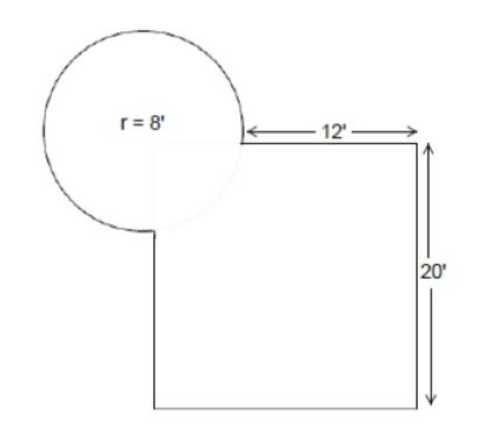


Options:
(A) Perimeter = 130.3 ft. Area = 550.8 sq. ft.
(B) Perimeter = 130.3 ft. Area = 601.1 sq. ft.
(C) Perimeter = 101.7 ft. Area = 601.1 sq. ft.
(D) Perimeter = 101.7 ft. Area = 550.8 sq. ft.
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Building type | # of Adults | # of Children |
| House | 2 | 1 |
| MURB (per unit) | 2 | 0 |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


[F-UDEMY-231]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(A): No-RAG - WRONG
------------------------------
Question:
A 200 mm deep pad is needed under a floor slab. How many cubic meters of material are needed if the floor slab area is 129.5 sq m?

Options:
(A) 29.8 cu. m.
(B) 25.9 cu. m.
(C) 45.2 cu. m.
(D) 33.1 cu. m.
------------------------------
Multimodal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


------------------------------
Single-modal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTE: These consumption figures were derived from various studies. Refer to Appendix C: Atypical energy loads for details. Additional atypical energy loads that are recognized by the System for MURBs are listed in Table 2. Table 2 - Atypical Energy Loads (MURBs only)


Text Source 4:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29198, Requested 1167. Please try again in 730ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29019, Requested 1161. Please try again in 360ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-232]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
For keeping heat in, which of the following materials requires air space on the warm side?

Options:
(A) Mineral fibre (loose fill)
(B) Extruded Polystyrene
(C) Radiant barrier
(D) Spray foam insulation
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29117, Requested 1126. Please try again in 486ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-233]
------------------------------
(C): True answer

(B): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
Which side is better to use exterior shading for windows to reduce overheating and glare?

Options:
(A) Windows facing west and north
(B) Windows facing east or west
(C) Windows facing south or west
(D) Windows facing south and north
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28828, Requested 1674. Please try again in 1.004s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28664, Requested 1655. Please try again in 638ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-235]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
What is the name of the horizontal beams shown in the picture?


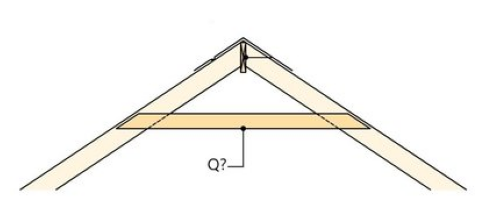


Options:
(A) Jack Rafter
(B) Hip Rafter
(C) Collar Tie
(D) Purlin
------------------------------
Multimodal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


viii EnerGuide Rating System—Standard—Version 15.12 EnerGuide Rating System Information Subcommittee members Chair J. Beckman Manitoba Hydro Winnipeg, Manitoba


------------------------------
Single-modal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


Manager of the Renewal Process D. Haltrecht F. Lohmann Technical Advisor A. Parekh E. Sampson Secretary x EnerGuide Rating System—Standard—Version 15.12 Streamlining Working Group members Chair G. Robson Prairie House Performance Winnipeg, Manitoba Vice-chair S. Goldberg Canadian Construction Controls Ltd. Ottawa, Ontario Voting members A. Brooks ATCO Energy Sense


Text Source 3:


EnerGuide Rating System—Standard—Version 15.12 A. Holley Integrity Homes 2000 Inc.


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


[F-UDEMY-236]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What is the best solution to prevent condensation between non-sealed glazing or storm windows when moist house air has leaked past the inner pane and condensed on the outer pane?

Options:
(A) Weatherstrip the inner sash to prevent air leakage
(B) Reduce humidity levels in the house
(C) Increase ventilation capacity
(D) Replace the glazing unit
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28938, Requested 1105. Please try again in 86ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-237]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Even in a well-insulated house up to 50% of the energy required for space heating can be used to make up for heat loss due to air leakage.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28939, Requested 1144. Please try again in 166ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-238]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(B): No-RAG - WRONG
------------------------------
Question:
What statement is associated with heat flow calculation through a surface?

Options:
(A) Surface area (square feet) × Temp. difference (Fahrenheit) ÷ U-factor
(B) Surface area (square metres) × Temp. difference (Celcius) × U-factor
(C) Surface area (square feet) × Temp. difference (Fahrenheit) × U-factor
(D) Surface area (square metres) × Temp. difference (Celcius) ÷ U-factor
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29161, Requested 998. Please try again in 318ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28945, Requested 1097. Please try again in 84ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-239]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
A crew of five is moving buckets of material out of a basement into a dumpster. The dumpster can take 34 buckets. How many buckets does each person have to move before the dumpster is full?

Options:
(A) n = 5 + 34
(B) 34 = n × 5
(C) n = 5 × 34
(D) 5 = 34 × 9
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Category | Specification | Approximate reduction Liday (U.S. gal/day) |
| Low-flow showerheads | 7.6 Limin (2.0 US gpm) or less | 19 (5.0) |
| Low-flow bathroom faucets &#124; | 5.7 L/min (1.5 US gpm) or less | 10 (2.6) |
| Clothes washer | ENERGY STAR certified | 18 (4.8) |
| Dishwasher | ENERGY STAR certified | 3 (0.8) |
| Approximate total | potential reduction | 50 (13.2) |



Table Source 2:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) Standard appliance ratings assume four occupants while the EnerGuide Rating System for homes assumes three occupants for houses and two occupants per unit for MURBs. Therefore, the loads for clothes washers, dishwashers and clothes dryers have been reduced using the multipliers seen in the table to remain consistent with the rating system’s standard operating conditions. 2) Freezer and microwave electrical consumptions are included in the “Other electrical” category. 4.6.2.5 Reduced operating conditions for zero-rated homes For homes with superior energy performance, there is provision for reducing some of the standard operating conditions. These reduced operating conditions are considered


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


[F-UDEMY-240]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
The base of a ladder should be placed so that it is ONE foot away from the building for every FOUR feet of height to where the ladder rests against the building. (4 to 1 rule or 4:1)

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Building type | # of Adults | # of Children |
| House | 2 | 1 |
| MURB (per unit) | 2 | 0 |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28970, Requested 1041. Please try again in 22ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-241]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
A duct travels from the exterior into the basement of a house and terminates between the furnace and water heater. What is it for?

Options:
(A) To balance air pressure
(B) Radon venting
(C) Humidity control
(D) Combustion air
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29073, Requested 1160. Please try again in 466ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-242]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(A): No-RAG - WRONG
------------------------------
Question:
As a general rule, at least two-thirds of a wall's insulation value should be on the warm side of the vapour barrier.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28992, Requested 1176. Please try again in 336ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28864, Requested 1160. Please try again in 48ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-243]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
What type of Urethane foam sealant can only be used around windows and doorframes or risk bowing?

Options:
(A) Urethane foam sealant cannot be used for this matter
(B) High expansion type
(C) Low expansion type
(D) Medium expansion type
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28979, Requested 1283. Please try again in 524ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-244]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
What statement is BEST associated with forced-draft venting of fuel-fired appliances?

Options:
(A) Mechanical draft created by a device downstream from the combustion zone of an appliance
(B) Draft created by a chimney's height and the temperature difference between the flue gases and the outside
(C) Mechanical draft created by a device upstream from the combustion zone of an appliance
(D) Draft created by a mechanical device that may supplement natural draft
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28918, Requested 1144. Please try again in 124ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-245]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
What term is used to describe the cross member that spans the length of the roof for structural support in buildings and typically is supported by both rafters or building walls when laid horizontally?

Options:
(A) Purlin
(B) Collar tie
(C) Rafter
(D) Ridge board
------------------------------
Multimodal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


------------------------------
Single-modal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29006, Requested 1067. Please try again in 146ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-246]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
7 concrete trucks can pour a foundation that has a perimeter of 220 feet. If the long side was 80 feet what is the shorter side?

Options:
(A) 27 ft
(B) 35 ft
(C) 25 ft
(D) 30 ft
------------------------------
Multimodal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Table Source 1:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| De-icing cables | 4-10 GJ |
| Electric vehicle charging station | 8-12 GJ |
| Extensive exterior lighting | 5-23 GJ |
| Heated garage (attached or detached) | 10-25 GJ |
| Hot tub | 11-31 GJ |
| Non-residential occupancy |  |
| Outdoor gas appliances | 3-9 GJ |
| Swimming pool | 13-53 GJ |
| Room air conditioner - per unit | 2-10 GJ |



------------------------------
Single-modal RAG Sources:
Text Source 1:


C12 Fitness room (MURBs only) Fitness rooms typically contain treadmills, elliptical machines and stationary bicycles that consume energy when operated and generate standby losses when not in use. Energy use range: 5 – 15 GJ/year. C13 Snowmelt system (MURBs only) This refers to electrically heated driveways with embedded heating cables to melt snow and ice. The energy use depends on the area being serviced, the annual hours of snowfall and the installed Watts- density of the melting system. Energy use range: 5 – 40 GJ. The range is based on a 46 m² (500 sq.ft.) driveway with 25 kW of


Text Source 2:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28735, Requested 1713. Please try again in 896ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-247]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What is the shape of the "gable end" walls of a cathedral if the roof slope is the same on each side?

Options:
(A) Rhombus
(B) Isosceles triangle
(C) Quadrilateral
(D) Right triangle
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Image Source 1:


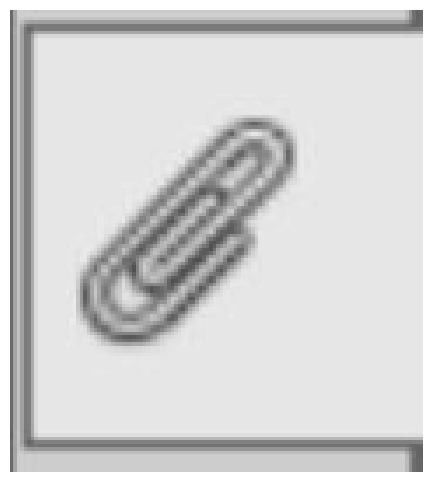


------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29009, Requested 1119. Please try again in 256ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-248]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
When the wind blows on one side of a house, it creates:

Options:
(A) Equal pressure on all sides of the house
(B) A low (or negative) pressure
(C) A high (or positive) pressure
(D) A tilt in the neutral pressure plane
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29130, Requested 1114. Please try again in 487ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29000, Requested 1114. Please try again in 228ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-249]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
What is an energy-efficiency value that refers only to the glass portion of a product and not the product as a whole?

Options:
(A) Visible transmittance (VT)
(B) Solar heat gain coefficient (SHGC)
(C) Centre-of-glass rating
(D) U-factor
------------------------------
Multimodal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


------------------------------
Single-modal RAG Sources:
Text Source 1:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 2:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 3:


11 EnerGuide Rating System—Standard—Version 15.12 For additional details on the consumption ranges, see Appendix C: Atypical energy loads. 4.3 EnerGuide Rating System services 4.3.1 Basic Service The Basic Service consists of an on-site energy evaluation of a house and subsequent energy modelling of the house using approved compliance software. With this service, the energy advisor performs both the on-site evaluation and the modelling but does not provide consultation services for a homeowner or builder. The approved compliance software determines the estimated annual energy consumption and annual energy production from on-site renewables, using standard operating conditions, and produces an EnerGuide Rating.


Text Source 4:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29189, Requested 1158. Please try again in 694ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-250]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
What are the causes of airflow through the building envelope?

Options:
(A) Wind effect, stratification, stack effect, reverse stack effect
(B) Combustion and ventilation effect, conduction effect, wind effect, stratification
(C) Stratification, stack effect, combustion spillage, reverse stack effect
(D) Stack effect, wind effect, combustion and ventilation effect, reverse stack effect
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29013, Requested 1892. Please try again in 1.81s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28825, Requested 1892. Please try again in 1.434s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-301]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Calculate the total heated floor area based on the lengths of the exterior walls shown below. The walls have a thickness of 0.5 m (1.6 ft).


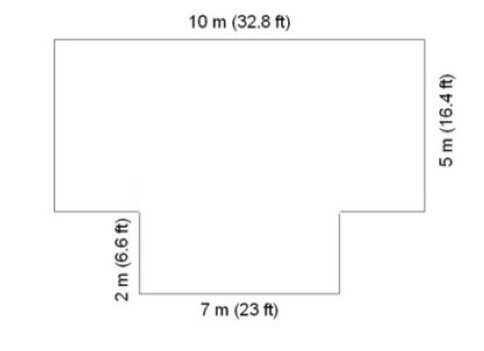


Options:
(A) 57 m² (614 ft²)
(B) 48 m² (517 ft²)
(C) 54 m² (581 ft²)
(D) 64 m² (689 ft²)
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29088, Requested 1128. Please try again in 432ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-302]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
Heat, air, and moisture flow influence each other.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Table Source 1:


| | |
| :--- | :--- |
| Characteristics | Default values |
| Ventilation fan flow rate (Q in L/s) | 28 L/s (22 L/s/unit for MURBs) |
|  | For HRV/ERV: |
| Ventilation fan power (Po in W - if an HRV/ERV then ventilation fan power at 0 °C) | Po Where Q is the average of the exhaust and supply flow rates. |
| For exhaust/supply only fans: |
| Po = 0.76Q If anon-HRV system has multiple fans or a supply and exhaust flow rate, calculate the exhaust and supply powers independently and sum them. |
| HRV/ERV fan power at -25 °C (P25 in W) | P25 = 0.0104*Q? + 1.3352°Q + 28 Where Q is the average of the exhaust and supply flow rates |
| HRV/ERV sensible efficiency at 0 °C (Eo) | 55% |
| HRV/ERV sensible efficiency at -25 °C (E25) | 45% |
| HRV/ERV sensible efficiency during cooling | 25% |
| Circulation fan power (Peirc in W) | Peire = Q*0.773 WILIs Where Q is the average of the non-zero supply and exhaust flow rates for one whole house system. If there is more than one system, calculate the circulation fan power for each system separately and then |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28762, Requested 1268. Please try again in 60ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-304]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(A): No-RAG - WRONG
------------------------------
Question:
How can moisture affect indoor quality?

Options:
(A) Water vapour can lead to mould formation and the release of toxins in the air
(B) Low relative humidity leads to condensation and the formation of moulds
(C) Condensation can lead to mould formation and the release of toxins in the air
(D) Low humidity levels improve air quality
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29279, Requested 927. Please try again in 412ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-305]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
You have a BBQ with a maximum heat output of 30,000 Btu/h (power). What is the equivalent in W?

Options:
(A) Btu/h is energy, while W is power
(B) 8,792 W
(C) 28,400 W
(D) 8,400 W
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



Table Source 2:


| | |
| :--- | :--- |
| Atypical Energy Load | Annual Consumption Range |
| De-icing cables | 4-10 GJ |
| Electric vehicle charging station | 8-12 GJ |
| Extensive exterior lighting | 5-23 GJ |
| Heated garage (attached or detached) | 10-25 GJ |
| Hot tub | 11-31 GJ |
| Non-residential occupancy |  |
| Outdoor gas appliances | 3-9 GJ |
| Swimming pool | 13-53 GJ |
| Room air conditioner - per unit | 2-10 GJ |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


Table 6 - Standard appliance loads


[F-UDEMY-308]
------------------------------
(B): True answer

(C): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What is the most common technical issue associated with slab-on-grade foundation construction in Canadian climates?

Options:
(A) The soil pressure will increase
(B) Foundation cracks
(C) The potential for moisture will increase
(D) None
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| Issuing Agency | Document Number | Title of Document |
| Canadian Commission on Building and Fire Codes (CCBFC) | NRCC 53301 | National Building Code of Canada 2015 |
| Canadian Standard Association (CSA) | CANICSA F 280-12 | Determining the Required Capacity of Residential Space Heating and Cooling Appliances |
| Government of Canada |  | Health Risks of Asbestos (http://healthycanadians.gc.ca/environment- |
|  | environnement/outdoor-air-exterieur/asbestos-amiante- eng.php) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28217, Requested 1881. Please try again in 196ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-309]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(C): No-RAG - CORRECT
------------------------------
Question:
Calculate the R-value of a wall assembly with the following components.


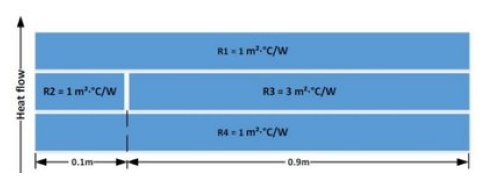


Options:
(A) 5.0 m²·°C/W
(B) 1.0 m²·°C/W
(C) 4.5 m²·°C/W
(D) 3.0 m²·°C/W
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[F-UDEMY-310]
------------------------------
(D): True answer

(B): Multimodal RAG - WRONG
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
What element destroys the ozone layer, leads to the formation of smog and acid rain, and is harmful to humans?

Options:
(A) H₂O
(B) NOx
(C) CO
(D) CO₂
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Image Source 1:


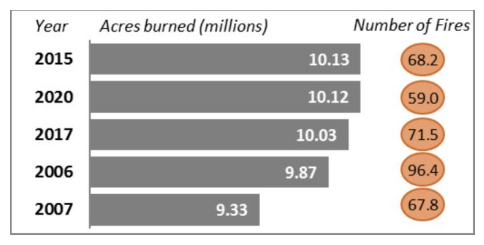


Image Source 2:


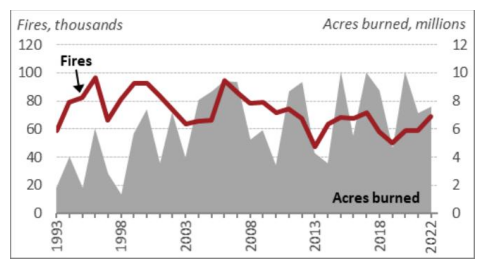


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


Wildfire Damages Figure 3. Percentage Acreage Burned by Ownership 100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020 Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the


Text Source 3:


Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960 Table 1. Annual Wildfires and Acres Burned


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


[F-UDEMY-312]
------------------------------
(D): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
What is the best way to reduce the annual energy consumption of a house?

Options:
(A) Use highly efficient equipment
(B) Use a high-performance HRV
(C) Install solar domestic hot water
(D) Tighten the building envelope
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6.3.5 Electrical base loads If the homeowner has indicated that more than half of their light fixtures use compact fluorescent light bulbs or light emitting diodes, the lighting load modelled will be reduced by 1 kWh/day, from 2.6 kWh/day to 1.6 kWh/day. If the homeowner has indicated that their refrigerator, stove and dishwasher are all less than five years old, the standard appliance load modelled will be reduced by 1 kWh/day, from 6.3 kWh/day to 5.3 kWh/day. 21 EnerGuide Rating System—Standard—Version 15.12 5 Rating system calculations The following sections outline the calculation of outputs from the EnerGuide Rating System Basic


Text Source 2:


4 Description of the EnerGuide Rating System 4.1 The EnerGuide Rating and scale The EnerGuide Rating is the annual net energy consumption of a house based on calculated energy use and production, expressed in gigajoules (GJ) per year. The scale ranges from zero, representing a house that produces as much energy as it uses on an annual basis to as high as is required for the house being rated. A house that produces more energy than it consumes in a year, otherwise known as a net-positive energy house, will receive a 0 rating and text indicating that the house produces


Text Source 3:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 4:


NOTES: Showerhead water reductions are calculated by the approved compliance software based on incoming water temperature, flow rate and a shower length of seven minutes. Therefore, the 19 L/day (5.0 U.S. gal/day) for showerheads and the total potential reduction are approximate numbers. The reduced showerhead and bathroom faucet flow rates are automatically applied to houses built in 2017 and more recent. b) Allowable electrical base loads reductions Zero-rated homes may reduce their electrical base loads for interior lighting and appliances as detailed in Table 8. The “Other electrical” and “Exterior use” categories may not be reduced. Table 8 - Allowable


[F-UDEMY-313]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Which structural component is designed to bear the weight of windows and doors installed above it?

Options:
(A) Jamb
(B) Collar tie
(C) Beam
(D) Lintel
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28333, Requested 1889. Please try again in 444ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28143, Requested 1889. Please try again in 64ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-314]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Calculate the total heated floor area based on the lengths of the interior walls shown below. The walls have a thickness of 0.5 m (1.6 ft).


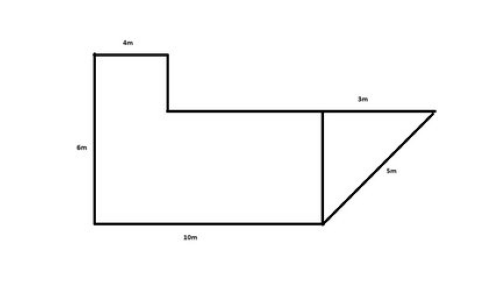


Options:
(A) 38 m² (409 ft²)
(B) 40 m² (431 ft²)
(C) 52 m² (560 ft²)
(D) 54 m² (581 ft²)
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[F-UDEMY-315]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Which of the following is considered a weather barrier material?

Options:
(A) Alkyd paints
(B) 6 mil polyethylene
(C) R-12 batt insulation
(D) House wrap
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


[F-UDEMY-317]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Which house is most likely to have a strong stack effect driving air leakage?

Options:
(A) Three-storey house on full basement
(B) Single-storey on crawl
(C) Bungalow on full basement
(D) A two-storey house on a slab
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28893, Requested 1122. Please try again in 30ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-319]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
Which of the following terms is constructed off-site?

Options:
(A) Tilt-up concrete walls
(B) Advanced framing
(C) Insulated concrete forms (ICFs)
(D) Exterior insulation and finishing systems (EIFS)
------------------------------
Multimodal RAG Sources:
Text Source 1:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28830, Requested 2371. Please try again in 2.402s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28607, Requested 1894. Please try again in 1.002s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-320]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(A): No-RAG - CORRECT
------------------------------
Question:
What are the following houses in the picture that were prevalent in Canada during World War II and the 1950s to 1960s?


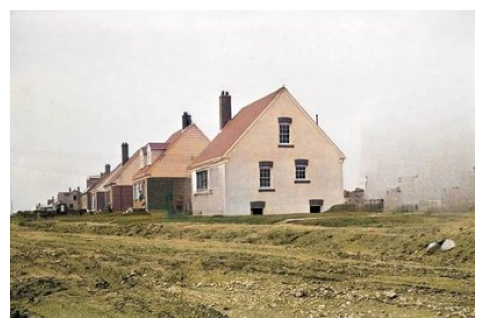


Options:
(A) Strawberry Box house
(B) Townhouse
(C) One and a half Storey
(D) Row House
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Image Source 1:


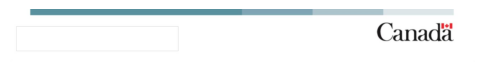


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Building type | # of Adults | # of Children |
| House | 2 | 1 |
| MURB (per unit) | 2 | 0 |



------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


1.2.1.2 Multi-unit residential buildings Multi-unit residential building: For a building to be eligible as a MURB under the EnerGuide Rating System, it must meet the requirements in section 1.2.1.1’s bulleted list and the following conditions: contains between two and 100 units; dwelling units do not share cooking or sanitary facilities; each dwelling unit has a private entrance either from the outside of the building or from a common space (e.g. hallway, lobby, vestibule, or interior stairway) that can be used without passing through another dwelling unit; units are fully or partially stacked or joined by a common space; secondary suites


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


[F-UDEMY-321]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
Conduction is heat transfer from surface to surface. How does conduction MOST impact the building envelope?

Options:
(A) Cold exterior temperature
(B) Thermal bridging across poorly insulated materials
(C) Through metal nails and screws
(D) Infiltration at windows
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29021, Requested 1137. Please try again in 316ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-322]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
Which one of the following is a sign of excessive moisture levels?

Options:
(A) Cracked window glazing
(B) Peeling paint or wallpaper
(C) Drafts under doors
(D) Convective loops
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28925, Requested 1159. Please try again in 168ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-325]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
What type of sealant should be used to help seal seams in the air/vapour barrier?

Options:
(A) Water-based caulking
(B) Synthetic rubber sealant
(C) 100% Silicone sealant
(D) Acoustical sealant
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 3:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28651, Requested 2463. Please try again in 2.228s. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28396, Requested 1714. Please try again in 220ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-326]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
What type of windows are shown below?


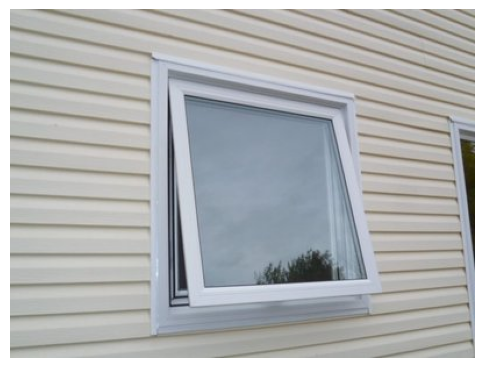


Options:
(A) Casement
(B) Awning
(C) Hopper
(D) Single hung
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Image Source 1:


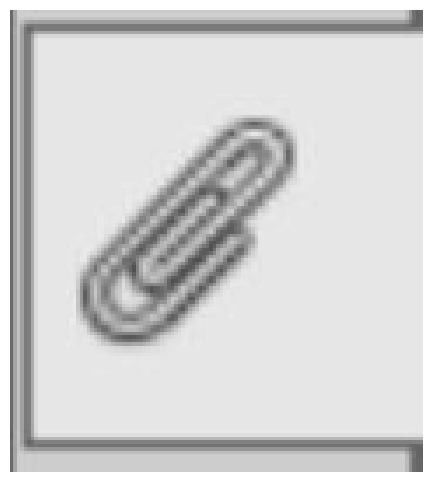


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


EnerGuide Rating System—Standard—Version 15.12 A. Holley Integrity Homes 2000 Inc.


Text Source 3:


4.2.1 Atypical energy loads Loads that are not common to most houses have been excluded from the rating calculation. However, some of them are still documented for the homeowner as atypical energy loads and their presence is highlighted on the label by an asterisk after the rating and a note. The type of load and typical range of annual consumption are reported on the Homeowner Information Sheet in the “House Details” section under “Significant Energy Uses Not Included in the Rating”. Eligible buildings that have a portion that is used for non-residential occupancy, as defined in section 1.2.1, will be


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


[F-UDEMY-328]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What is the term for metal, wire, or plastic pieces that hold wood forms together during a concrete pour?

Options:
(A) Form Tie
(B) J-Bolt
(C) Tension Rod
(D) Collar Tie
------------------------------
Multimodal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Table Source 1:


| | | |
| :--- | :--- | :--- |
| S. Goldberg | Canadian Construction Controls Ltd. Ottawa, Ontario |  |
| Voting members |
| M. Bourque | Enerplan Consultants Ltd. Moncton, New Brunswick |  |
| B. Fandrick | Inspections Department Y ellowknife, Northwest Territories |  |
| D. Farcasiu | AmeriSpec Mississauga, Ontario | (May 2010 — December 2010) |
| S. Gruescu | Carson Dunlop Newmarket, Ontario |  |
| T. Hermanson | 4 Element Integrated Design Ltd. Calgary, Alberta |  |
| A. Holley | Integrity Homes 2000 Inc. Dartmouth, Nova Scotia |  |
| G. Lengle | Terasen Gas Surrey, British Columbia |  |
| G. Robson | Prairie House Performance Winnipeg, Manitoba |  |



Table Source 2:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 3:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Text Source 4:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


[F-UDEMY-329]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
A boiling pot of water on a stove is an example of radiation, conduction, and convection.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29042, Requested 1112. Please try again in 308ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-331]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
What fluid is used as antifreeze fluid for solar domestic hot water (SDHW) systems?

Options:
(A) Propylene glycol
(B) Oil
(C) Water
(D) Glycerin
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29081, Requested 1068. Please try again in 298ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28933, Requested 1068. Please try again in 2ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-332]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(Invalid): Single-modal RAG - WRONG
(D): No-RAG - CORRECT
------------------------------
Question:
What are the MAIN products left over when natural gas has completely combusted?

Options:
(A) Carbon Monoxide and Sulfur
(B) Helium and Hydrogen
(C) Methane and Nitrogen
(D) Carbon Dioxide and Water Vapour
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 4:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 2:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 3:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 4:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28970, Requested 1224. Please try again in 388ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-333]
------------------------------
(B): True answer

(B): Multimodal RAG - CORRECT
(Invalid): Single-modal RAG - WRONG
(B): No-RAG - CORRECT
------------------------------
Question:
Which of the following terms emits a gas that irritates the eyes and throat?

Options:
(A) Radon
(B) Formaldehyde
(C) Methane
(D) Hydrogen Sulphide
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 3:


| | | :--- | | Dartmouth, Nova Scotia Non-voting ex officio members | | E. Sampson Natural Resources Canada Secretary | | Ventilation Working | Ottawa, Ontario Group members | | | Chair | | P. Edwards | Peter Edwards Co. Mississauga, Ontario | | | Voting members | | | | G. Cooke | Air Solutions Inc. Cambridge, Ontario | External Expert | | M. Lio | Lio &amp; Associates Toronto, Ontario | | | A. Parekh | Natural Resources Canada Ottawa, Ontario | | | W. Wilkinson | Wayne Wilkinson Consulting Whitehorse, Y ukon | | |


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


5.5.1 Direct greenhouse gas emissions Direct greenhouse gas emissions (𝐸𝐷) are those generated from on-site stationary combustion appliances fueled by natural gas, heating oil, propane or solid fuels (e.g. wood). They are calculated from the sum of the rated greenhouse gas emissions for each fuel type where each fuel emission is calculated by multiplying the quantity of fuel used by its emission factor. 𝐸𝐷 = ∑(𝐹𝐶𝐹,𝑅 × 𝐸𝐹𝐺,𝐹,𝑅 ) (13) Where: 𝐹𝐶,𝑅 is the net fuel consumed in physical units of quantity such as mass or volume: - by fuel type (natural gas, heating oil, propane, solid fuel); and by


Text Source 3:


4.5.3 Insufficient ventilation ...................................................................................................................................... 15 4.6 OPERATING CONDITIONS ...........................................................................................................16 4.6.1 General ........................................................................................................................................................... 16 4.6.2 Standard operating conditions .......................................................................................................................... 17 4.6.3 Household operating conditions ........................................................................................................................ 20 5 RATING SYSTEM CALCULATIONS ................................................................................................. 22 iv EnerGuide Rating System—Standard—Version 15.12


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[F-UDEMY-335]
------------------------------
(A): True answer

(A): Multimodal RAG - CORRECT
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
A homeowner called you and reported that he had placed a 1-meter sheet of polyethylene on the basement floor yesterday. However, upon returning today, he noticed the area under the sheet was wet. What term of the following statement describes the associated problem?

Options:
(A) Movement of moisture from the foundation
(B) High level of interior moisture
(C) Poor ventilation and dehumidifier
(D) Short-cycling
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29006, Requested 1019. Please try again in 50ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-336]
------------------------------
(D): True answer

(Invalid): Multimodal RAG - WRONG
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Which is most commonly used to measure humidity?

Options:
(A) Absolute humidity
(B) Beaufort scale
(C) Relative and absolute humidity
(D) Relative humidity
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Appliance | Standard value (kWh/yr) | House occupant ratio | House value (kWh/yr) | MURB occupant ratio | MURB value (kWh/yr) |
| Refrigerator | 639 |  | 639 |  | 639 |
| Electric range | 565 |  | 565 |  | 565 |
| Clothes washer | 197 | 3/4 | 148 | 2/4 | 98.5 |
| Dishwasher | 260 |  | 260 | 2/4 | 130 |
| Clothes dryer | 916 | 3/4 | 687 | 2/4 | 458 |
| Annual total | 2577 |  | 2299 |  | 1891 |
| Daily total | 7.1 kWhiday |  | 6.3 kWh/day |  | 5.2 kWhiday |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.6.2.4 Electrical base loads The EnerGuide Rating is calculated assuming that a standard amount of electricity (electrical base loads) is used as defined in Table 5 and Table 6. It is always assumed that houses and each MURB unit have an electric range and electric clothes dryer. It is also assumed that the clothes dryer exhausts to the outside and operates at a flow rate of 38 L/s (80.5 cfm), 56.5 minutes a day, 365 days per year. 18 EnerGuide Rating System—Standard—Version 15.12 Table 5 - Standard electrical base loads


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 4:


4.6 Operating conditions 4.6.1 General Two sets of operating conditions are available under the EnerGuide Rating System: standard operating conditions and household operating conditions. Standard operating conditions are used as the basis for the calculation of the EnerGuide Rating in order to provide an estimate of the home’s energy performance independent of occupant behaviour. Houses that reach a zero rating have access to reduced operating conditions for their rating calculations. 10 These calculations are performed by the approved compliance software on a “per temperature bin” basis. As a result, they cannot be performed manually. The values of Qtot from all

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29024, Requested 1103. Please try again in 254ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-337]
------------------------------
(B): True answer

(Invalid): Multimodal RAG - WRONG
(B): Single-modal RAG - CORRECT
(B): No-RAG - CORRECT
------------------------------
Question:
What are the three ways in which heat flows?

Options:
(A) Stack effect, Convection, Conduction
(B) Convection, Conduction, Radiation
(C) Convection, Rejuvenation, Airflow
(D) Radiation, Capillary Action, Stratification
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 3:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 4:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 29120, Requested 1028. Please try again in 296ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-338]
------------------------------
(A): True answer

(Invalid): Multimodal RAG - WRONG
(A): Single-modal RAG - CORRECT
(A): No-RAG - CORRECT
------------------------------
Question:
Heat rises, but can move in any direction.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Area of house | Type of set point | Temperature |
| Main and upper floors | heating daytime (16 hours) | 21 °C (70 °F) |
| heating nighttime (8 hours) | 18 °C (64 °F) |
| cooling | 25 °C (77 °F) if air conditioning present |
| Basement/walkout | &#124; heating | 19 °C (66 °F) 4 |
| cooling | 25 °C (77 °F) if air conditioning ducted to basement |
| Heated crawl space | heating | 15 °C (59 °F) |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


C9 Room air conditioner Room air conditioners are self-contained units used to cool a specific area of a house and may or may not require permanent installation. This category includes window, through-the-wall and single or dual-hose portable units. Energy use depends on variables such as the capacity, efficiency and configuration of the unit, the climate and the cooling temperature. Energy use ranges per air conditioning unit: 2 - 10 GJ/year. This range is based on a dual-hose portable and an ENERGY STAR certified window unit, each at 12,000 BTU/h operated over the cooling season from Saskatoon to Toronto. The percentage


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


6.2 Construction Upgrade Service for New Homes 6.2.1 Base and upgrade case modelling This service provides potential EnerGuide Ratings as a result of energy modelling of a base case and various upgrade cases for a home at the design stage. All modelling is done according to the EnerGuide Rating System—Technical Procedures and the EnerGuide Rating System—HOT2000 User Guide. 6.2.2 Rating comparators In addition to the comparators listed in section 6.1.1, the following comparators can be used when performing this service: ENERGY STAR for New Homes target (see the latest version of the ENERGY STAR for New Homes Standard); and R-2000

    "error": {
        "message": "Rate limit reached for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Used 28939, Requested 1167. Please try again in 212ms. Visit https://platform.openai.com/account/rate-limits to learn more.",
        "type": "tokens",
        "param": null,
        "code": "rate_limit_exceeded"
    }
}



[F-UDEMY-339]
------------------------------
(C): True answer

(Invalid): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
What statement is associated with the infiltration of -23°C outdoor air with 98% relative humidity on the indoor air quality of a home with an indoor air temperature of +23°C?

Options:
(A) Absolute humidity levels will increase
(B) Absolute humidity levels stay the same
(C) Relative humidity levels will decrease
(D) Relative humidity levels will increase
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


------------------------------
Single-modal RAG Sources:
Text Source 1:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


Text Source 4:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


[F-UDEMY-341]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
What is the function of a barometric damper?

Options:
(A) Prevents combustion gases from spilling back into the house
(B) Allows heat into the basement, minimizing heat waste
(C) Regulates the chimney draft on oil-fired furnaces, boilers, and water heaters
(D) Provides combustion air to gas appliances
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


NOTES: If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate. 2) When determining the default fan power for systems with multiple fans, or supply and exhaust flow rates, calculate the fan power for the supply and exhaust flow rates separately and sum the result. b) Where a whole-house ventilation system is present the following applies: The system is assumed to provide outdoor air at a flow rate of 28 L/s (22 L/s/unit for MURBs). If the continuous flow rate has been measured or is otherwise known, the actual rate shall be


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


[F-UDEMY-342]
------------------------------
(C): True answer

(C): Multimodal RAG - CORRECT
(C): Single-modal RAG - CORRECT
(C): No-RAG - CORRECT
------------------------------
Question:
Which of the following insulation materials is most suitable for installation on the gravel before a concrete basement floor is poured?

Options:
(A) Mineral wool insulation
(B) Open-cell spray foam insulation
(C) Extruded polystyrene insulation
(D) Fiberglass batts insulation
------------------------------
Multimodal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Section | type impacted | Change |
| 1.3.3 | All | Clarification. Foundations must be intact but interior finishes are not required to satisfy the state-of-home requirements. |
| 2.1 Appendix B1 | All | Revision. Contact email address is ERSStandard-NormeSCE@nrcan-rncan.gc.ca. |
| 4.2 Note 1 | All | Correction. For houses with heated crawl spaces the building envelope boundary extends to the exterior of the crawl space walls and slab or floor. This does not apply to unheated crawl spaces. |
| 5.3 | All | Addition. Reference to the National Building Code of Canada 2020. |
| Appendix A3 a) Note 1 | All | Correction. If multiple flow rates are available, then the fan is assumed to operate at the lowest flow rate, not highest flow rate. |



------------------------------
Single-modal RAG Sources:
Text Source 1:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


33 EnerGuide Rating System—Standard—Version 15.12 Appendix B: Change management To submit comments or change requests regarding documentation associated with Natural Resources Canada’s housing initiatives including this Standard, stakeholders are required to use the following procedure. B1 Procedure Proponent completes the attached Change Request Form and submits it to ERSStandard-NormeSCE@nrcan-rncan.gc.ca. Natural Resources Canada reviews the application for completeness and clarity. If incomplete or lacking clarity, Natural Resources Canada informs the proponent that the form does not comply with submission guidelines or requires clarification. Natural Resources Canada assesses the need for technical analysis and, if required, undertakes an internal analysis process. Natural


Text Source 4:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


[F-UDEMY-344]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Moisture can be a liquid, gas, water vapour, or solid.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


------------------------------
Single-modal RAG Sources:
Text Source 1:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 2:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 3:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 4:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


[F-UDEMY-345]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
How many percent is an average household energy bill for water heating in Canada?

Options:
(A) 10 to 25
(B) 15 to 25
(C) 5 to 10
(D) 25 to 30
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Table Source 1:


| | | |
| :--- | :--- | :--- |
| Interior Lighting | 25% to 75% of fixtures with compact fluorescent light bulbs or light emitting diodes | 1.6 kWhiday |
|  | &gt; 75% of fixtures with bulbs or light emitting | compact fluorescent light diodes | 0.6 kWh/day |
| Appliances | &#124; The actual EnerGuide lower than the | appliance rating must be standard values: | Use the actual EnerGuide |
| following |  | appliance rating. |
| Refrigerator: | 639 kWh/yr | If an appliance is not present, |
| Electric range: | 565 kWh/yr | default values must be used. |
| Dishwasher: | 260 kWh/yr |  |
| Clothes washer: | 197 kWh/yr |  |
| Clothes dryer: | 916 kWh/yr |  |



------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


C5 Hot tub This category refers to an indoor or outdoor freestanding vessel installed above ground, partially below, or in-ground. Energy use depends on variables such as the tub design, volume, use of insulated cover, pump horsepower and speeds, heating system, pump and motor efficiency and how the tub is used and operated. 11 HOT2000 is an official mark of Natural Resources Canada 36 EnerGuide Rating System—Standard—Version 15.12 Energy use range: 11 - 31 GJ/year. This range is based on an in-ground tub with insulated cover to an above ground with insulated cover, assuming a 40 °C water temperature with


Text Source 4:


C2 Electric vehicle charging station This refers to a charging station for an electric vehicle. Charging an electric car at home that is driven between 10,000 – 20,000 km/year can increase energy consumption by approximately 7 -14 GJ/year. Value for Nissan Leaf, adapted from Natural Resources Canada’s 2017 Fuel Consumption Guide, based on an average annual driving distance of 20,000 km where combined city and highway driving translates to 18.6 kWh/100 km. One litre of gasoline contains the energy equivalent of 8.9 kWh. Energy consumption: 20,000 /100 x 18.6 = 3720 kWh or 13.4 GJ To show driving ranges from


[F-UDEMY-346]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
Convection is heat transfer by:

Options:
(A) A hot and cold surface coming in contact with each other
(B) Electromagnetic waves
(C) Direct contact with a hot or cold surface
(D) The movement of a fluid such as water or air
------------------------------
Multimodal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 2:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 3:


5.1.1.3 Domestic water heating energy consumption The domestic water heating energy consumption (𝑤) is the total annual amount of energy required to meet the hot water load of the house, regardless of energy source. This can be described as follows: 𝑤 = 𝑤𝑃 + 𝑤𝑟 (7) Where: 𝑤𝑃 is the total annual (purchased) energy consumed by fuel-fired or electric water heaters; and 𝑤𝑟 is the renewable energy contribution from a solar hot water system. The total annual (purchased) energy consumed (𝑤𝑃) can be broken down further to account for the efficiency of the fuel-fired or electric water heater, and additional


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[F-UDEMY-347]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What following term is associated with the characterizing of effective thermal resistance?

Options:
(A) It is the insulation value when we take into account the heating degree days
(B) It is the insulation value of all the building components other than the insulating material
(C) It is the insulation value of the material itself
(D) It is the overall insulation value when we take into account all the building components of the assembly
------------------------------
Multimodal RAG Sources:
Text Source 1:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 2:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 3:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


------------------------------
Single-modal RAG Sources:
Text Source 1:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 2:


6 EnerGuide Rating System—Standard—Version 15.12 3 Terms and Definitions Words and phrases used in this Standard that are not included in this section shall have the meanings that are commonly assigned to them in the context in which they are used, taking into account the specialized use of terms by the various trades and professions to which the terminology applies. The following terms and definitions are italicized throughout the document and apply for the purposes of this document. airtightness test A test method specified in the EnerGuide Rating System—Technical Procedures to measure the air leakage of the building under the


Text Source 3:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


Text Source 4:


5.4 Design heating and design cooling loads Design heating and design cooling loads are based on the climatic data and building envelope details entered into the approved compliance software and are calculated using the methodology of CSA Standard F280-12, “Determining the Required Capacity of Residential Space Heating and Cooling Appliances”. The climatic data used by the approved compliance software is a selection of the Canadian Weather Energy and Engineering Datasets (CWEEDS) data provided by Environment and Climate Change Canada which does not match the data used by CSA Standard F280-12. The design heating and the design cooling loads are included


[F-UDEMY-348]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Air sealing has the potential to negatively affect the house as a system if proper precautions are NOT taken.

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


------------------------------
Single-modal RAG Sources:
Text Source 1:


1.3.2 Windows, doors and skylights Windows, exterior doors and skylights must be installed and intact. A maximum of one window, exterior door or skylight can be missing provided the opening is temporarily air sealed in accordance with the airtightness test. Any cracks in glazing shall be air sealed for the duration of the airtightness test. 1.3.3 Building envelope The building envelope must be in a suitable condition for an airtightness test. Exposed ceilings, exterior walls and exposed floors, including the interior finish, windows, doors and skylights as noted in section 1.3.2, must be intact. Foundations must also be intact but


Text Source 2:


4.4.4 Mechanical systems 4.4.4.1 Space heating and cooling The space heating and cooling systems’ data requirements include details on the following: space heating equipment, including combined space and water heating systems, and excluding portable units; and space cooling equipment, including central systems and fixed mini-split heat pump systems, excluding room units. NOTE: Space cooling room units refer to portable and window units that are considered atypical energy loads. 4.4.4.2 Ventilation equipment The ventilation data requirements include details on the following: whole-house ventilation systems such as heat recovery ventilators (HRV) and energy recovery ventilators (ERV); and the presence of supplemental fans,


Text Source 3:


4.5.3 Insufficient ventilation A house is deemed to have insufficient ventilation when the approved compliance software’s calculated ventilation rate does not meet the specific criteria indicated in this section. If the combined natural and mechanical ventilation rate (𝑄𝑡𝑜𝑡) during the critical month9 is less than the ventilation warning criteria (𝑄𝑤𝑎𝑟𝑛) (i.e. 𝑄𝑡𝑜𝑡 < 𝑄𝑤𝑎𝑟𝑛), the following warning will appear on the Homeowner Information Sheet: “The results of the energy simulation determined that this house may not receive sufficient outdoor air to maintain good indoor air quality. Please seek additional information from your energy advisor and a qualified ventilation contractor.” 4.5.3.1


Text Source 4:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


[F-UDEMY-349]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(D): Single-modal RAG - CORRECT
(D): No-RAG - CORRECT
------------------------------
Question:
What type of house is built off-site?

Options:
(A) Semi-detached house
(B) Row house
(C) Tilt-up house
(D) Modular house
------------------------------
Multimodal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


------------------------------
Single-modal RAG Sources:
Text Source 1:


xiii EnerGuide Rating System—Standard—Version 15.12 1 General 1.1 Scope The EnerGuide Rating System—Standard outlines the technical aspects of the EnerGuide Rating System (ERS). It covers topics such as eligibility requirements, pertinent references, terms and definitions. It also provides an overview of rating system services, data collection requirements, rating system outputs and some of the high-level calculations used for generating those outputs. NOTE: The terms “house” and “home” are used throughout this document to indicate a residential building or dwelling unit that is eligible to be rated under this Standard and are intended to include multi- unit residential building (MURB) single


Text Source 2:


4.3.3 Online services A range of online services directed at different user groups are provided to support the EnerGuide Rating System. There is general information about the rating system, and for homeowners or builders who have had an EnerGuide service, there are resources to supplement the information provided in the homeowner materials. 4.4 Data collection requirements This section provides an overview of the data requirements for modelling a house in the approved compliance software. Detailed data collection requirements are provided in the EnerGuide Rating System—Technical Procedures. 4.4.1 General information The following general information is required for a house to be


Text Source 3:


MURB single unit A single dwelling unit located within a MURB that meets the eligibility requirements. non-residential occupancy The occupancy of a building or part of a building, such as for commercial or institutional use, not intended to be used as residential. Examples of non-residential occupancies are a non-residential unit in a MURB and a room used for a commercial office in a house. on site/on-site Located within the property boundaries of the municipal or rural lot on which the house is situated. 8 EnerGuide Rating System—Standard—Version 15.12 passive solar gains The heat gained by the house from solar radiation


Text Source 4:


energy advisor An individual registered with Natural Resources Canada to deliver the EnerGuide Rating System Basic Service and additional services. ENERGY STAR® The ENERGY STAR name and symbol are registered trademarks of the United States Environmental Protection Agency and are used in Canada with permission. 7 EnerGuide Rating System—Standard—Version 15.12 float home A structure floating in water which incorporates a floatation system maintaining the building envelope above the waterline under normal load conditions, not primarily intended for, or usable in, navigation and does not include a water craft designed or intended for navigation. gigajoule (GJ) A standard unit of energy


[F-UDEMY-350]
------------------------------
(B): True answer

(A): Multimodal RAG - WRONG
(A): Single-modal RAG - WRONG
(A): No-RAG - WRONG
------------------------------
Question:
Absolute Humidity is the measure of water vapour (moisture) in the air, regardless of temperature. It is expressed as grams of moisture per cubic meter of air (g/m³).

Options:
(A) True
(B) False
------------------------------
Multimodal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Table Source 1:


| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Equipment &#124; quip | #of Units | Fan Power (W)&#124; | Flow Rate (Q,L/s) | Operating Schedule &#124; (min/dayfor365 &#124; days/year) | Fan Power (P,W) |
| Utility fans | - | - | Maximum | 72 | P=0.76Q |
| Bathroom &#124; fans | Max. 2 |  | 33 | 72 | P=0.76Q |
| Kitchen fans | Max. 1 |  | 75 | 72 | P=0.76Q |
| Laundry dryer | 1 | Included in base loads | 38 | 56.5 | NIA |



------------------------------
Single-modal RAG Sources:
Text Source 1:


NOTES: 1) A constant weighted average of 20 degrees Celsius is used to simulate the effect of the heating setback temperature. 2) Air conditioning can include heat pump space cooling systems. 3) If air conditioning is not ducted to the basement, the approved compliance software will allow the basement temperature to vary. 4) For MURBs, the basement heating temperatures will be the same as the main floor heating temperatures for a MURB single-unit located entirely in the basement and for a MURB whole-building if 50% or more of the basement is occupied by dwelling units located entirely in the basement.


Text Source 2:


5.1.1.1 Space heating energy consumption The annual space heating energy consumption (𝑠𝐻) of Equation (4) above takes into account the heat load of the building and the contribution of internal gains and passive solar gains, as well as the efficiency of the heating system and the energy required to distribute the heat: 𝑠𝐻 = 𝑙𝐻 − 𝑔𝐻𝑖 − 𝑔𝐻𝑠 𝑓𝐻 + 𝑑𝐻 (5) Where: 𝑙𝐻 is the gross annual heating load of the building; 𝑔𝐻𝑖 is the usable internal gains occurring during the heating season; 𝑔𝐻𝑠 is the passive solar gains occurring during the heating season; 𝑓𝐻 is the seasonal


Text Source 3:


5.2 Rated energy intensity The rated energy intensity of the house is calculated as the rated annual energy consumption of the house per unit of heated floor area per year, given in units of GJ/m2/year. The rated energy intensity calculation includes the renewable energy contribution from a solar domestic hot water system, since that contribution is included in the rated annual energy consumption, as described in section 5.1.1. Photovoltaics and wind energy contributions are excluded from both the rated energy intensity and the rated annual energy consumption. Rated energy intensity can be described as follows: 𝑐 𝑒𝑖 = 𝑎𝐹 (10)


Text Source 4:


NOTE: Gas appliances will not be considered as a reduction to electrical base loads. 4.6.3 Household operating conditions 4.6.3.1 General Homeowners have the option of providing a limited set of household operating conditions, which are used to generate an estimated household energy use. Household operating conditions are not used for the EnerGuide Rating System. All other inputs for the estimated household energy use calculation remain the same as those used for the rating calculation. 20 EnerGuide Rating System—Standard—Version 15.12 Household operating conditions can only be collected from property owners occupying the house at the time of the evaluation. 4.6.3.2 Number

In [85]:
# Main loop to process the questions
for idx, row in questions_df.iterrows():
    question_number = row['#']
    question_text = row['Question']
    image_needed = row['Image']
    options_text = row['Option']
    true_answer = row['Answer']

    # Load image if needed
    image_base64 = None
    if str(image_needed).strip().upper() == 'TRUE':
        image_path = os.path.join('EA QAs', f"{question_number}.jpg")
        image_base64 = encode_image(image_path)  # Adjust size as needed

    # Multimodal RAG agent
    mm_answer, mm_sources = rag_multiple_choice_qa(
        question_text, options_text, retriever_multimodal, image_base64
    )

    # Single-modal RAG agent
    sm_answer, sm_sources = rag_multiple_choice_qa(
        question_text, options_text, retriever_single_modal, image_base64=image_base64
    )

    # No-RAG agent
    nr_answer = no_rag_multiple_choice_qa(
        question_text, options_text, image_base64
    )

    # Compare answers to true answer
    mm_correct = 'CORRECT' if mm_answer == true_answer else 'WRONG'
    sm_correct = 'CORRECT' if sm_answer == true_answer else 'WRONG'
    nr_correct = 'CORRECT' if nr_answer == true_answer else 'WRONG'

    # Display the results
    print(f"[{question_number}]")
    print("-"*30)
    print(f"({true_answer}): True answer\n")
    print(f"({mm_answer}): Multimodal RAG - {mm_correct}")
    print(f"({sm_answer}): Single-modal RAG - {sm_correct}")
    print(f"({nr_answer}): No-RAG - {nr_correct}")
    print("-"*30)
    print("Question:")
    print(question_text)
    if image_base64:
        display_base64_image(image_base64)
    print("\nOptions:")
    print(options_text)
    print("-"*30)
    
    # Display Multimodal RAG Sources
    print("Multimodal RAG Sources:")
    mm_text_sources = mm_sources['texts']
    mm_image_sources = mm_sources['images']
    mm_table_sources = mm_sources['tables']
    
    # Display Multimodal Text Sources
    for i, text in enumerate(mm_text_sources):
        print(f"Text Source {i+1}:")
        display(Markdown(text))
        print()
    
    # Display Multimodal Image Sources
    for i, img_base64 in enumerate(mm_image_sources):
        print(f"Image Source {i+1}:")
        display_base64_image(img_base64)
        print()
    
    # Display Multimodal Table Sources
    for i, table_dict in enumerate(mm_table_sources):
        print(f"Table Source {i+1}:")
        table_content = table_dict['content']
        # Try to parse and display as HTML table
        try:
            tables = pd.read_html(StringIO(table_content))
            for table in tables:
                display(table)
        except ValueError:
            # If parsing fails, try to render as Markdown table
            try:
                display(Markdown(table_content))
            except Exception:
                # If all else fails, display the raw content
                print(table_content)
        print()
    
    print("-"*30)
    
    # Display Single-modal RAG Sources
    print("Single-modal RAG Sources:")
    sm_text_sources = sm_sources['texts']
    sm_image_sources = sm_sources['images']
    sm_table_sources = sm_sources['tables']
    
    # Display Single-modal Text Sources
    for i, text in enumerate(sm_text_sources):
        print(f"Text Source {i+1}:")
        display(Markdown(text))
        print()
    
    # Display Single-modal Image Sources
    for i, img_base64 in enumerate(sm_image_sources):
        print(f"Image Source {i+1}:")
        display_base64_image(img_base64)
        print()
    
    # Display Single-modal Table Sources
    for i, table_dict in enumerate(sm_table_sources):
        print(f"Table Source {i+1}:")
        table_content = table_dict['content']
        # Try to parse and display as HTML table
        try:
            tables = pd.read_html(StringIO(table_content))
            for table in tables:
                display(table)
        except ValueError:
            # If parsing fails, try to render as Markdown table
            try:
                display(Markdown(table_content))
            except Exception:
                # If all else fails, display the raw content
                print(table_content)
        print()
    
    print("="*100)